In [13]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src')
import os
os.environ['HF_HOME'] = '/raid3/xd/.cache/torch'  # deliberately set this wrong path to avoid migrating cache
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="8,7"

from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from dataclasses import dataclass, fields
import itertools
from itertools import chain
import math
from functools import reduce, partial
from collections.abc import Iterable
from collections import namedtuple 
import traceback
import pickle, gzip

# from multiprocessing import Pool
# from torch.multiprocessing import Pool
# torch.multiprocessing.set_start_method('spawn', force=True)
from multiprocessing.dummy import Pool

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

In [15]:
# from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, GPT2Tokenizer#, pipeline
# from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
# from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
# from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed, AdamW

In file_utils.py: default_cache_path = /raid3/xd/.cache/torch/hub


In [16]:
sys.path.insert(0, '/nas/xd/projects/PyFunctional')
from functional import seq
from functional.pipeline import Sequence
from fn import _ as __

In [17]:
from common_utils import Timer
with Timer('common_utils'): from common_utils import *
with Timer('utils'): from utils import *
with Timer('child_utils'): from child_utils import *
from child_utils import _cxt2str, _item2str
with Timer('child_utils'): from child_frames import *
with Timer('model_utils'): from model_utils import *
with Timer('weight_analysis'): from weight_analysis import *

common_utils ... done 0:00:00.000035
utils ... done 0:00:00.002716
child_utils ... done 0:00:00.056315
child_utils ... done 0:00:00.002634
model_utils ... done 0:00:05.949161
weight_analysis ... done 0:00:00.000040


In [18]:
with Timer('child_utils'): from child_utils import *

child_utils ... done 0:00:00.000213


In [19]:
torch.set_grad_enabled(False);

In [20]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-j-6B on elderberry
proxies = {'http': '192.168.50.1:1081'} 

In [21]:
# curl -x http://192.168.50.1:1081 -L -O [-C -] https://huggingface.co/google/ul2/resolve/main/pytorch_model.bin  # -C for 断点续传
s2s_model_names = ['google/t5-xl-lm-adapt', 'google/t5-xxl-lm-adapt', 'bigscience/T0p', 'bigscience/T0_3B', 
    'allenai/tk-instruct-3b-pos', 'allenai/tk-instruct-3b-def-pos', 'google/ul2']
gpt_model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-neox-20b', 'EleutherAI/gpt-neox-20b/cpu']#, 'gpt2-xl', 'gpt2']
#                    'KoboldAI/fairseq-dense-6.7B', 'KoboldAI/fairseq-dense-13B']
for model_name in s2s_model_names[:0] + gpt_model_names[:1]:#, 'gpt2-xl', 'EleutherAI/gpt-neo-1.3B', 'KoboldAI/fairseq-dense-6.7B']:
    if model_name in models: continue
    with Timer(model_name):
        model_cls = AutoModelForCausalLM if any(s in model_name for s in ['gpt', 'fairseq-dense']) else T5ForConditionalGeneration
        # _cache_dir = cache_dir.replace('/nas/', '/nas2/') if 'gpt' not in model_name else cache_dir
        kwargs = dict(cache_dir=cache_dir, proxies=proxies, low_cpu_mem_usage=True)
        if '/cpu' in model_name or 'gpt-j' not in model_name and 'gpt-neox' not in model_name:
            model = model_cls.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir, proxies=proxies)
        elif 'gpt-j' in model_name:
            device = 1
            model = model_cls.from_pretrained(model_name, revision="float16", torch_dtype=torch.float16, **kwargs).to(device)
        elif 'gpt-neox' in model_name:
            device = 0; device_map = {'gpt_neox': device, 'embed_out': device}
            model = model_cls.from_pretrained(model_name, device_map=device_map, load_in_8bit=True, **kwargs)
        if hasattr(model.config, 'use_cache'): model.config.use_cache = False  # save GPU mem
        # if model_name in ['EleutherAI/gpt-neox-20b']: model = model.half()
        tokenizer = AutoTokenizer.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir)
        unify(model)
        models[model_name] = model, tokenizer#, device

EleutherAI/gpt-j-6B/cpu ... done 0:01:49.886234


In [23]:
import openai
openai.api_key = open('/nas/xd/projects/openai_api_keys.txt').readlines()[4].split()[0]
response = openai.Completion.create(engine='text-davinci-002', prompt='Once upon a time',
    max_tokens=20, echo=True, logprobs=5)
print(response.choices[0].text)

Once upon a timeThere was a kingdomNow it's in my mindThe king and queenThey had a dream (wow


In [24]:
def get_openai_model(engine):
    def forward(input_ids):#, attention_mask=None):
        text = tokenizer.decode(input_ids[0])
        response = openai.Completion.create(engine=engine, prompt=text, max_tokens=0, echo=True, logprobs=5)
        return Outputs(logits=response.choices[0].logprobs)
    return forward
    
tokenizer0 = GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)
engines = ['text-babbage-001', 'text-curie-001', 'text-davinci-001', 'text-davinci-002'][1:] #+ \
#     ['curie', 'curie:2020-05-03', 'curie-instruct-beta', 'text-curie-001'] + \
#     ['davinci', 'davinci:2020-05-03', 'davinci-instruct-beta', 'davinci-instruct-beta:2.0.0', 'text-davinci-001', 'text-davinci-002']
for engine in engines: models[engine] = get_openai_model(engine), tokenizer0

In [25]:
model_name = gpt_model_names[0]
model, tokenizer = models[model_name]
unify(model)
if model_name == 'EleutherAI/gpt-neox-20b/' and model_name + '/cpu' in models:
    unify(models[model_name + '/cpu'][0])

blocks = model.transformer.h
attn0 = blocks[0].attn
ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), attn0.num_heads, attn0.embed_dim

In [26]:
we = model.transformer.wte.weight.data
wu = model.lm_head.weight.data

es = [we]
for b in blocks[:1]: es.append(es[-1] + mlp_forward(b, es[-1]))
model.es = es
weBTAs = [es[i].T @ es[i] for i in range(2)]
model.weBTAs = weBTAs

In [39]:
from const import *

Loading tokenizer ... done 0:00:09.293881


In [41]:
persons()

['Jack',
 'Ty',
 'Brandon',
 'Jones',
 'Johnny',
 'Matthew',
 'Major',
 'Brian',
 'Eric',
 'Jesus',
 'Neil',
 'Charles',
 'Clark',
 'Denver',
 'Carl',
 'Ian',
 'Robert',
 'Sam',
 'Van',
 'Ali',
 'Dallas',
 'Martin',
 'Kevin',
 'Howard',
 'Legend',
 'Albert',
 'Andy',
 'Graham',
 'Ray',
 'Jonathan',
 'Donald',
 'Jay',
 'Jimmy',
 'Peter',
 'Jon',
 'Davis',
 'Cruz',
 'Steven',
 'Louis',
 'Ford',
 'Alex',
 'Miller',
 'Justin',
 'Prince',
 'Blake',
 'Christopher',
 'Bruce',
 'Roger',
 'Leon',
 'John',
 'Lewis',
 'Christian',
 'Hunter',
 'Jerry',
 'Taylor',
 'Scott',
 'Angelo',
 'King',
 'Marco',
 'Warren',
 'Kyle',
 'Ari',
 'Aaron',
 'Elizabeth',
 'Emily',
 'Madison',
 'Victoria',
 'Ruby',
 'Alice',
 'Anna',
 'Sarah',
 'Eva',
 'Maria',
 'Rose',
 'Charlie',
 'Mary',
 'Summer',
 'River',
 'Georgia',
 'Faith',
 'June',
 'Amy',
 'Taylor',
 'Blake',
 'Morgan',
 'London',
 'Hope',
 'Rachel',
 'Jane',
 'Phoenix',
 'Winter',
 'Collins',
 'Dream',
 'Laura',
 'Michelle',
 'Joy',
 'Raven',
 'Kate',
 '

In [28]:
posets = [years, days_of_week, months, seasons]
posets

[['2010',
  '2011',
  '2012',
  '2013',
  '2014',
  '2015',
  '2016',
  '2017',
  '2018',
  '2019'],
 ['Monday',
  'Tuesday',
  'Wednesday',
  'Thursday',
  'Friday',
  'Saturday',
  'Sunday'],
 ['January',
  'February',
  'March',
  'April',
  'May',
  'June',
  'July',
  'August',
  'September',
  'October',
  'November',
  'December'],
 ['spring', 'summer', 'autumn', 'winter']]

In [581]:
from child_frames import *

In [585]:
person_adjs()

['Tall',
 'Short',
 'Fat',
 'Thin',
 'Hot',
 'Cold',
 'Careless',
 'Careful',
 'Sad',
 'Unhappy',
 'Happy',
 'Rich',
 'Poor',
 'Big',
 'Small',
 'Insensitive',
 'Sensitive',
 'Quiet',
 'Noisy',
 'Young',
 'Old',
 'Fast',
 'Slow',
 'Ugly',
 'Beautiful',
 'Clean',
 'Dirty',
 'Gentle',
 'Harsh',
 'Strong',
 'Weak',
 'Good',
 'Bad',
 'Conscious',
 'Unconscious',
 'Honest',
 'Fraudulent',
 'Dishonest',
 'Brave',
 'Cowardly',
 'Unpopular',
 'Popular',
 'Uncomfortable',
 'Comfortable',
 'Pessimistic',
 'Optimistic',
 'Responsible',
 'Irresponsible',
 'Irrational',
 'Rational',
 'Healthy',
 'Sick',
 'Unhealthy',
 'Friendly',
 'Unfriendly',
 'Asleep',
 'Awake',
 'Boring',
 'Uninteresting',
 'Interesting',
 'Dangerous',
 'Harmless',
 'Ignorant',
 'Knowledgeable',
 'Hardworking',
 'Lazy',
 'Correct',
 'Wrong',
 'Incorrect',
 'Male',
 'Female',
 'Inside',
 'Outside',
 'White',
 'Black',
 'Passive',
 'Active']

In [522]:
def aaasets():
    return years

In [523]:
aaasets()

['2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019']

In [656]:
def aaasets2():
    return list(string.ascii_uppercase)[:14]

In [10]:
aaasets2()

NameError: name 'aaasets2' is not defined

In [43]:
def get_posets():
    return posets

In [599]:
dictss = types_of_things()
dictssnew = {}
for key,value in dictss.items():
    value = [item.capitalize() for item in value]
    dictssnew[key.capitalize()] = value
def types_of_things_upper():
    return dictssnew

In [29]:
# I = Identity; M = Mophism; A = Aggregation; C = CMP; G = GroupBy; l = local
patterns = ['M', 'A?', 'IA', 'MA',
    'IlI', 'MlI', 'IlM', 'MlM', 'IlMlI',
    'IlA', 'MlA', 'IlC', 'MlC', 'AlI', 'GIlI']
# NE types: boy girl planet letter number month day
# TreeSet(name_genders), TreeSet(name_prons), # resolve iu in speech,  item[0]
# BijectSet(place_landmarks), BijectSet(sport_players) # count, item[1]

In [30]:
def ith_gen(rels, cxt_len=3):
    rels = [s.relations for s in rels]
    hop = 0; cxt = sample(rels[hop][0].dom(), cxt_len)
#     print(cxt)
#     print(rels[hop][0]._dict)
#     print(rels[hop][0].f(cxt[1]))
    query, candidates, ans = None, (cxt, cxt), rels[hop][0].f(cxt[1])[0]
    candidates = ([rels[hop][0].f(x)[0] for x in cxt], cxt)
    def transform_fn(ans):
        return ans, ans, ans
    return cxt, query, candidates, transform_fn(ans)

In [31]:
cxt, query, candidates, a = ith_gen([TreeSet(types_of_things).use('child')])

In [979]:
TreeSet(types_of_things).use('child').relations[0]._dict

defaultdict(list,
            {'animal': ['chicken',
              'duck',
              'goose',
              'dog',
              'lion',
              'cow',
              'donkey',
              'horse',
              'sheep',
              'goat',
              'bear',
              'tiger',
              'cat',
              'zebra',
              'pig',
              'giraffe',
              'monkey',
              'rabbit',
              'elephant',
              'wolf',
              'lion',
              'deer',
              'fox',
              'gorilla',
              'kangaroo',
              'squirrel',
              'mouse'],
             'fruit': ['apple',
              'banana',
              'pear',
              'grapes',
              'cherry',
              'orange',
              'peach',
              'plum',
              'lemon',
              'mango',
              'blackberry',
              'blueberries',
              'strawberries',
              'durian

In [964]:
cxt
candidates

['goose', 'beer', 'pink']

(['animal', 'drink', 'color'], ['goose', 'beer', 'pink'])

In [957]:
cxt, query, candidates, a = MlM_gen([EqSet(persons).use('equal'), TreeSet(types_of_things).use('parent')])

In [958]:
cxt
candidates

[('Jordan', 'kangaroo'), ('Rachel', 'blue'), ('Paris', 'fox')]

(['animal', 'color', 'animal'], ['kangaroo', 'blue', 'fox'])

In [807]:
vocabs, examples = make_examples(tasks[0], 8)

In [808]:
cxt_len = 3
counts = []

vocabs, examples = make_examples(tasks[0], nrows=8, cxt_len=cxt_len)
examples, text, bos_token = make_input_str(tasks[0], vocabs, examples, abstract=abstract)


In [46]:
tasks = [
#      (lambda: [EqSet(uppercase11).use('equal'), ], ith_gen, partial(_cxt2str, sep=' '), lambda q, _: '', ' ->'), 
    (lambda: [TreeSet(types_of_things).use('parent'), ], ith_gen, partial(_cxt2str, sep=' '), lambda q, _: '', ' ->'), 
    (lambda: [[TreeSet(types_of_things).child], [EqSet(persons).equal]], g2c(MlM_gen),
        partial(_cxt2str, sep='. ', item2str=lambda item, vocab: f"The {item[0]} is {item[1]}'s"),
        # lambda query, vocab: f'So does the {query[0]} belong to {query[1]}',
        lambda query, vocab: f'{query[0]} {query[1]}'#f"So is the {query[0]} {query[1]}'s",
    ), 
    (lambda: [[TreeSet(types_of_things).child], [EqSet(persons).equal]], MlM_gen,
     # partial(_cxt2str, prefix='There are ', item2str=lambda i, _: f"{i[1]}'s {i[0]}"), lambda q, _: f"So whose {q}", '?' # worse 
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f"The {i[0]} is {i[1]}'s"), lambda q, _: f'So the {q} belongs', 'Ġto'
    ),
    (lambda: [EqSet(persons).use('equal'), TreeSet(types_of_things).use('equal')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} has {wrap_noun(i[1])}'), lambda q, _: f'{q}', "'s"
    ),
    (lambda: [EqSet(persons).use('equal'), TreeSet(types_of_things).use('parent')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f"{i[0]} has {wrap_noun(i[1])}"), lambda q, _: f'{q}', "'s"
    ), # t: 21-5, 15-8, 19. p: 16-7, 18-5, [3-12, 13-7]. p+: 16-7, 16-0. 13-7:induction head qk, thing->type ov
    (lambda: [EqSet(persons).use('equal'), SymSet(person_adjs).use('equal')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f"{i[0]}'s {i[1]}"), lambda q, _: f'So {q}', " is"
    ), # c << g. cxt_len=3->2, gpt-j/neox better, davinci-001/002 worse!?
    (lambda: [EqSet(persons).use('equal'), SymSet(person_adjs).use('opposite')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f"{i[0]}'s {i[1]}"), lambda q, _: f"So {q} is", " not"
    ), # t: 16-14, somewhat 14-7
    # verbose acc: gpj-j > curie-001 > davinci-001 > gpt-neox!? abstract acc: gpt-neox > gpt-j. all poor (inc. davinci-002!)
#     (lambda: [[SymSet(person_adjs).equal], [EqSet(persons).equal]], MlM_gen,
#      partial(cxt2str, item2str=lambda i, _: f'{i[1]} is {i[0]}'), lambda q, _: f'So who is {}', '?'
#     ),  # gpt-neox good
# #     (lambda: [[EqSet(persons).equal], [PoSet(digits).equal], [EqSet(persons).equal]], g2c(IlMlI_gen),
# #         partial(cxt2str, item2str=lambda item, vocab: f'{item[0]} {item[1]}'),
# #         lambda query, vocab: f'{query[0]} and {query[1]} are same?'
# #     ),
# #     (lambda: [[EqSet(persons).equal], [PoSet(digits).equal], [EqSet(persons).equal]], lMlI_gen,
# #         partial(cxt2str, item2str=lambda item, vocab: f'{item[0]} is {item[1]}'),
# #         lambda query, vocab: f'{query} is the same as', # bare query is better for gpt-neox!?
# #     ),
#     (lambda: [[EqSet(persons).equal], [BijectSet(capabilities).proj]], partial(MlM_gen, cxt_len=2),
#      partial(cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} has {add_a_or_an(i[1])}'), lambda q, _: f'So {q}', 'Ġcan'
#     ),  # even davinci-001 is not very good
#     (lambda: [[EqSet(persons).equal], [BijectSet([(vt.did, vt.does) for vt in verb_tenses]).proj]], MlM_gen,
#      partial(cxt2str, sep='. '), lambda q, _: f'{q}', 'Ġusually'
#     ), # best performance among all tasks by all models. abstract > verbose
    (lambda: [EqSet(persons).use('equal'), TreeSet(country2capital).use('equal')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} lives in {i[1]}'), lambda q, _: f'{q} is', ' from'
    ),
    (lambda: [EqSet(persons).use('equal'), TreeSet(country2capital).use('parent')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} lives in {i[1]}'), lambda q, _: f'{q} is', ' from'
    ), # t: 19-12 > 16-10 = 12-7
    
    (lambda: [EqSet(persons).use('equal'), PoSet(get_posets).use('prev')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} arrived {wrap_noun2(i[1])}'), lambda q, _: f'{q} arrived', ' after'
    ), 
#     (lambda: [EqSet(persons).use('equal'), PoSet(get_posets).use('equal')], MlM_gen,
#      partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} arrived {wrap_noun(i[1])}'), lambda q, _: f'{q} arrived', ' after'
#     ), 
    (lambda: [EqSet(persons).use('equal'), PoSet(get_posets).use('next')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} arrived {wrap_noun2(i[1])}'), lambda q, _: f'{q} arrived', ' before'
    ),
#     (lambda: [EqSet(persons).use('equal'), EqSet(person_adjs).use('equal')], MlM_gen,
#      partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[1]} {i[0]}'), lambda q, _: f'{q}', ' is'
#     ),
#     (lambda: [TreeSet(types_of_things_upper).use('child'), EqSet(aaasets).use('equal')], MlM_gen,
#      partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} is bought in {i[1]}'), lambda q, _: f'{q} is bought', " in"
#     ),
#     (lambda: [TreeSet(types_of_things_upper).use('child'), EqSet(aaasets2).use('equal')], MlM_gen,
#      partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} is labeled {i[1]}'), lambda q, _: f'{q} is', " labeled"
#     ),
# t: 19-12 > 16-10 = 12-7
    # (lambda: [[EqSet(persons).equal], [BijectSet(city2resident).proj]], MlM_gen,
    #  partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} lives in {i[1]}'), lambda q, _: f'{q}', 'Ġis'
    # ), # a little worse than capital -> country
]

In [1029]:
from child_frames import _person_adjs
def person_adjs():
    ans = []
    for vec in _person_adjs:
        for tmp in vec:
            for a in tmp:
                ans.append(a.capitalize())
    return ans

In [73]:
results = {}; key = None

In [25]:
results.keys()

dict_keys([])

In [34]:
def result2dict(result): return {k: v for k, v in result.__dict__.items() if k not in ['task', 'data_tuples']}
with gzip.open(f'results_opposite.pkl.gz', 'wb') as f: pickle.dump({k: result2dict(r) for k, r in results.items()}, f)
# with gzip.open(f'results.pkl.gz', 'rb') as f: results = pickle.load(f)

In [35]:
attn_patterns_by_step = {-1: ['bos->ans0]'], 0: ['bos->ans]'], 1: ['ans]->ans0]', 'ans]->ans0+']}

In [36]:
del make_data_tuple; from child_utils import make_data_tuple

In [37]:
key

In [776]:
def uppercase11():
    return uppercase

In [856]:
def join_lists1(x, k_shot):
    xx = []
    for vec in x:
        xx.extend(vec[k_shot:])
    return xx

In [81]:
nrows, k_shot = 8, 3; save_results = True
for task, cxt_len, abstract, do_g2c in tqdm(list(itertools.product(tasks[-1:], [1], [0,], [False, ]))):
#     seed(42)
    args = dict(cxt_len=cxt_len, abstract=abstract)
    if do_g2c: args['do_g2c'] = do_g2c
    res_key = f"{task2str(task)} ({', '.join(f'{k}={v}' for k, v in args.items())})"
    # if 'TreeSet.parent) (cxt_len=1, abstract=0)' not in res_key: continue
    if save_results and key is not None and res_key != key: continue
    if save_results and res_key in results:
        result = results[res_key]; data_tuples = result.data_tuples
    else:
        batch_size = 4; verbose = not save_results or batch_size <= 32
        if verbose: print(f'===== {res_key} =====')
        all_examples, texts, bos_tokens = zip(*[generate(task, verbose=False, plot=False, nrows=nrows, **args)
                                                for i in range(batch_size)])
#         print(all_examples)
        result = Result(task, args, all_examples, texts)

        data_tuples, eval_results = zip(*[predict(model, tokenizer, text, examples,
            k_shot=k_shot, bos_token=bos_tokens[0], verbose=verbose)
            for text, examples in zip(texts, all_examples)])
        result.data_tuples = data_tuples
        loss, acc, *_ = zip(*eval_results)
#         print(loss)
#         print(acc)
#         print(join_lists1(acc,k_shot))
        result.mean_loss, result.mean_acc = np.array(loss).mean(), np.array(join_lists(acc)).mean()
        print(result.mean_loss, result.mean_acc)
        if save_results: results[res_key] = result
    if not save_results: continue

    for node_name in ['node']:#, 'argmax_node']:
        node = getattr(result, node_name, None)
        if node is None: node = add_node_to_result(result, node_name=node_name, label_type=node_name.replace('node', 'labels'))
        node.data.attr = mr(attribute_step)(data_tuples[:4], model, node)
    result.node.data.scores = {ap: mr(get_head_matching_scores)(data_tuples, ap, k_shot=k_shot)
        for ap in attn_patterns_by_step[node.data.step]} if 'g2c' not in res_key else None

100%|██████████| 1/1 [00:09<00:00,  9.31s/it]


In [738]:
from model_utils import attn_patterns_by_step

In [52]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")  # old full

MlM_gen(persons.EqSet.equal, get_posets.PoSet.prev) (cxt_len=1, abstract=0): 0.771, 0.95


Ford arrived in 2014. Ford arrived before 2015
August arrived on Tuesday. August arrived before Wednesday
Paris arrived on Monday. Paris arrived before Tuesday
 [-1] root labels┐
                 └[0] top[0] 14-13 attn_labels┐
                                              └*[1] top[0, 1] 12-10,8-1
[-1] root labels


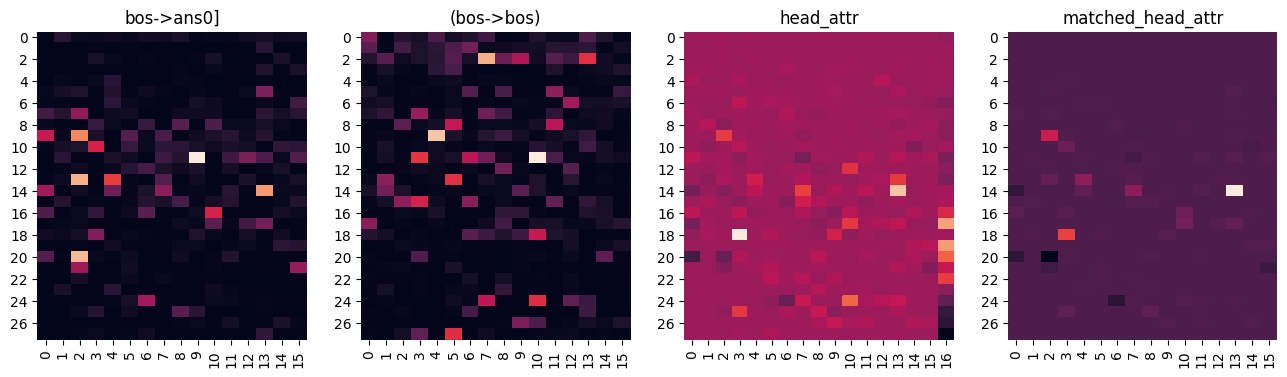

(array([11, 20, 13, 14,  9, 13, 16, 10,  9, 24]),
 array([ 9,  2,  2, 13,  2,  4, 10,  3,  0,  6]),
 array([0.7173778 , 0.62229055, 0.60946083, 0.5676346 , 0.5405595 ,
       0.4272213 , 0.3783817 , 0.37701195, 0.35255486, 0.2867906 ],
      dtype=float32))
(array([11,  9,  2, 11, 13,  2, 27, 24, 15, 18]),
 array([10,  4,  7,  3,  5, 13,  5, 10,  3, 10]),
 array([0.63188285, 0.5689126 , 0.537788  , 0.36494154, 0.35878387,
       0.35563633, 0.3544225 , 0.35329795, 0.33209577, 0.31022847],
      dtype=float32))
(array([18, 14, 17, 19, 24, 20, 14, 22,  9, 13]),
 array([ 3, 13, 16, 16, 10, 16,  7, 16,  2, 13]),
 array([1.3989127 , 1.1590506 , 0.970318  , 0.94025826, 0.6523284 ,
       0.645809  , 0.482685  , 0.46591493, 0.46152955, 0.456536  ],
      dtype=float32))
(array([14, 18,  9, 14, 13, 17, 16, 10, 13, 17]),
 array([13,  3,  2,  7,  4, 10, 10,  3,  2, 13]),
 array([0.6579172 , 0.32846457, 0.24948417, 0.12175848, 0.11974367,
       0.07340997, 0.05833574, 0.05461185, 0.04055051, 0.0

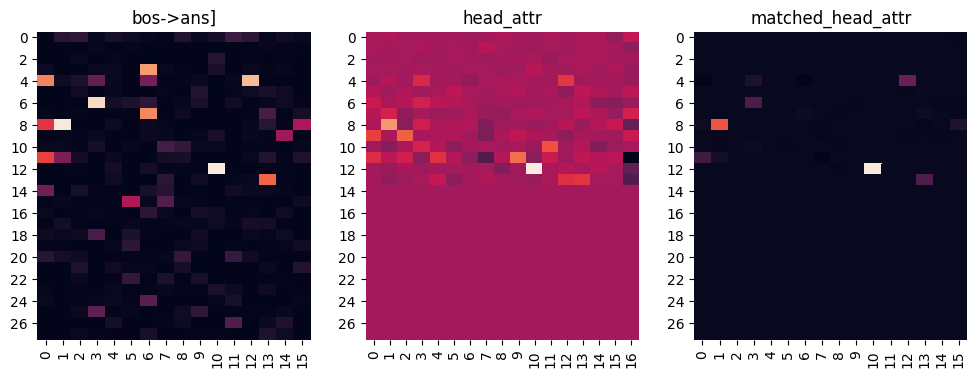

(array([12,  8,  6,  4,  3,  7,  4, 13, 11,  8]),
 array([10,  1,  3, 12,  6,  6,  0, 13,  0,  0]),
 array([0.16048846, 0.15940726, 0.15324947, 0.1406589 , 0.12815823,
       0.12056184, 0.11915901, 0.10840698, 0.09679079, 0.09179509],
      dtype=float32))
(array([12,  8, 11,  9, 10,  9,  4, 13, 11, 13]),
 array([10,  1,  9,  2, 11,  0, 12, 13,  4, 12]),
 array([0.9664568 , 0.6192701 , 0.4737751 , 0.42317867, 0.37544838,
       0.31359145, 0.2809426 , 0.26658827, 0.261666  , 0.25007516],
      dtype=float32))
(array([12,  8,  4, 13,  6, 11,  8,  4, 11,  8]),
 array([10,  1, 12, 13,  3,  0, 15,  3,  1,  0]),
 array([0.15510516, 0.09871615, 0.03951707, 0.02890003, 0.02883292,
       0.022912  , 0.00921812, 0.00906063, 0.00487012, 0.00275837],
      dtype=float32))
[1] top[0, 1] 12-10,8-1


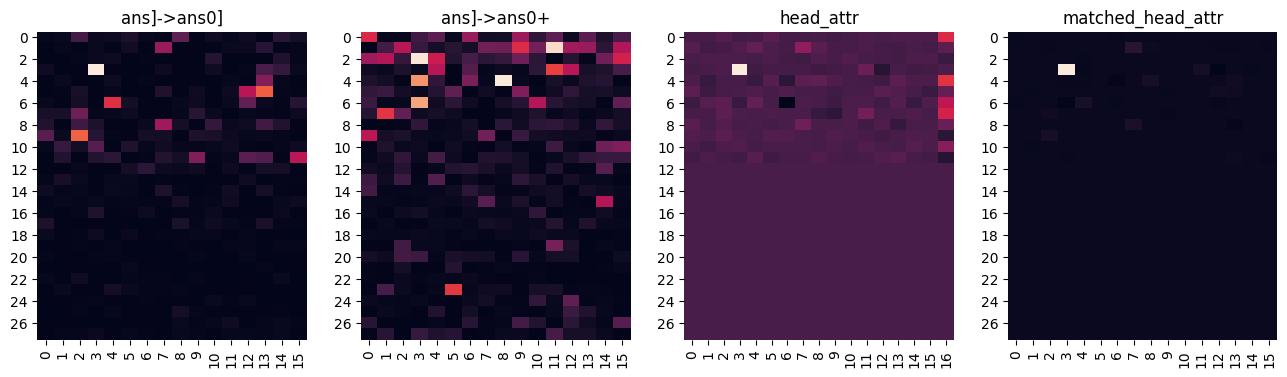

(array([ 3,  9,  5,  6, 11,  5,  8,  1,  4, 11]),
 array([ 3,  2, 13,  4, 15, 12,  7,  7, 13,  9]),
 array([0.6620156 , 0.44324428, 0.43961623, 0.3727328 , 0.30854177,
       0.30357894, 0.2605817 , 0.25120595, 0.22188963, 0.21436056],
      dtype=float32))
(array([ 4,  2,  1,  6,  4,  3, 23,  7,  1,  0]),
 array([ 8,  3, 11,  3,  3, 11,  5,  1,  9,  0]),
 array([0.36325628, 0.35785317, 0.34903136, 0.2982752 , 0.28310683,
       0.21791817, 0.21177848, 0.20994674, 0.20103587, 0.19604373],
      dtype=float32))
(array([ 3,  4,  0,  7,  6,  1, 10,  7,  8,  3]),
 array([ 3, 16, 16, 16, 16,  7, 16, 11,  7, 11]),
 array([1.5589175 , 0.7360353 , 0.68754756, 0.64275676, 0.5367663 ,
       0.32150304, 0.2787937 , 0.1829922 , 0.1722066 , 0.1546406 ],
      dtype=float32))
(array([3, 1, 8, 6, 4, 9, 3, 5, 4, 7]),
 array([ 3,  7,  7,  4,  8,  2, 11, 12, 13,  2]),
 array([1.0320277 , 0.08076347, 0.04487389, 0.0421843 , 0.03730841,
       0.03727487, 0.033699  , 0.02043558, 0.02028091, 0.01707414],


In [82]:
# 13-2 位置head
# prev 13-9 ov head 3-12 qkhead
# next 14-13 ,13-4 ov head  3-3 qkhead

# 16-7 head看一下归因结果。
key = 'MlM_gen(persons.EqSet.equal, get_posets.PoSet.next) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [718]:
def plot_attn_attrs(data_tuples, model, tokenizer, node, topi = [0]):
    for l, h in zip(*np.array(topk_md(get_head_mlp_attr(node.data), 10)[:2])[:, topi]):
        print(l, h)
        for data_tuple in data_tuples:
            plot_attn_attr(data_tuple, model, tokenizer, node, l ,h ,k_shot = k_shot, attn_patterns= attn_patterns_by_step[node.data.step])

24 10
tensor([-9.3535, -1.3229, -2.1887, -3.1855])
*ĠD 0.493 {'ĠD': 0.493, 'ĠE': 0.469, 'ĠZ': 0.037, 'ĠG': 0.0} 	 Zebra is labeled D. Dog is labeled H. Zebra is labeled D
 ĠH 0.069 {'ĠD': 0.527, 'ĠC': 0.26, 'ĠA': 0.126, 'ĠH': 0.069} 	 Cherry is labeled A. Blackberry is labeled H. Blackberry is labeled H
*ĠE 1.0 {'ĠE': 1.0, 'ĠG': 0.0, 'ĠD': 0.0, 'E': 0.0} 	 Goose is labeled E. Mango is labeled J. Goose is labeled E
 ĠL 0.048 {'ĠK': 0.684, 'ĠJ': 0.216, 'ĠL': 0.048, 'ĠG': 0.043} 	 Blackberry is labeled N. Wine is labeled L. Wine is labeled L
 ĠK 0.0 {'ĠE': 1.0, 'ĠK': 0.0, 'E': 0.0, 'ĠG': 0.0} 	 Mouse is labeled D. Goose is labeled K. Goose is labeled K
*ĠL 1.0 {'ĠL': 1.0, 'L': 0.0, 'ĠM': 0.0, 'ĠK': 0.0} 	 Coffee is labeled L. Steak is labeled M. Coffee is labeled L
*ĠH 1.0 {'ĠH': 1.0, 'ĠL': 0.0, 'ĠE': 0.0, 'ĠG': 0.0} 	 Burger is labeled E. Hamburger is labeled H. Hamburger is labeled H
*ĠG 1.0 {'ĠG': 1.0, 'ĠK': 0.0, 'G': 0.0, 'ĠJ': 0.0} 	 Shotgun is labeled G. Wine is labeled K. Shotgun i

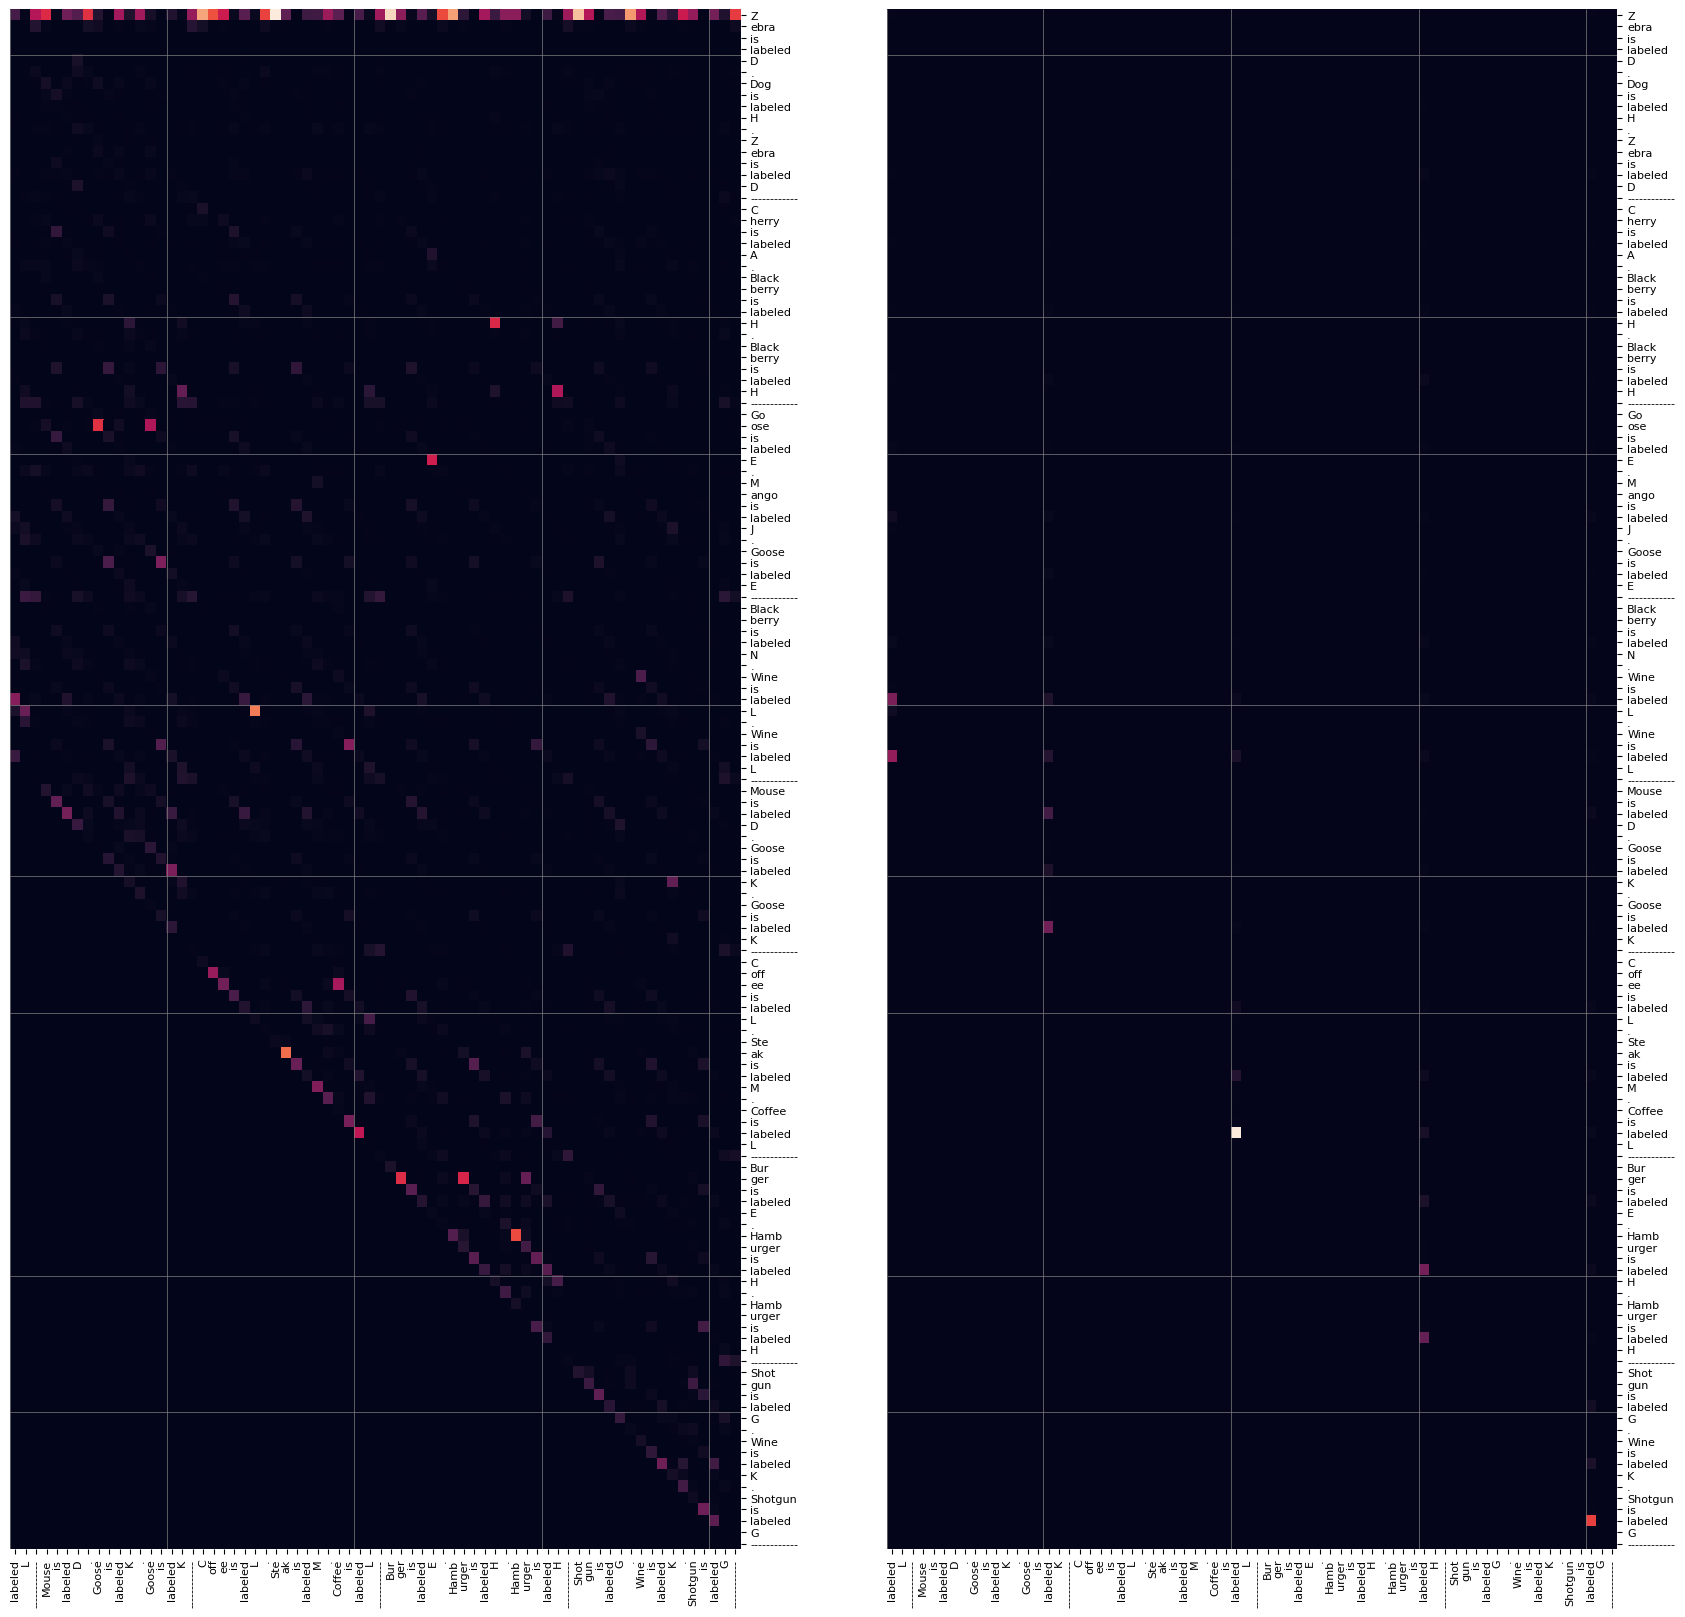

15 7
tensor([-9.4599e+00, -1.2564e-01, -2.5555e-02, -6.6869e-03])
*ĠD 1.0 {'ĠD': 1.0, 'D': 0.0, 'ĠH': 0.0, 'Ds': 0.0} 	 Zebra is labeled D. Dog is labeled H. Zebra is labeled D
*ĠH 0.995 {'ĠH': 0.995, 'ĠA': 0.003, 'H': 0.002, 'A': 0.0} 	 Cherry is labeled A. Blackberry is labeled H. Blackberry is labeled H
*ĠE 1.0 {'ĠE': 1.0, 'E': 0.0, 'ĠA': 0.0, 'ĠD': 0.0} 	 Goose is labeled E. Mango is labeled J. Goose is labeled E
*ĠL 0.999 {'ĠL': 0.999, 'L': 0.001, 'ĠN': 0.0, 'ĠJ': 0.0} 	 Blackberry is labeled N. Wine is labeled L. Wine is labeled L
*ĠK 0.969 {'ĠK': 0.969, 'K': 0.031, 'KI': 0.0, 'ĠKM': 0.0} 	 Mouse is labeled D. Goose is labeled K. Goose is labeled K
*ĠL 1.0 {'ĠL': 1.0, 'L': 0.0, 'ĠLX': 0.0, 'ĠLl': 0.0} 	 Coffee is labeled L. Steak is labeled M. Coffee is labeled L
*ĠH 0.999 {'ĠH': 0.999, 'H': 0.001, 'HS': 0.0, 'ĠHS': 0.0} 	 Burger is labeled E. Hamburger is labeled H. Hamburger is labeled H
*ĠG 1.0 {'ĠG': 1.0, 'G': 0.0, 'Gs': 0.0, 'ĠH': 0.0} 	 Shotgun is labeled G. Wine is labeled

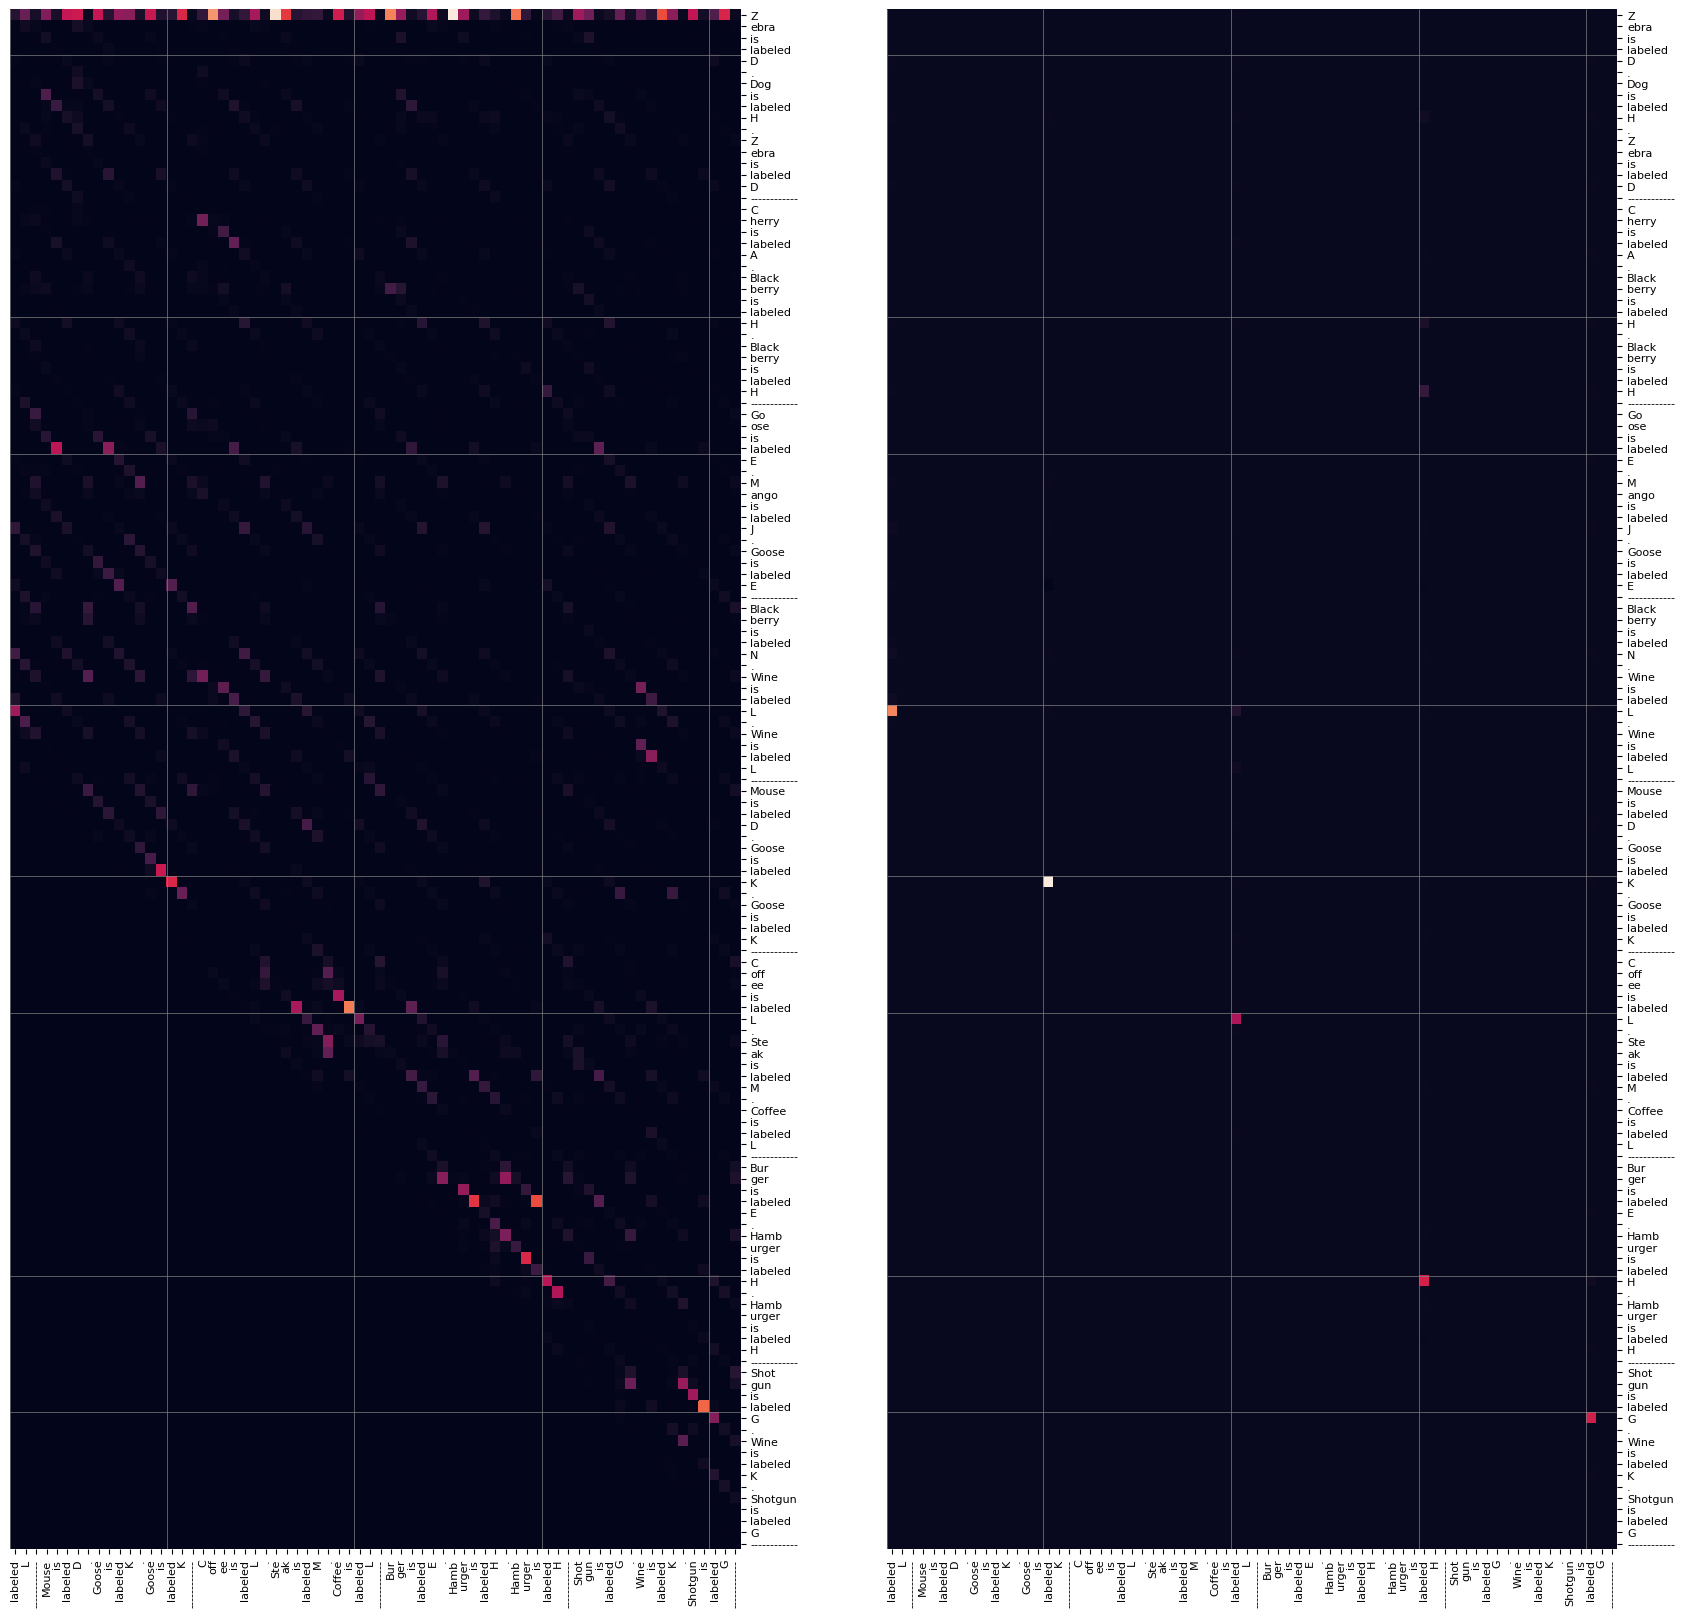

14 6
tensor([-9.3990, -0.4579, -0.0580, -0.0156])
 ĠD 0.0 {'ĠH': 0.998, 'H': 0.002, 'HS': 0.0, 'Ġhydrogen': 0.0} 	 Zebra is labeled D. Dog is labeled H. Zebra is labeled D
 ĠH 0.0 {'ĠA': 0.222, 'A': 0.156, 'Ġan': 0.021, 'ãĤ¢': 0.008} 	 Cherry is labeled A. Blackberry is labeled H. Blackberry is labeled H
*ĠE 0.923 {'ĠE': 0.923, 'E': 0.063, 'Ġan': 0.003, 'wyn': 0.0} 	 Goose is labeled E. Mango is labeled J. Goose is labeled E
*ĠL 0.988 {'ĠL': 0.988, 'L': 0.012, 'Ġl': 0.0, 'LC': 0.0} 	 Blackberry is labeled N. Wine is labeled L. Wine is labeled L
*ĠK 0.975 {'ĠK': 0.975, 'K': 0.025, 'Ġk': 0.0, 'k': 0.0} 	 Mouse is labeled D. Goose is labeled K. Goose is labeled K
*ĠL 0.991 {'ĠL': 0.991, 'L': 0.009, 'Ġl': 0.0, 'ĠLon': 0.0} 	 Coffee is labeled L. Steak is labeled M. Coffee is labeled L
*ĠH 0.999 {'ĠH': 0.999, 'H': 0.001, 'Ġh': 0.0, 'HS': 0.0} 	 Burger is labeled E. Hamburger is labeled H. Hamburger is labeled H
*ĠG 0.971 {'ĠG': 0.971, 'G': 0.029, 'Ġg': 0.0, 'Gs': 0.0} 	 Shotgun is labeled G

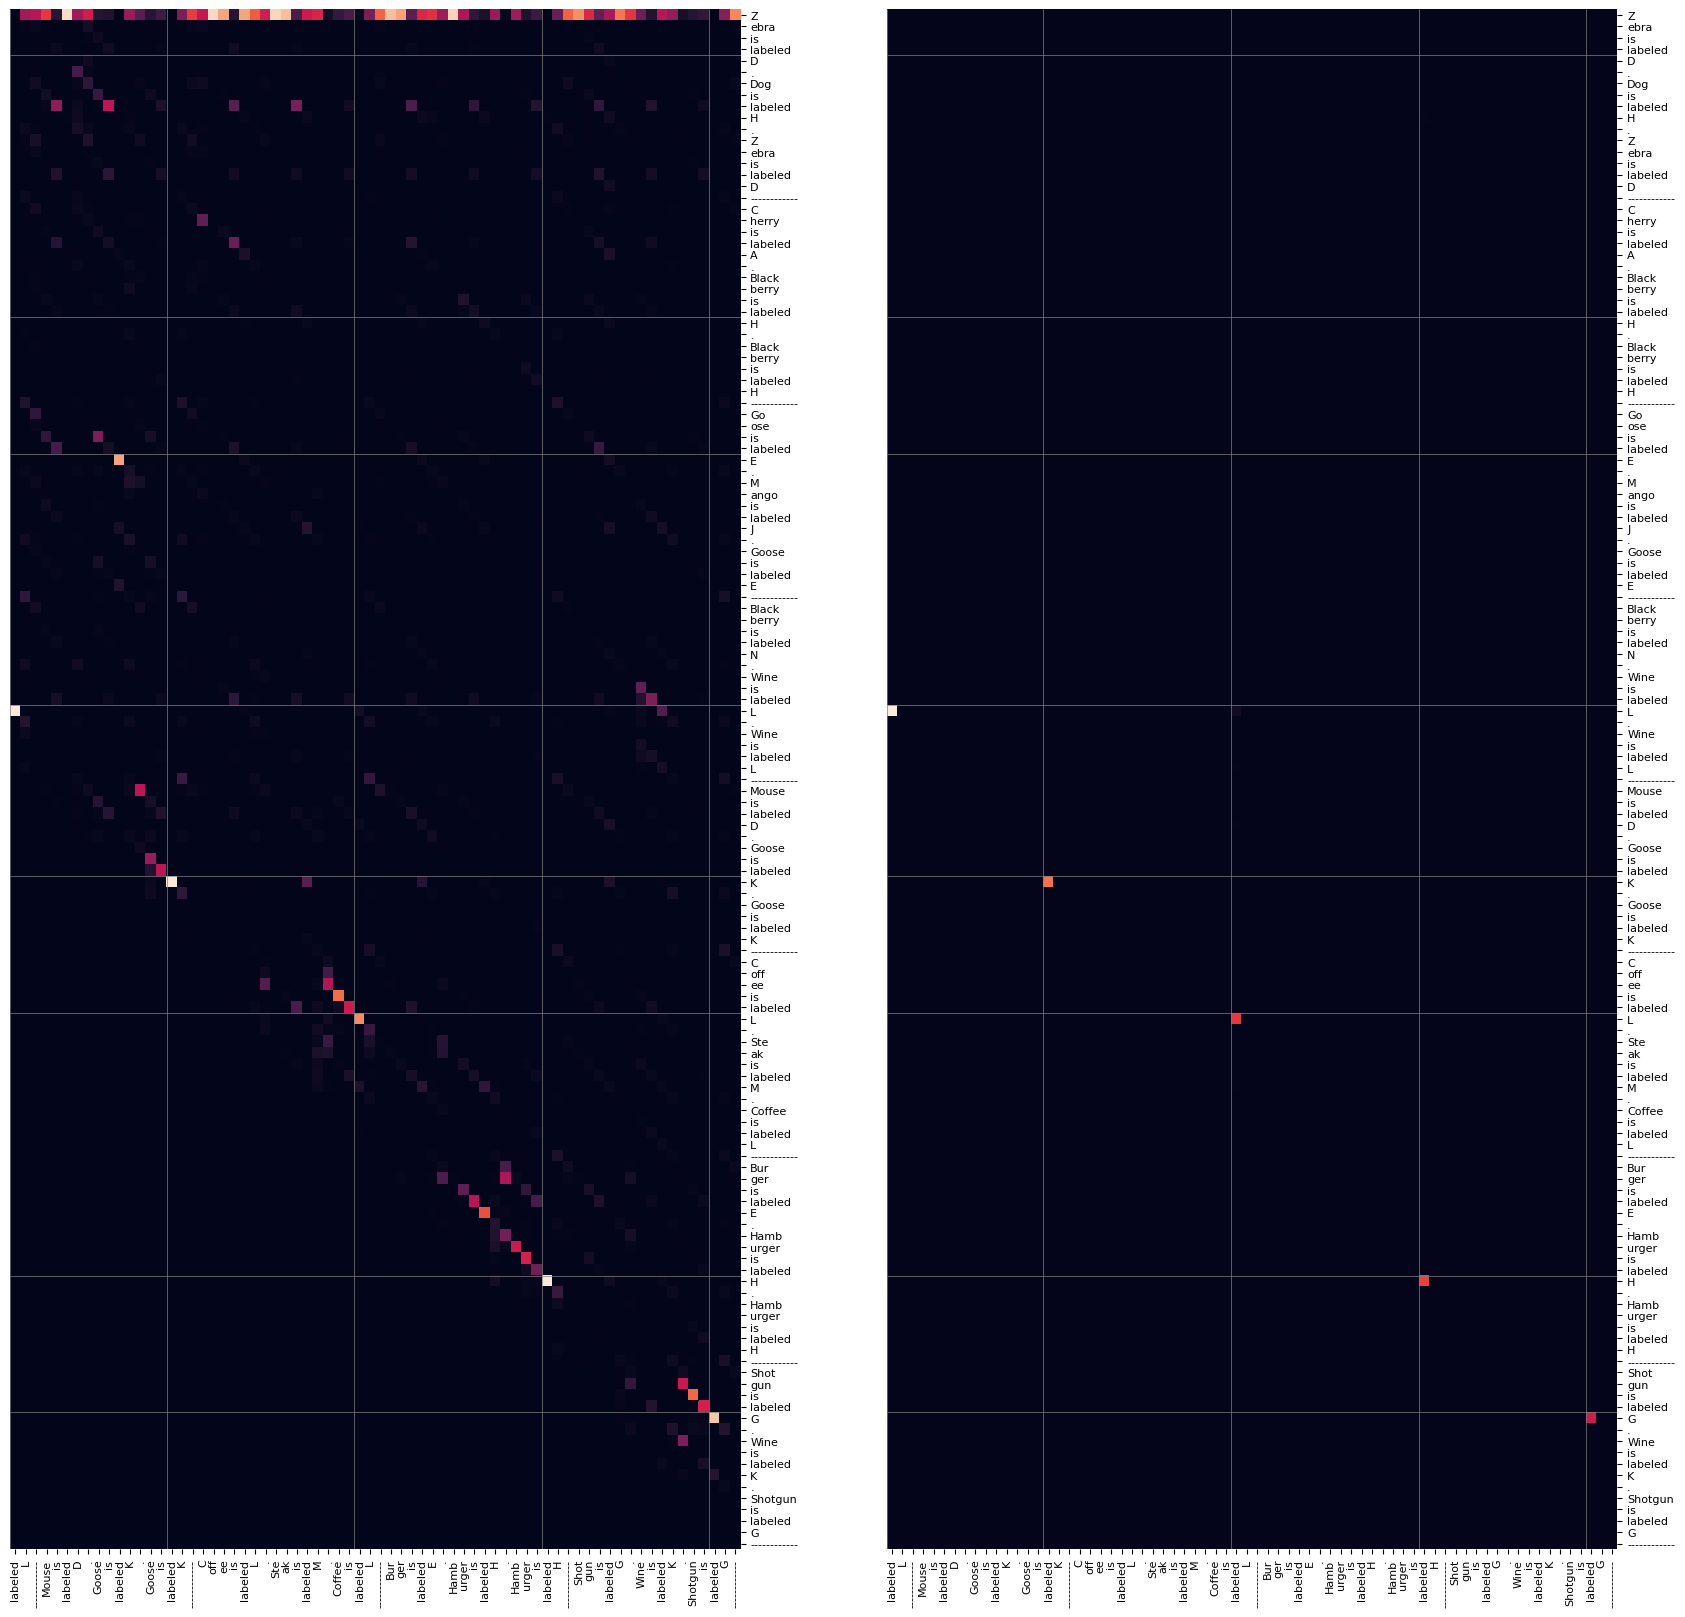

20 16
tensor([-7.3274, -7.8685, -4.1273, -3.1684])
 ĠD 0.005 {'ĠE': 0.523, 'ĠJ': 0.295, 'ĠF': 0.082, 'ĠG': 0.016} 	 Zebra is labeled D. Dog is labeled H. Zebra is labeled D
 ĠH 0.014 {'ĠE': 0.55, 'ĠL': 0.127, 'ĠR': 0.072, 'ĠJ': 0.058} 	 Cherry is labeled A. Blackberry is labeled H. Blackberry is labeled H
*ĠE 0.983 {'ĠE': 0.983, 'E': 0.017, 'Ġe': 0.001, 'ĠD': 0.0} 	 Goose is labeled E. Mango is labeled J. Goose is labeled E
 ĠL 0.142 {'ĠJ': 0.227, 'ĠE': 0.192, 'ĠL': 0.142, 'ĠM': 0.066} 	 Blackberry is labeled N. Wine is labeled L. Wine is labeled L
 ĠK 0.001 {'ĠE': 0.921, 'ĠJ': 0.027, 'ĠB': 0.009, 'ĠG': 0.008} 	 Mouse is labeled D. Goose is labeled K. Goose is labeled K
 ĠL 0.208 {'ĠE': 0.383, 'ĠL': 0.208, 'ĠM': 0.058, 'ĠG': 0.049} 	 Coffee is labeled L. Steak is labeled M. Coffee is labeled L
 ĠH 0.065 {'ĠA': 0.258, 'ĠJ': 0.184, 'ĠF': 0.123, 'ĠE': 0.079} 	 Burger is labeled E. Hamburger is labeled H. Hamburger is labeled H
 ĠG 0.049 {'ĠJ': 0.249, 'ĠE': 0.183, 'ĠF': 0.113, 'ĠA': 0.087}

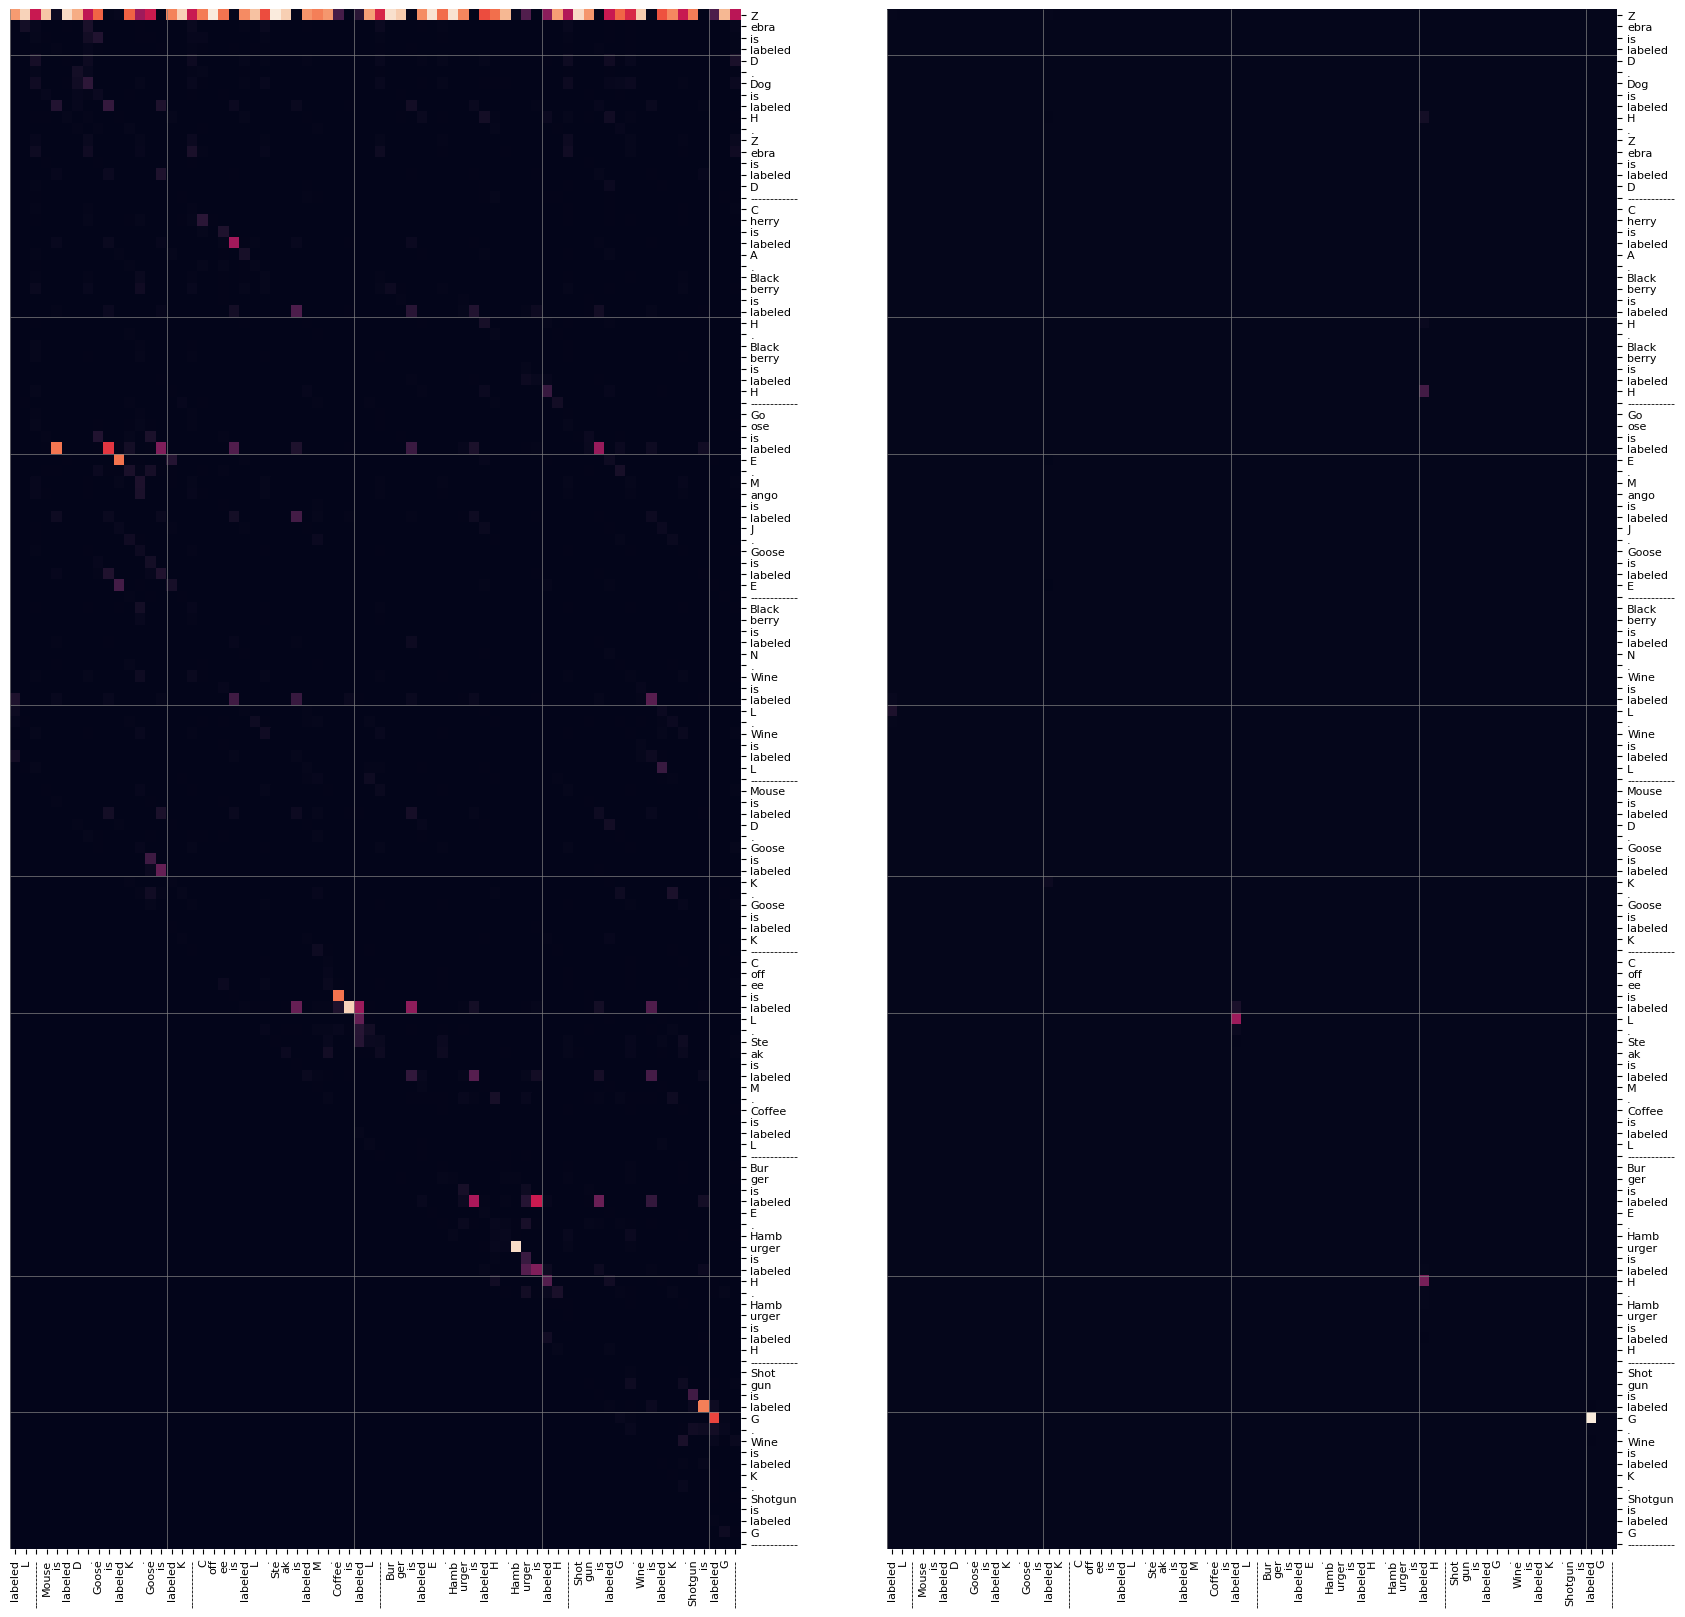

In [1075]:
plot_attn_attrs(data_tuples[:1], model, tokenizer, node, topi=[0,1,2,3,4])

In [548]:
from model_utils import get_head_mlp_attr

In [494]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0,1])

AssertionError: 0

In [57]:
def add_node(parent, layer=None, head=None, topi=None, head_attr_fn=None, label_type=None, attribute_k=False, verbose=True):
    if label_type: assert label_type in ['labels', 'argmax_labels'] or 'attn_labels' in label_type, label_type
    if parent is None:
        si = -1; node = Node('[-1] root ' + label_type)
        node.data = AttrData(step=si, label_type=label_type)
    else:
        if parent is not None and parent.data.attr is None:
            print('parent has not been attributed yet, replace it instead of adding to it.')
            _id = id(parent); parent = parent.parent
            parent.children = [child for child in parent.children if id(child) != _id]
        if layer is None or topi is not None:
            if head_attr_fn is None: head_attr_fn = get_matched_head_attr
            head_attr = head_attr_fn(parent.data)
            layer, head = topk_md(head_attr, 10, transpose=True)[topi][:2] if type(topi) == int \
                else np.array(topk_md(head_attr, 10)[:2])[:, topi] # list
        si = parent.data.step
        if si == -1: assert label_type is not None
#         else: label_type = None
        data = AttrData(step=si + 1, topi=topi, layer=layer, head=head, label_type=label_type, 
            attribute_k=label_type in ['argmax_attn_labels', 'attn_labels'] and attribute_k)
        node = Node(data2str(data), parent); node.data = data
    if verbose and parent is not None: plot_tree(node)
    return node

def add_node_to_result(result, node_name='node', label_type=None, **kwargs): # not very necessary, could be removed
    parent = getattr(result, node_name, None)
    node = add_node(parent, label_type = label_type, **kwargs)
    setattr(result, node_name, node)
    if 'root' in node.name: setattr(result, node_name.replace('node', 'root'), node)
    return node

In [ ]:
result = 

In [76]:
print(key); node = add_node_to_result(result, topi=[0],label_type = 'attn_labels')#,head_attr_fn = get_head_mlp_attr)

MlM_gen(persons.EqSet.equal, get_posets.PoSet.next) (cxt_len=1, abstract=0)
 [-1] root labels┐
                 └*[0] top[0] 14-13 attn_labels...


In [83]:
print(key); node = add_node_to_result(result, topi=[0])

MlM_gen(persons.EqSet.equal, get_posets.PoSet.next) (cxt_len=1, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 14-13 attn_labels┐
                                              └[1] top[0, 1] 12-10,8-1┐
                                                                      └*[2] top[0] 3-3...


13 9
tensor([-10.5808,  -7.4947,  -9.5948, -13.7304])
 Ġnoon 0.0 {'ĠJune': 0.033, 'Ġobserve': 0.025, 'Ġtook': 0.023, 'Changed': 0.019} 	 Allen arrived afternoon. Taylor arrived an evening. Allen arrived after noon
 Ġnoon 0.001 {'Ġ2011': 0.85, 'Ġmorning': 0.08, '2011': 0.017, 'Ġ2010': 0.013} 	 Jimmy arrived morning. Warren arrived afternoon. Warren arrived after noon
 ĠOctober 0.183 {'ĠOct': 0.206, 'ĠOctober': 0.183, 'ĠSeptember': 0.106, 'ĠAugust': 0.09} 	 Carter arrived a May. Ruby arrived November. Ruby arrived after October
 Ġ2014 0.112 {'2014': 0.883, 'Ġ2014': 0.112, '2013': 0.004, 'Ġ2013': 0.001} 	 Sky arrived 2011. Ocean arrived 2015. Ocean arrived after 2014
 Ġspring 0.0 {'Ġ2013': 0.763, '2013': 0.131, 'Ġfive': 0.014, 'Ġ2014': 0.013} 	 Roger arrived summer. June arrived winter. Roger arrived after spring
 Ġautumn 0.0 {'ĠAugust': 0.845, 'ĠAug': 0.065, 'ĠJuly': 0.054, 'August': 0.014} 	 Madison arrived winter. Martin arrived autumn. Madison arrived after autumn
 Ġdawn 0.0 {'Ġoverni

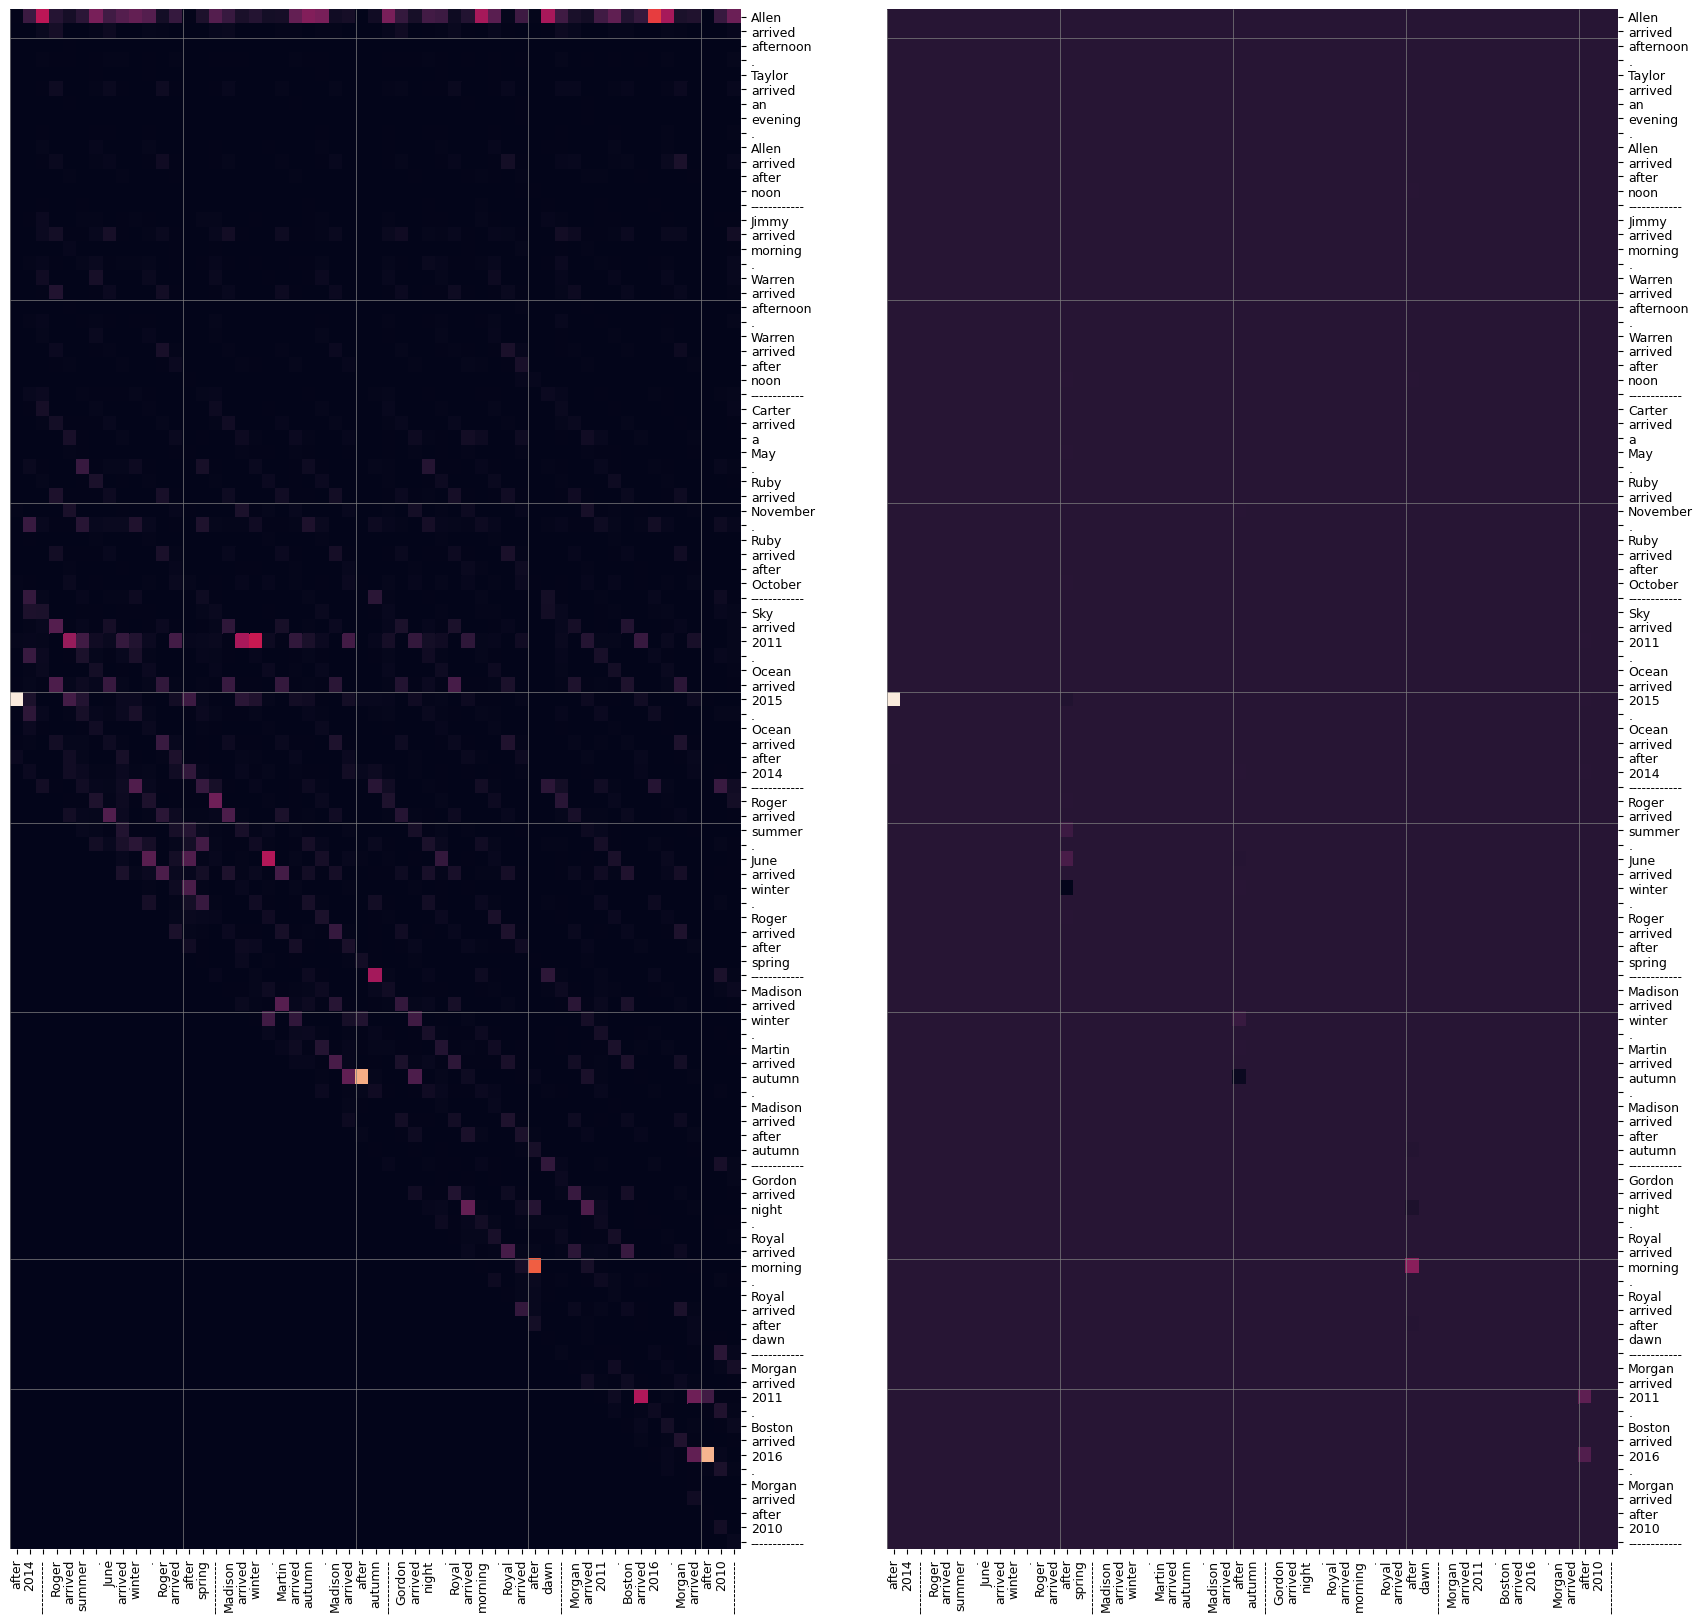

18 3
tensor([-10.4467,  -3.4565,  -5.0017,  -6.8873])
 Ġnoon 0.0 {'Ġafternoon': 0.692, 'Ġmorning': 0.159, 'Ġpost': 0.097, 'Ġevening': 0.05} 	 Allen arrived afternoon. Taylor arrived an evening. Allen arrived after noon
 Ġnoon 0.039 {'Ġafternoon': 0.928, 'Ġnoon': 0.039, 'Ġevening': 0.033, 'Ġmidday': 0.0} 	 Jimmy arrived morning. Warren arrived afternoon. Warren arrived after noon
 ĠOctober 0.123 {'ĠNovember': 0.553, 'ĠDecember': 0.148, 'ĠOctober': 0.123, 'ĠJanuary': 0.064} 	 Carter arrived a May. Ruby arrived November. Ruby arrived after October
 Ġ2014 0.039 {'Ġ2015': 0.618, 'Ġ2016': 0.148, 'Ġ2017': 0.145, 'Ġ2014': 0.039} 	 Sky arrived 2011. Ocean arrived 2015. Ocean arrived after 2014
 Ġspring 0.262 {'Ġautumn': 0.522, 'Ġspring': 0.262, 'Ġsummer': 0.205, 'Ġ2015': 0.003} 	 Roger arrived summer. June arrived winter. Roger arrived after spring
 Ġautumn 0.173 {'Ġspring': 0.721, 'Ġautumn': 0.173, 'Ġsummer': 0.105, 'Ġwinter': 0.001} 	 Madison arrived winter. Martin arrived autumn. Madison arr

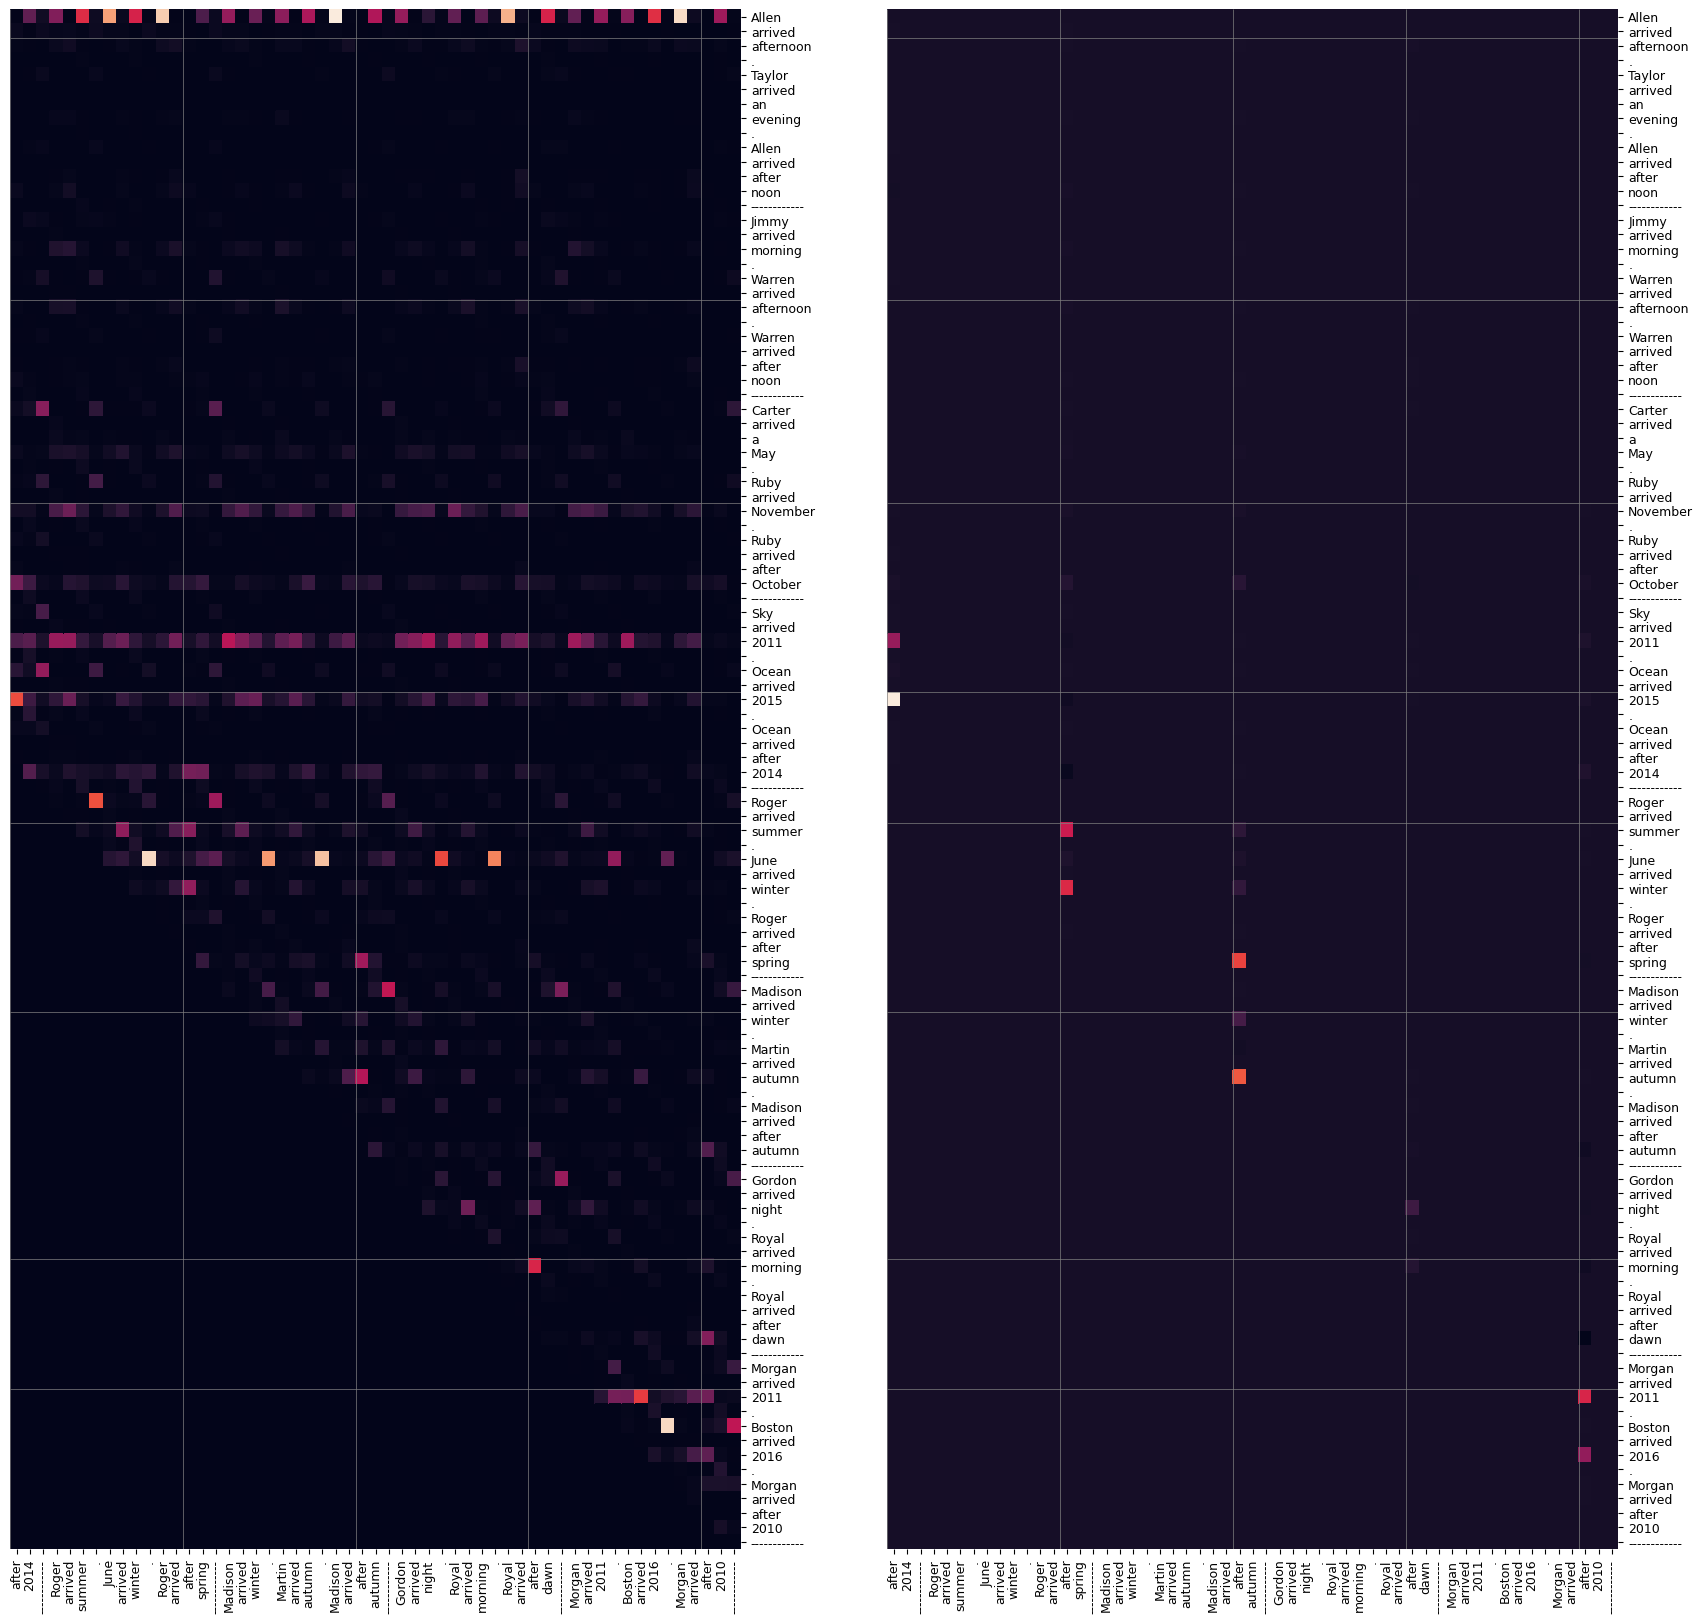

In [371]:
plot_attn_attrs(data_tuples[:1], model, tokenizer, node, topi=[0,1])

Rose has coffee. Rose's drink
Davis has a lemon. Davis's fruit
Georgia has grapes. Georgia's fruit
 [-1] root labels┐
                 └[0] top[0, 1] 20-5,19-14 attn_labels┐
                                                      └[1] top[0, 1] 8-1,12-10┐
                                                                              └*[2] top[0, 1] 3-12,5-12...
[-1] root labels


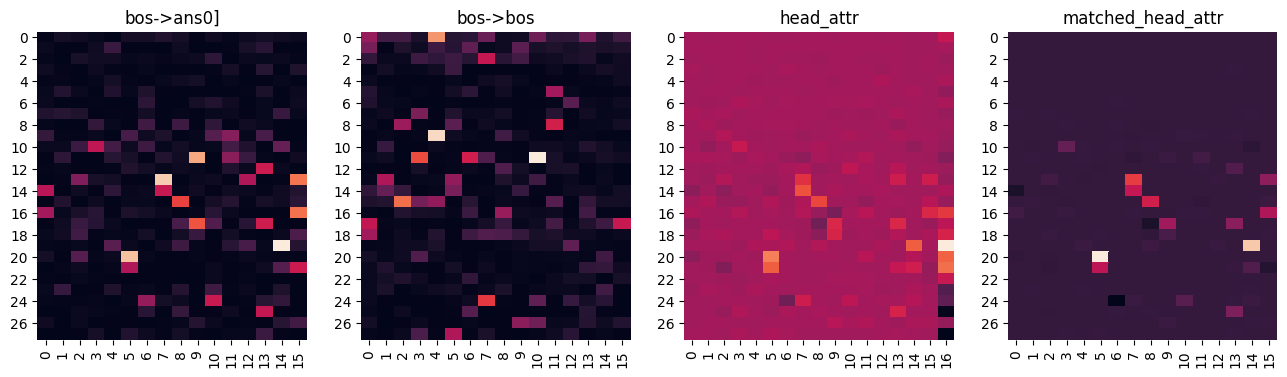

(array([19, 13, 20, 11, 13, 16, 17, 15, 17, 12]),
 array([14,  7,  5,  9, 15, 15,  9,  8, 13, 13]),
 array([0.6891602 , 0.6335116 , 0.612437  , 0.57339364, 0.49050012,
       0.48407248, 0.44306624, 0.41729143, 0.349726  , 0.345277  ],
      dtype=float32))
(array([11,  9,  0, 15, 11, 24,  8, 11, 17,  2]),
 array([10,  4,  4,  2,  3,  7, 11,  6, 15,  7]),
 array([0.7234116 , 0.6881152 , 0.5705039 , 0.5041336 , 0.4543685 ,
       0.42297977, 0.37406695, 0.37216586, 0.35455397, 0.35204566],
      dtype=float32))
(array([19, 20, 21, 20, 19, 21, 14, 15, 16, 13]),
 array([16,  5, 16, 16, 14,  5,  7,  8, 16,  7]),
 array([1.6395422 , 0.9005337 , 0.80862015, 0.7325212 , 0.71448296,
       0.70833296, 0.6476823 , 0.5843126 , 0.49481726, 0.45626652],
      dtype=float32))
(array([20, 19, 13, 15, 14, 21, 16, 17, 13, 17]),
 array([ 5, 14,  7,  8,  7,  5, 15,  9, 15, 13]),
 array([0.55152017, 0.49239326, 0.28905013, 0.24382865, 0.21917805,
       0.2103732 , 0.1883944 , 0.167466  , 0.14117828, 0.1

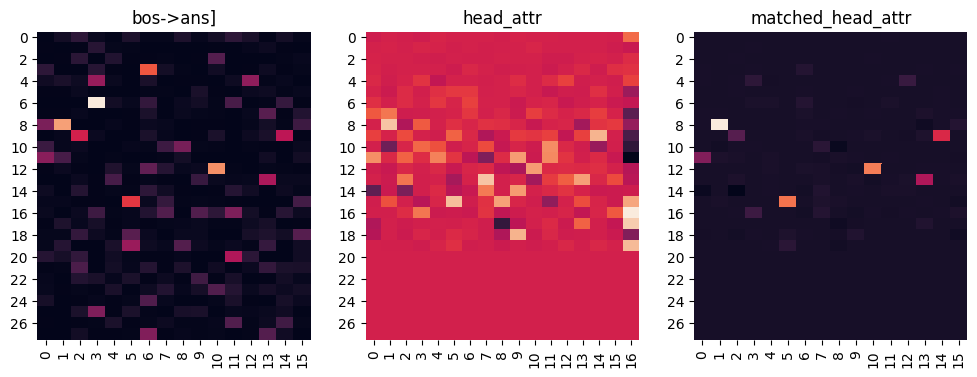

(array([ 6,  8, 12,  3, 15,  9,  9, 20, 13, 19]),
 array([ 3,  1, 10,  6,  5,  2, 14, 11, 13,  5]),
 array([0.15664487, 0.12619406, 0.12079316, 0.10126917, 0.09092639,
       0.08156618, 0.07292666, 0.06803505, 0.06614748, 0.0601534 ],
      dtype=float32))
(array([16, 17,  8, 13, 15, 19,  9, 18, 15, 15]),
 array([16, 16,  1,  7,  5, 16, 14,  9, 16,  8]),
 array([0.6030279 , 0.49593043, 0.47387573, 0.47003332, 0.45219892,
       0.44224706, 0.42094415, 0.41935447, 0.37787536, 0.36249405],
      dtype=float32))
(array([ 8, 12, 15,  9, 13, 11,  9, 16,  4,  4]),
 array([ 1, 10,  5, 14, 13,  0,  2,  3, 12,  3]),
 array([0.0598003 , 0.04247549, 0.04111682, 0.03069805, 0.02368322,
       0.01679227, 0.01034538, 0.00613313, 0.00575341, 0.00367124],
      dtype=float32))
[1] top[0, 1] 8-1,12-10


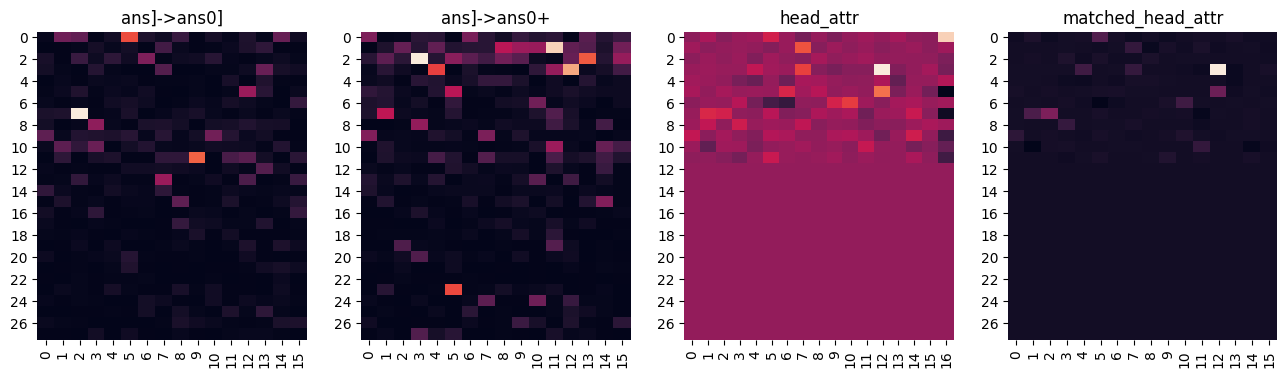

(array([ 7, 11,  0, 13,  5,  8,  2,  9,  0, 10]),
 array([ 2,  9,  5,  7, 12,  3,  6, 10,  1,  3]),
 array([0.6559124 , 0.43982732, 0.41146764, 0.25276473, 0.25159147,
       0.23333044, 0.20869951, 0.1909136 , 0.18702768, 0.17878911],
      dtype=float32))
(array([ 2,  1,  3,  2, 23,  3,  7,  5,  1,  1]),
 array([ 3, 11, 12, 13,  5,  4,  1,  5,  8,  9]),
 array([0.68246937, 0.63715464, 0.56330407, 0.44623885, 0.42225066,
       0.4093995 , 0.31993297, 0.31451845, 0.31330663, 0.26586223],
      dtype=float32))
(array([3, 0, 5, 1, 3, 6, 7, 5, 6, 7]),
 array([12, 16, 12,  7,  7, 10,  1,  6,  9,  2]),
 array([1.0670382 , 0.95344126, 0.564634  , 0.45852923, 0.39564627,
       0.37413836, 0.2893327 , 0.28214043, 0.26394278, 0.26044318],
      dtype=float32))
(array([ 3,  7,  5,  0,  7,  3,  6,  8,  3, 10]),
 array([12,  2, 12,  5,  1,  4, 10,  3,  7, 11]),
 array([0.60106695, 0.17082791, 0.1420571 , 0.10201551, 0.09256706,
       0.07400746, 0.07346611, 0.05758392, 0.05636753, 0.052529  ],


In [121]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [94]:
print(key); node = add_node_to_result(result, topi=[0,1])

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0)
 [-1] root labels┐
                 └[0] top[0, 1] 20-5,19-14 attn_labels┐
                                                      └[1] top[0, 1] 8-1,12-10┐
                                                                              └*[2] top[0, 1] 3-12,5-12...


3 12
tensor([-6.7919, -4.2307, -3.2806, -3.4824])


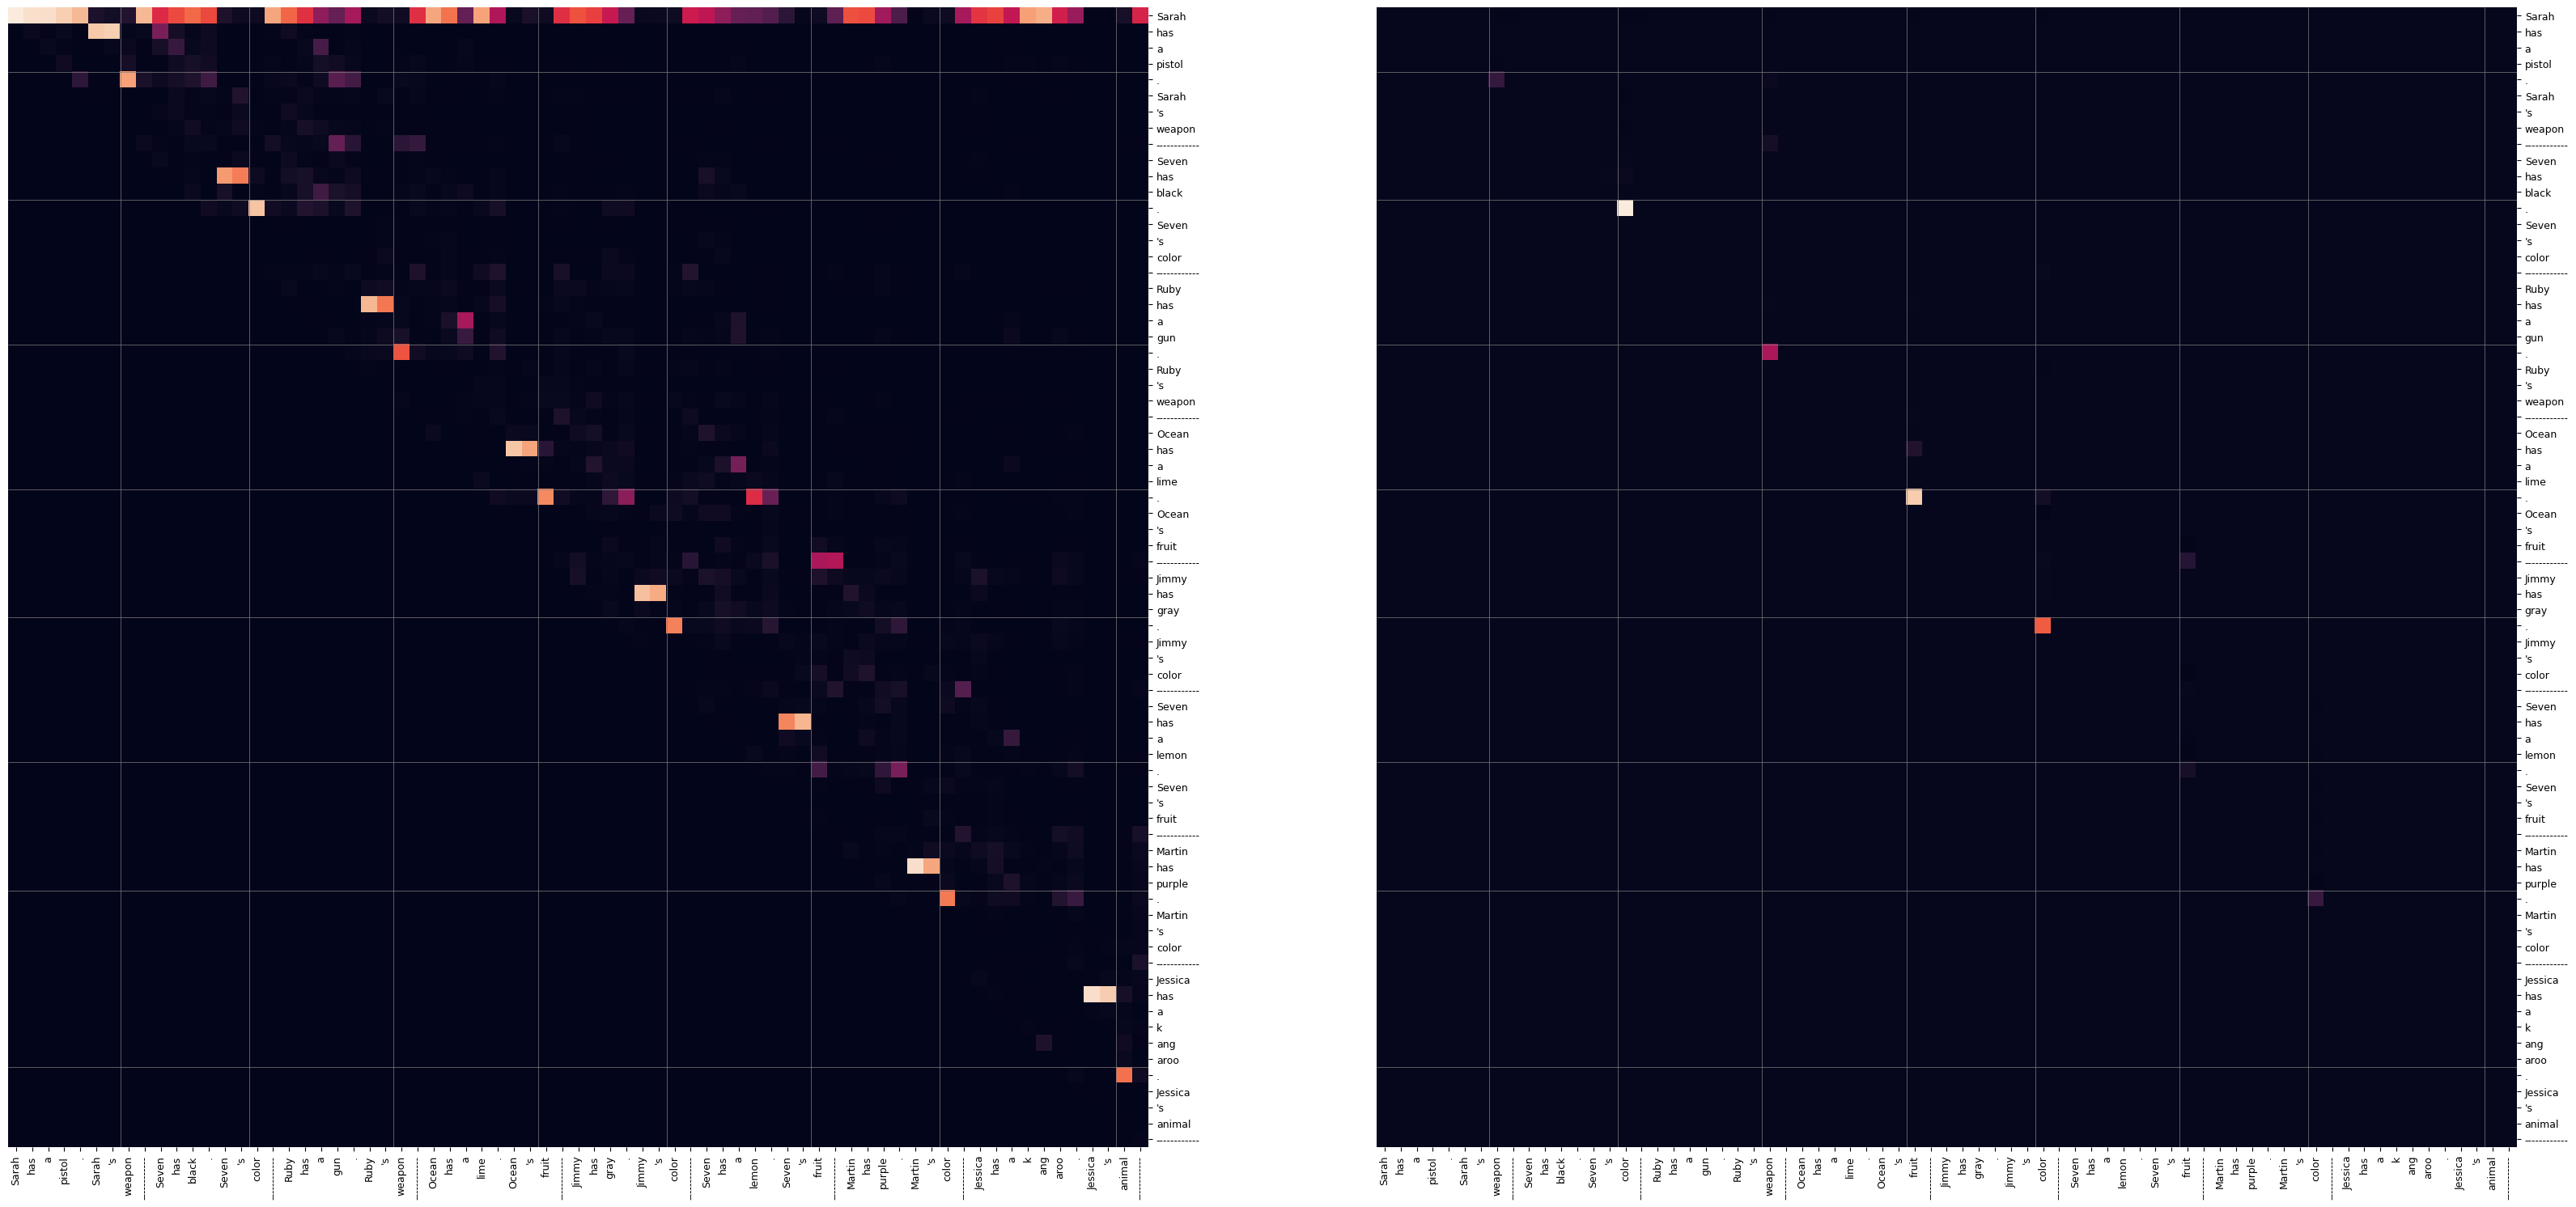

tensor([-6.3635, -4.0688, -2.8005, -2.3489])


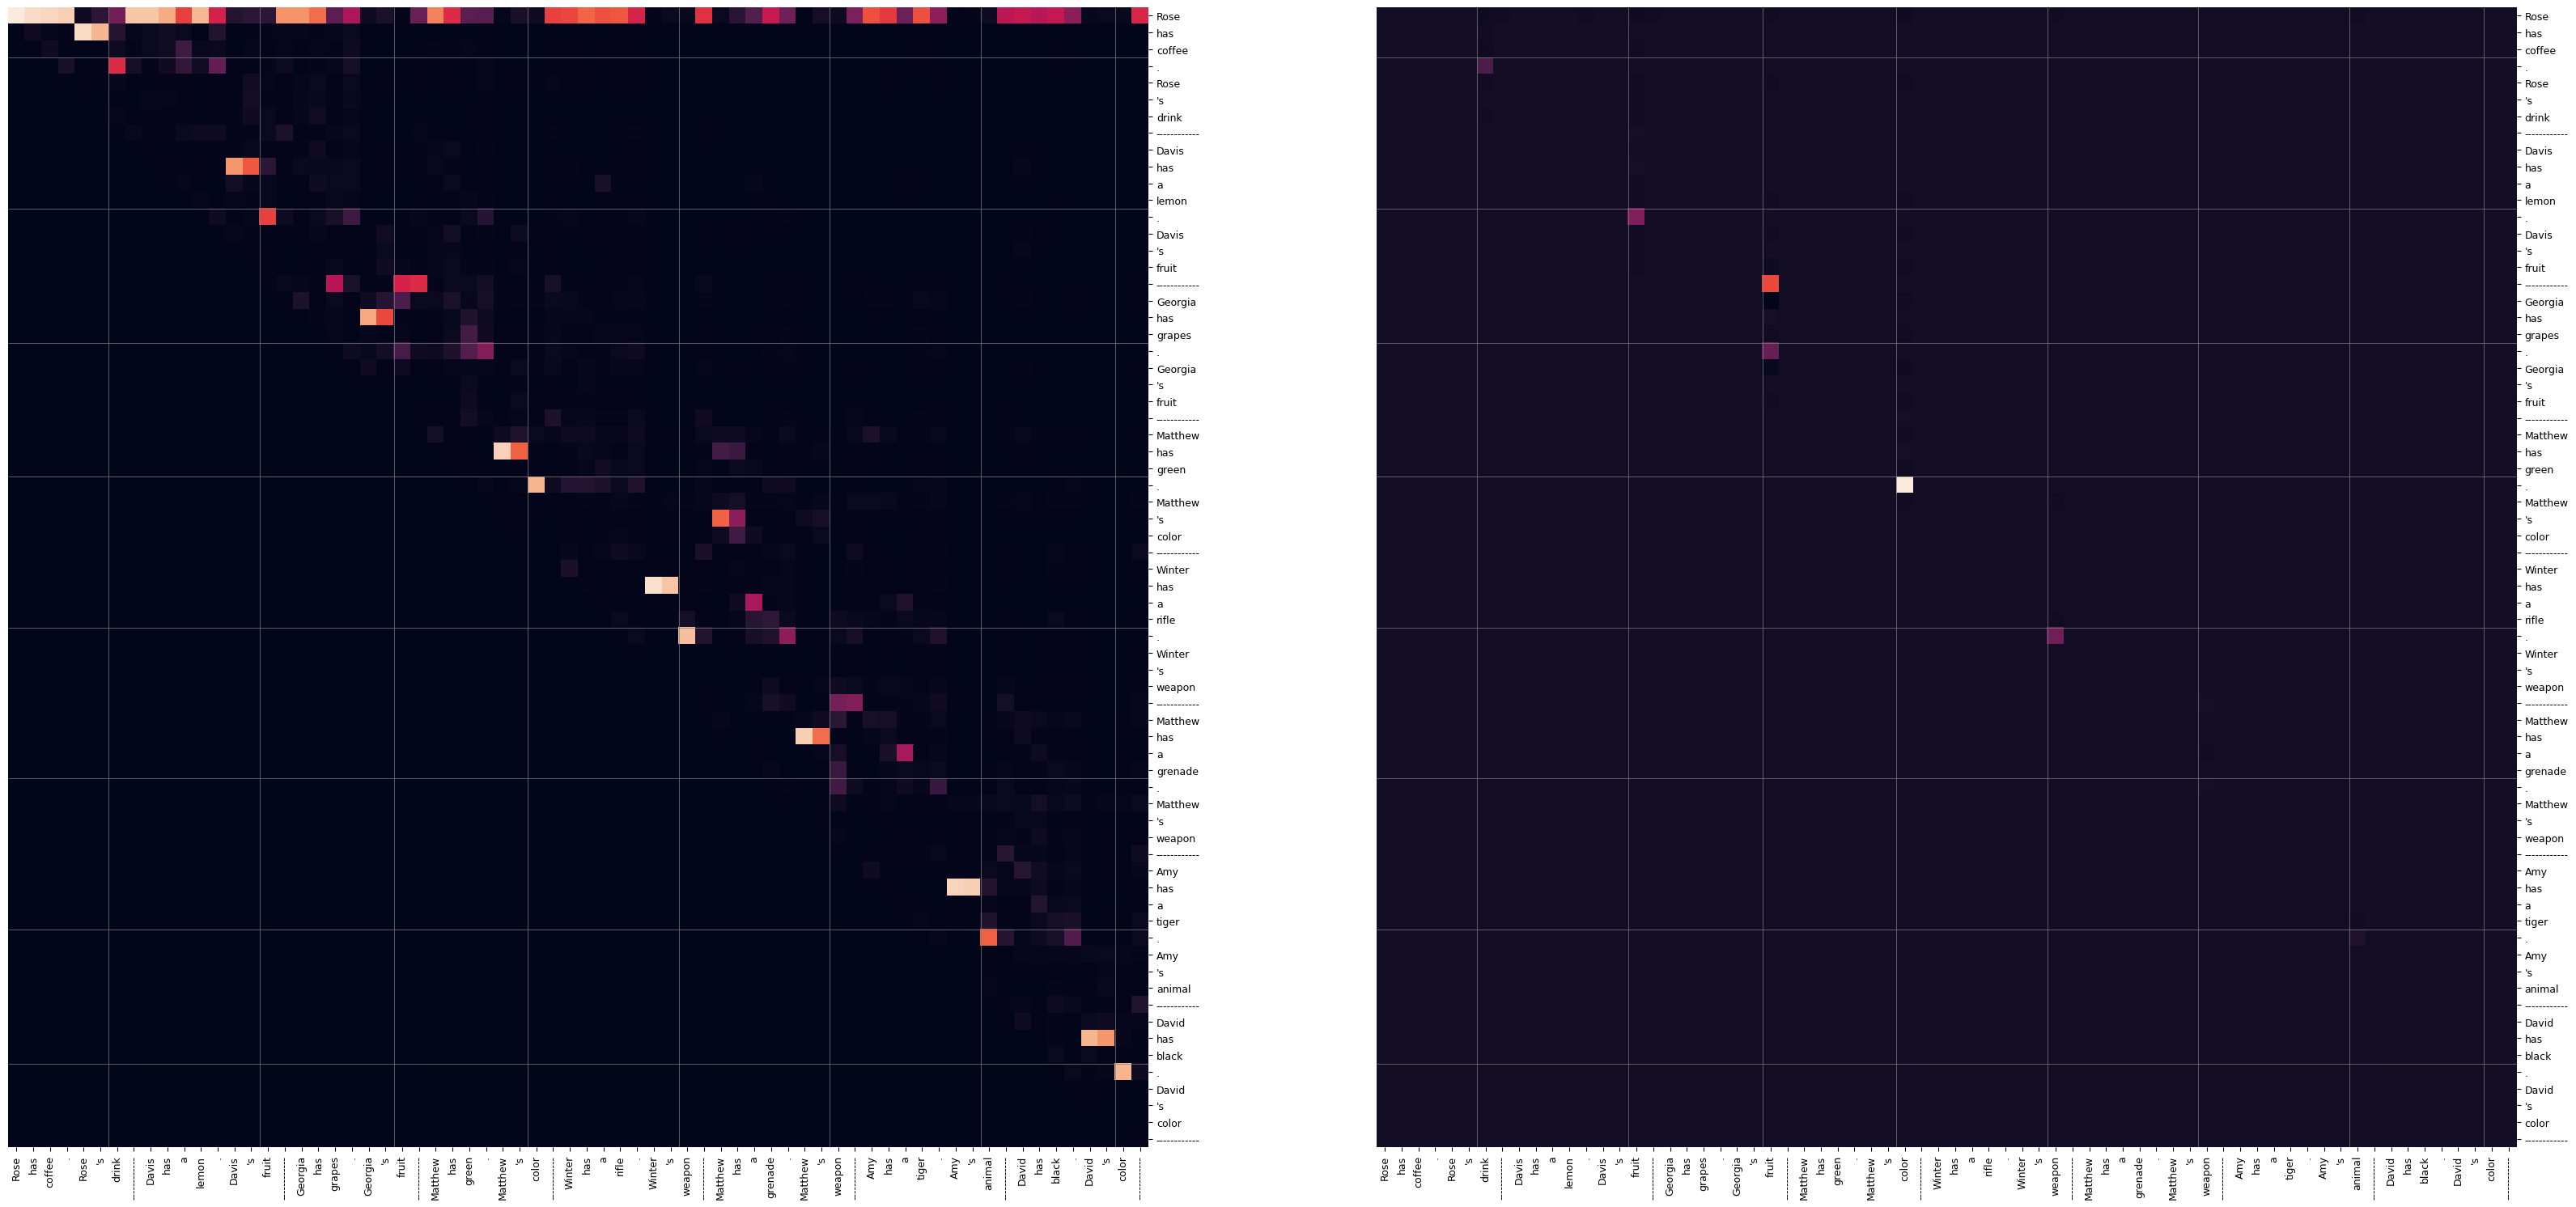

7 2
tensor([-6.4770, -6.0667, -6.1914, -6.7552])


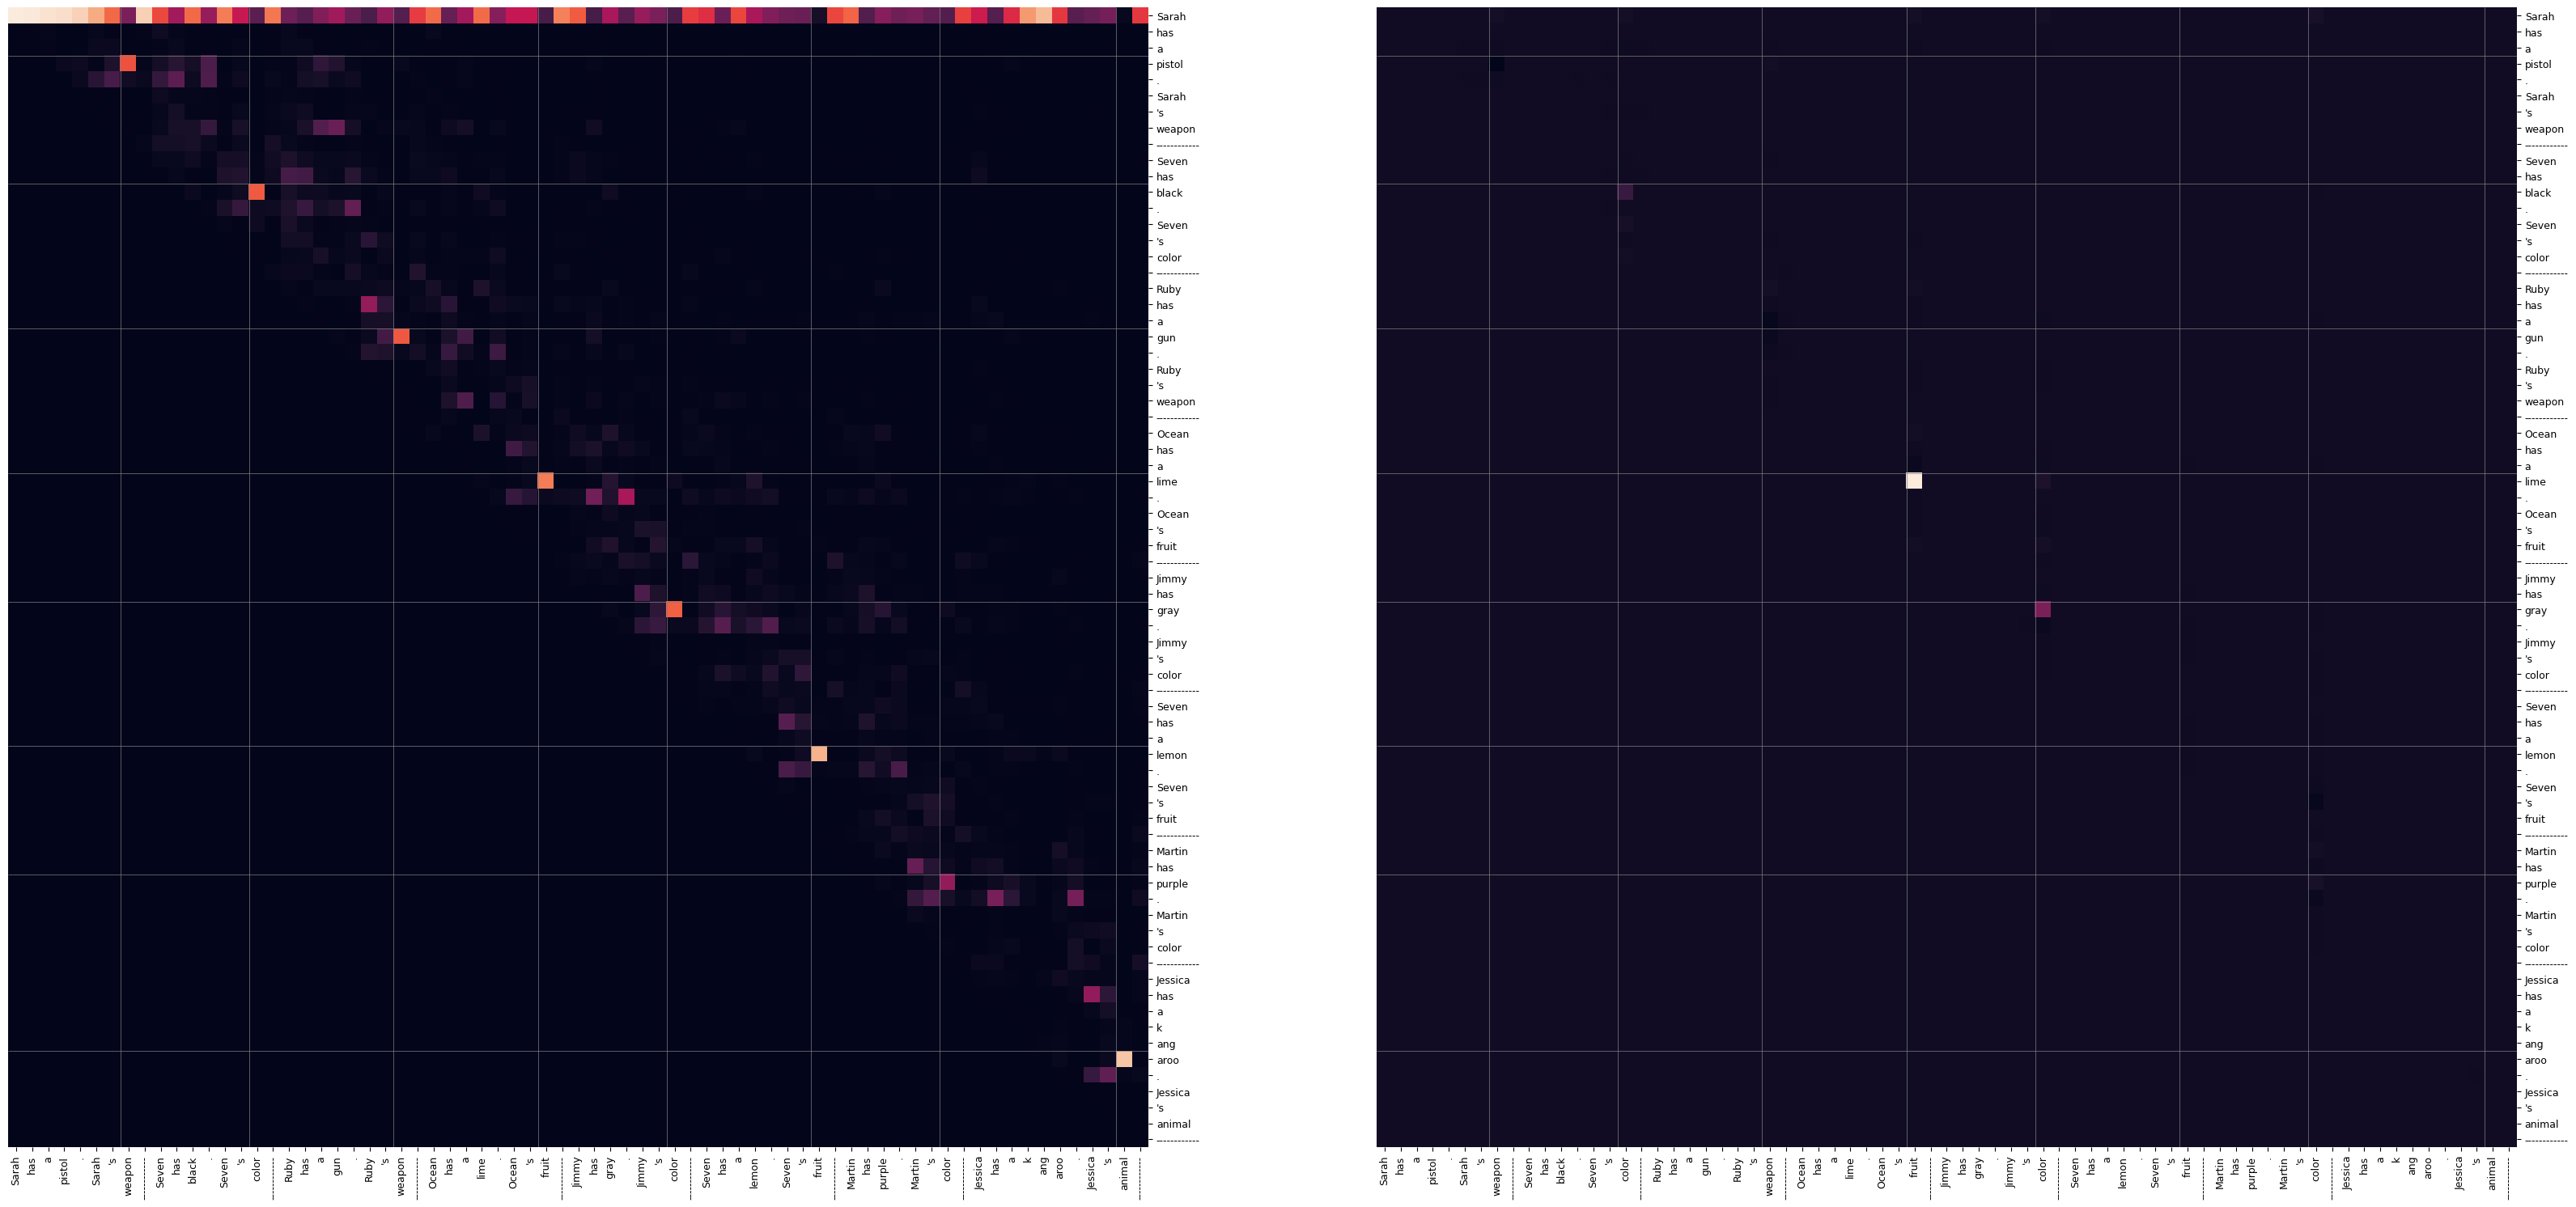

tensor([-6.0670, -5.3545, -5.2590, -5.5607])


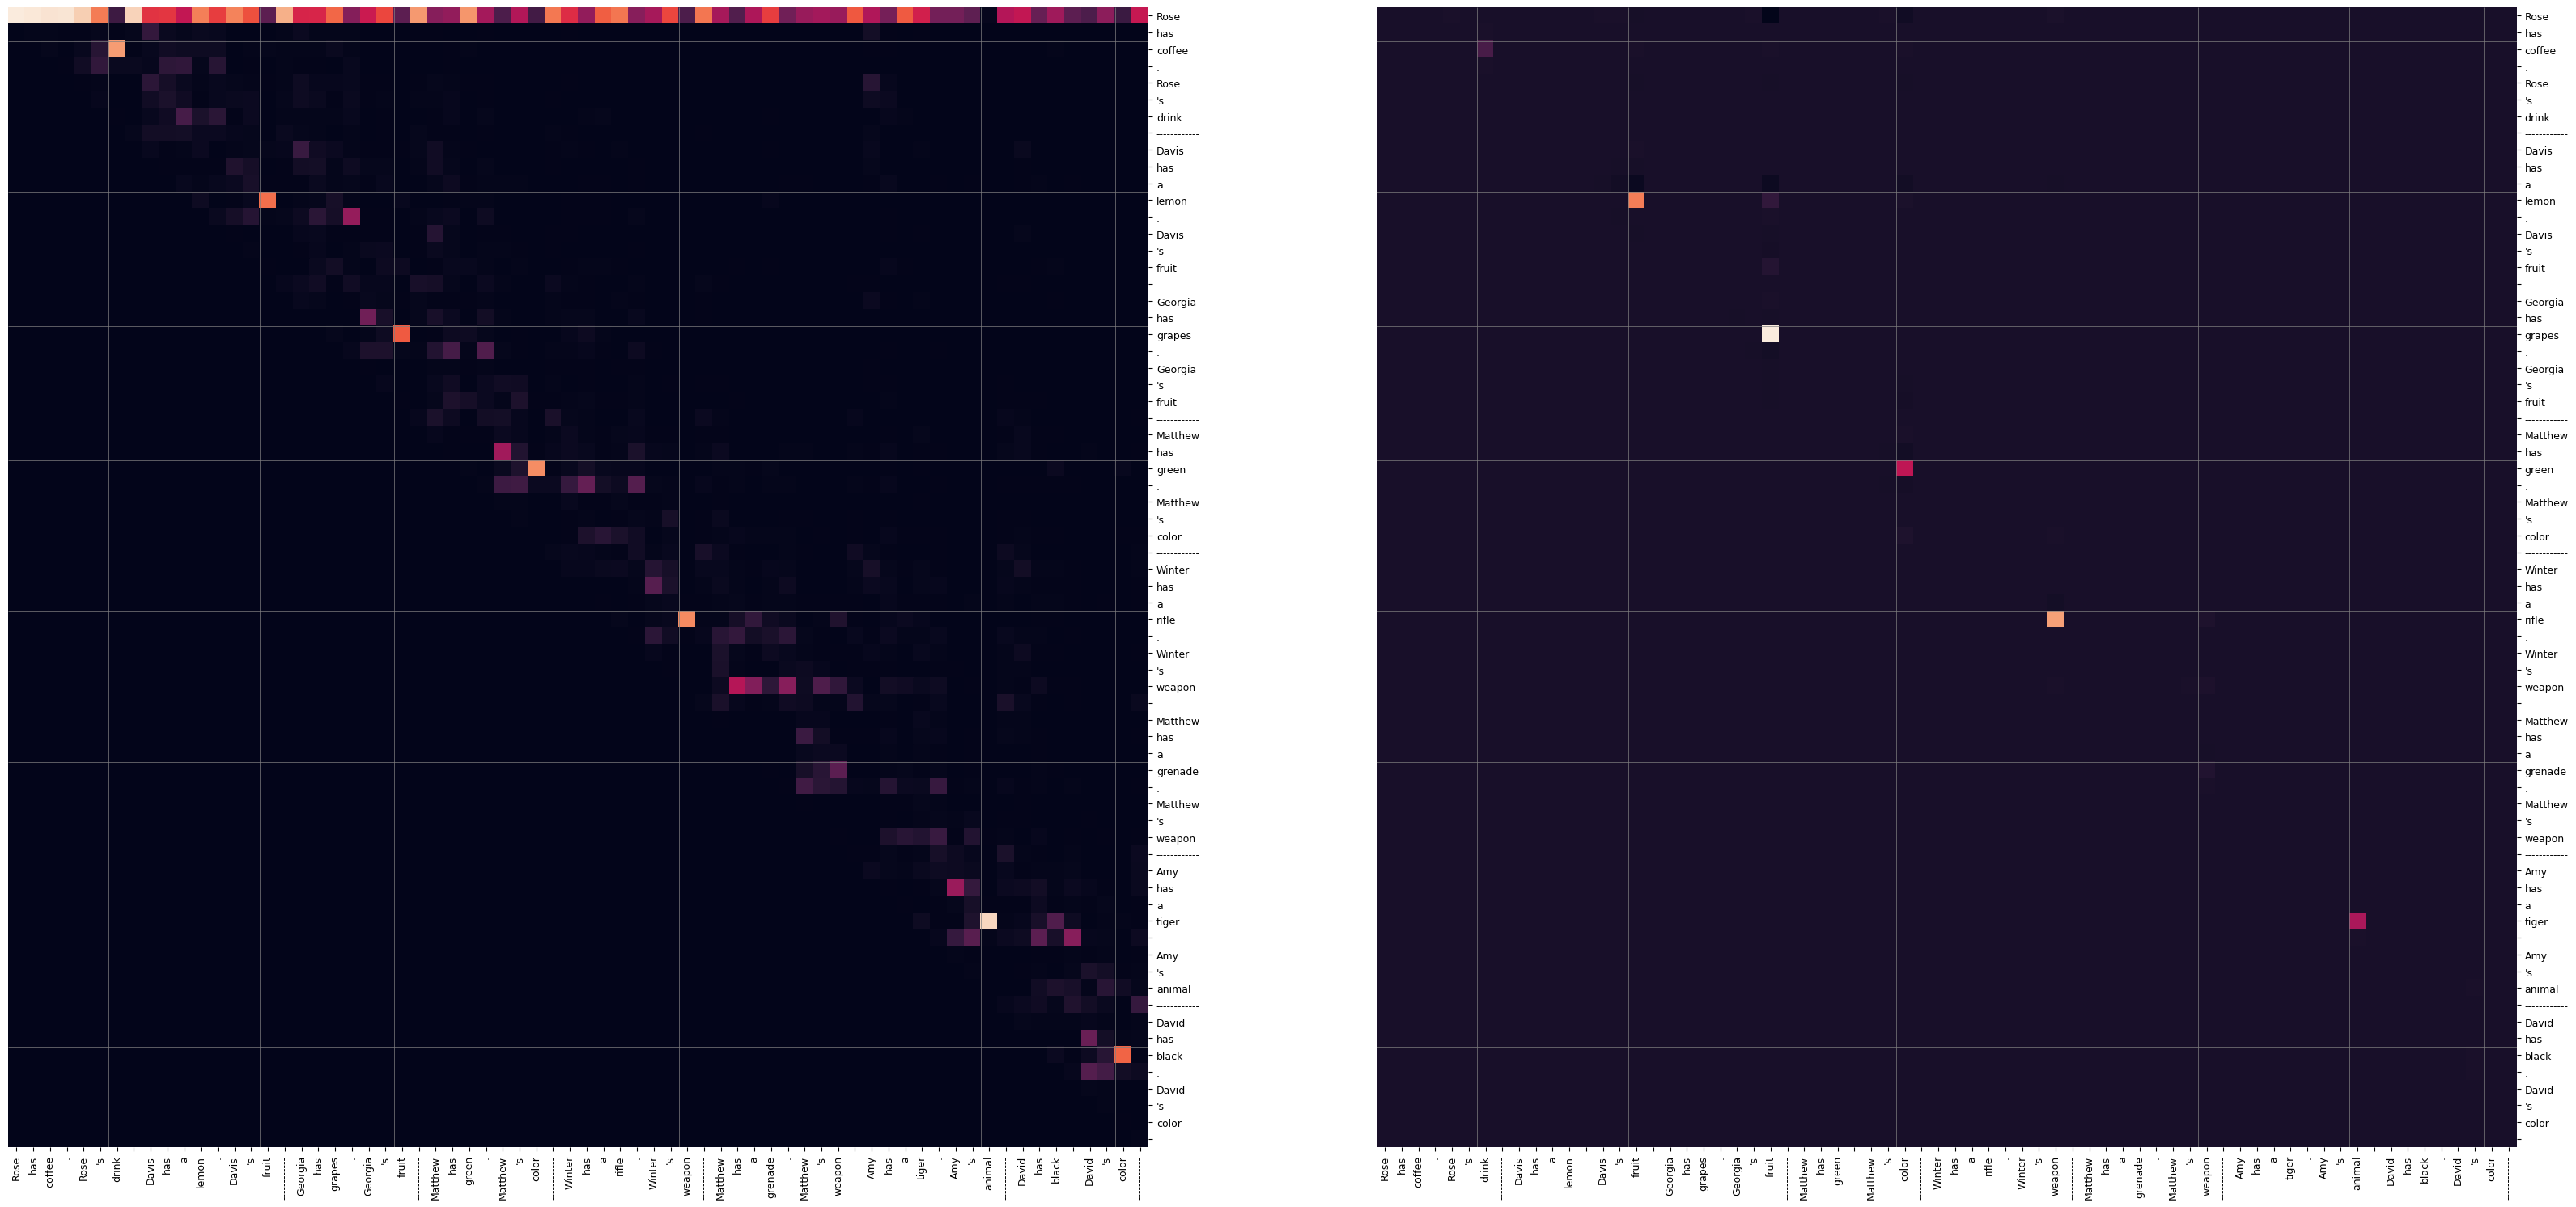

In [124]:
plot_attn_attrs(data_tuples[:2], model, tokenizer, node.parent, topi=[0,1])

George has an apple. Jessica has bread. Jessica's food
Tony has black. Egypt has a lemon. Tony's color
Summer has a gorilla. India has gray. India's color
 [-1] root labels┐
                 └*[0] top[0, 1] 21-5,20-5 attn_labels
[-1] root labels


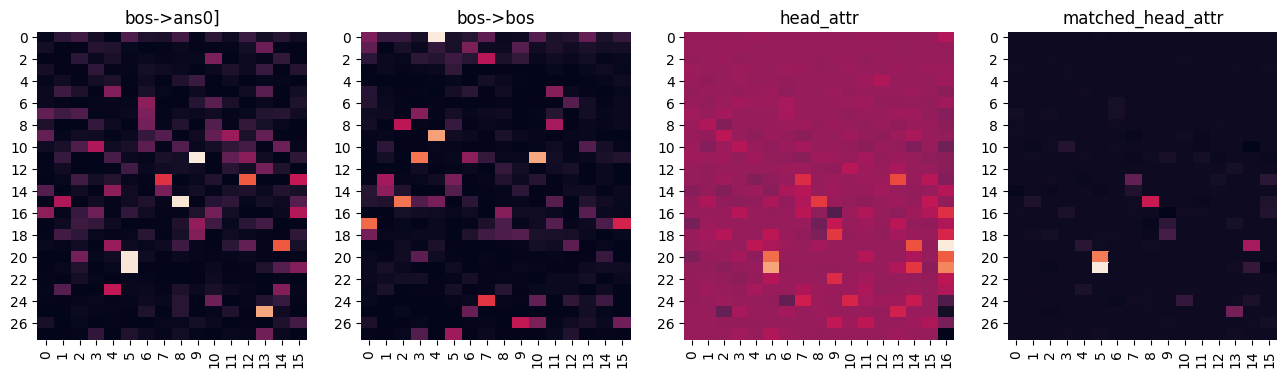

(array([11, 21, 20, 15, 25, 13, 19, 13, 13, 23]),
 array([ 9,  5,  5,  8, 13, 12, 14,  7, 15,  4]),
 array([0.21133193, 0.2087155 , 0.20862299, 0.20801485, 0.17359053,
       0.13845907, 0.13743085, 0.120083  , 0.10196342, 0.10067681],
      dtype=float32))
(array([ 0, 11,  9, 11, 15, 17, 24, 17, 26,  8]),
 array([ 4, 10,  4,  3,  2,  0,  7, 15,  9,  2]),
 array([0.7708799 , 0.63770545, 0.62117636, 0.548982  , 0.54555386,
       0.5322867 , 0.43999788, 0.40849516, 0.36631575, 0.35750124],
      dtype=float32))
(array([19, 21, 21, 20, 20, 19, 13, 15, 18, 21]),
 array([16,  5, 16,  5, 16, 14, 13,  8,  9, 14]),
 array([1.1158541 , 0.790012  , 0.6665555 , 0.5689934 , 0.5022531 ,
       0.47044557, 0.43490037, 0.37835985, 0.36951685, 0.35960072],
      dtype=float32))
(array([21, 20, 15, 19, 25, 13, 18, 24, 21, 17]),
 array([ 5,  5,  8, 14, 13,  7,  9, 10, 14,  9]),
 array([0.16488776, 0.1187051 , 0.07870447, 0.06465373, 0.04483558,
       0.03730135, 0.02568632, 0.01704767, 0.0168693 , 0.0

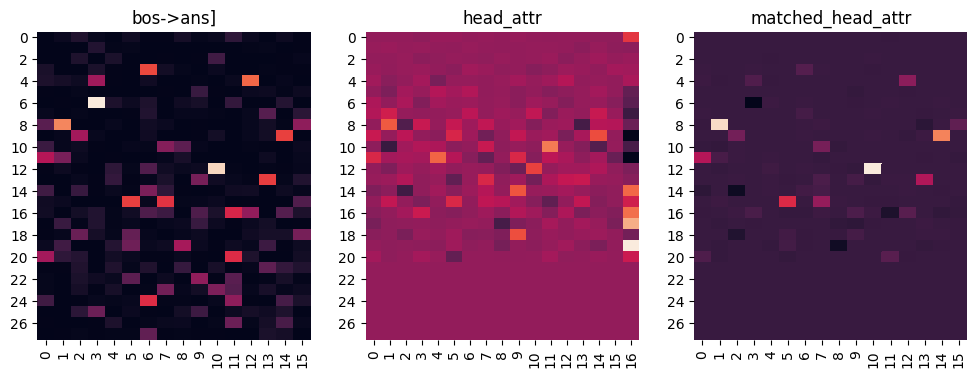

(array([ 6, 12,  8,  4,  3,  9, 15, 13, 15, 24]),
 array([ 3, 10,  1, 12,  6, 14,  5, 13,  7,  6]),
 array([0.13939922, 0.13209032, 0.10414203, 0.09492125, 0.08626737,
       0.08419356, 0.08336814, 0.0831668 , 0.07991212, 0.07786058],
      dtype=float32))
(array([19, 17, 10, 16, 14, 11,  8, 14, 18,  9]),
 array([16, 16, 11, 16, 16,  4,  1,  9,  9, 14]),
 array([0.56108814, 0.42081457, 0.31305593, 0.2916593 , 0.27879006,
       0.2705758 , 0.2516773 , 0.24134928, 0.23085004, 0.2280443 ],
      dtype=float32))
(array([12,  8,  9, 15, 11, 13, 15,  4, 10,  9]),
 array([10,  1, 14,  5,  0, 13,  7, 12,  7,  2]),
 array([0.02758029, 0.02621019, 0.01919986, 0.01291461, 0.00957774,
       0.00929654, 0.00718309, 0.00646513, 0.0049919 , 0.00465598],
      dtype=float32))


In [120]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

12 10
tensor([-5.2127, -4.6183, -4.4041, -4.5238])


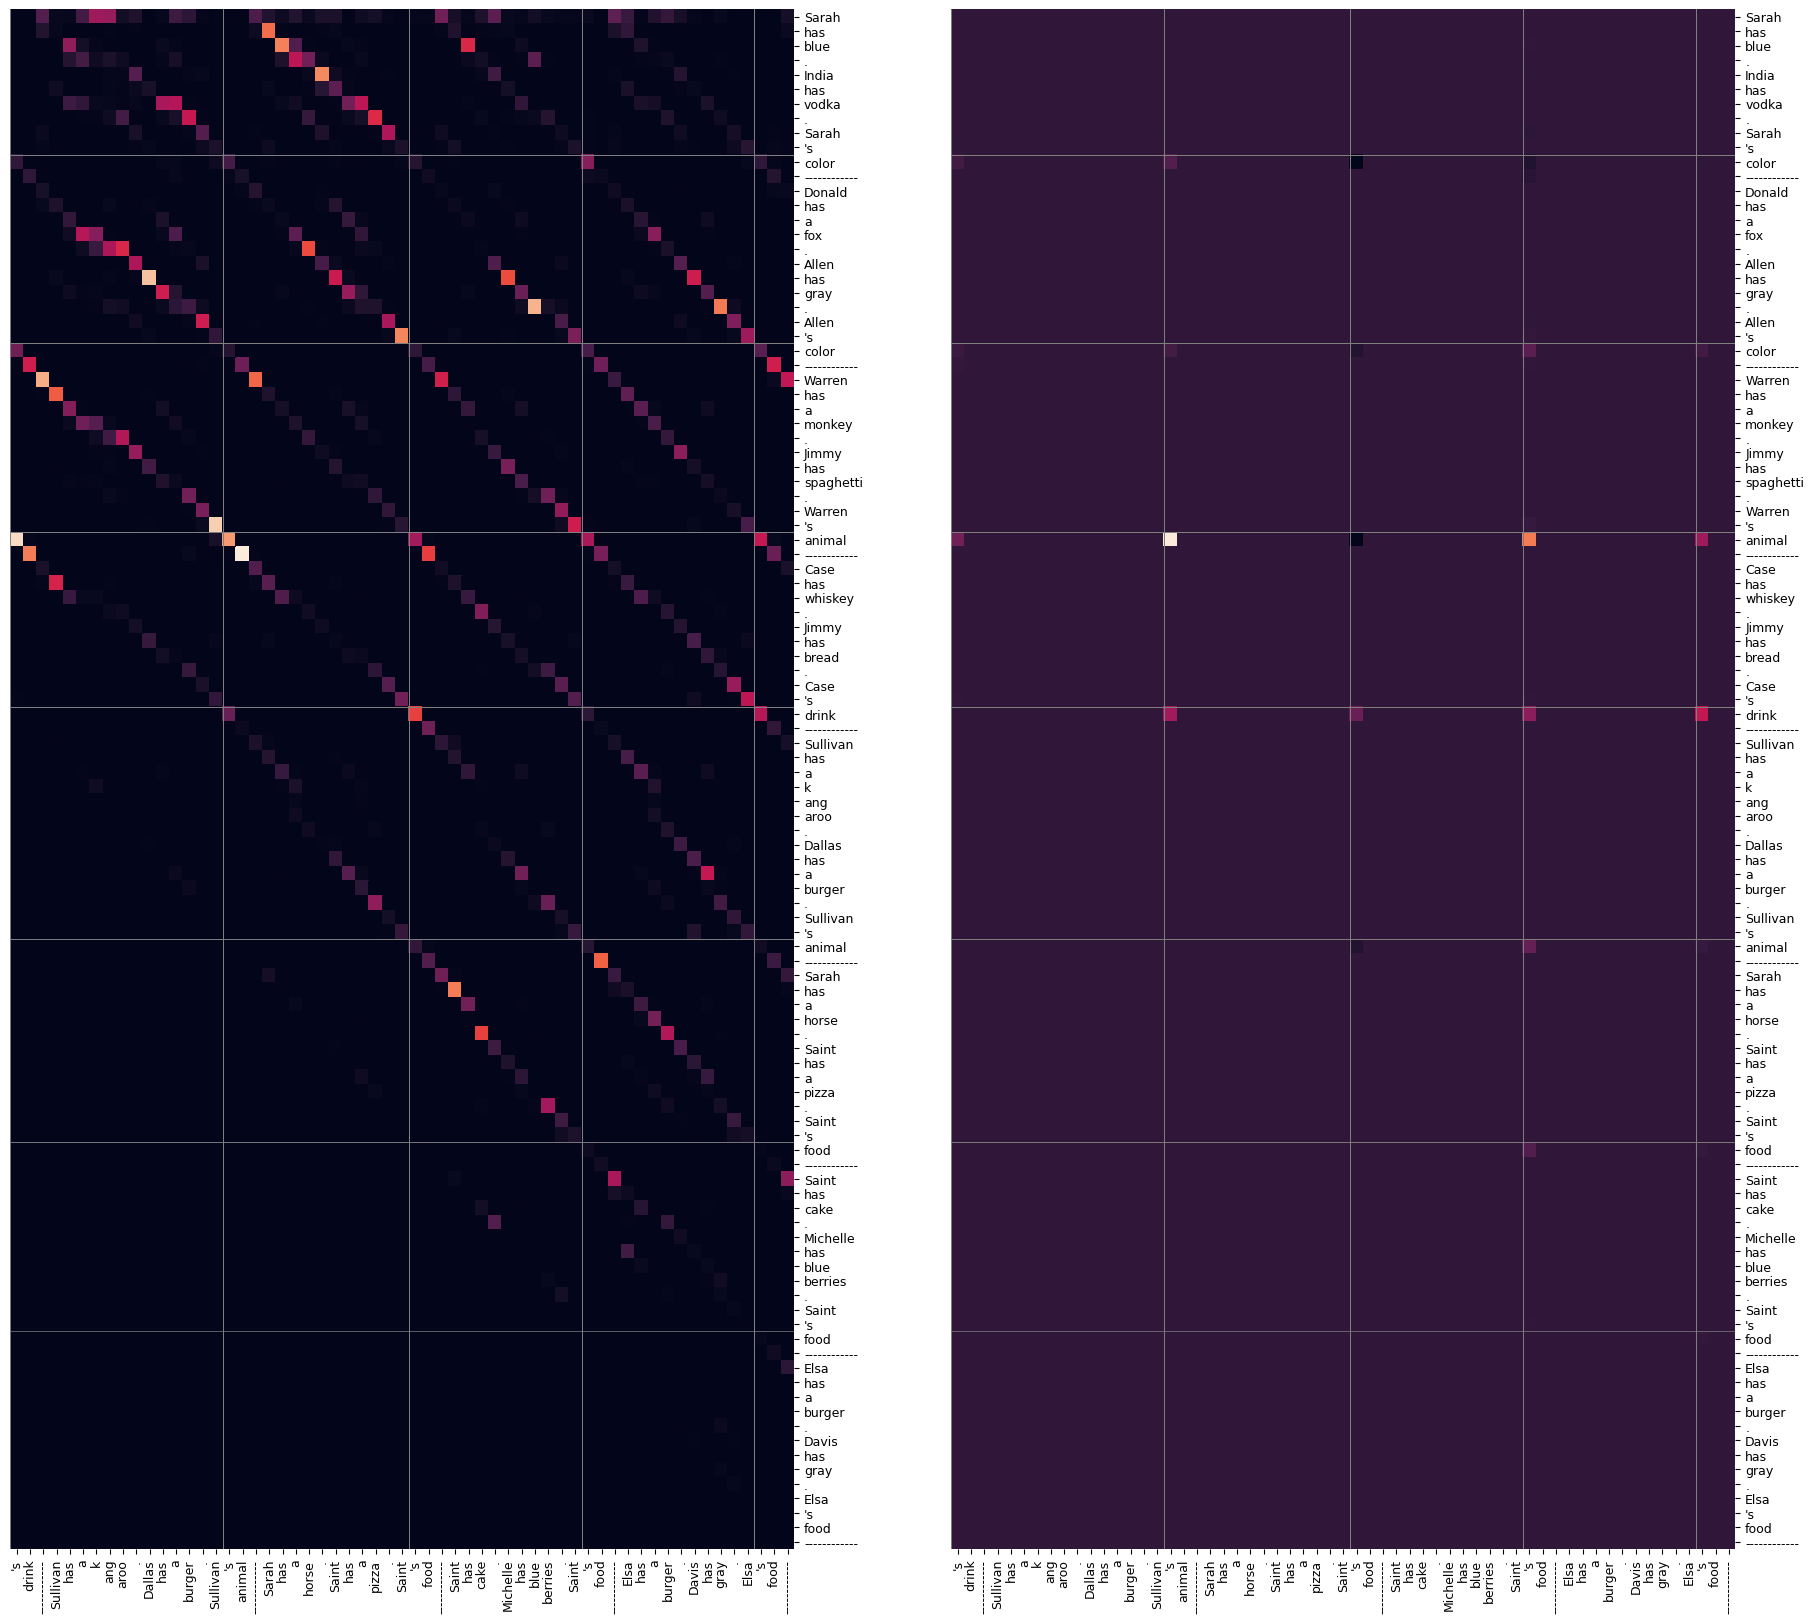

tensor([-6.4216, -5.5238, -5.0527, -4.9574])


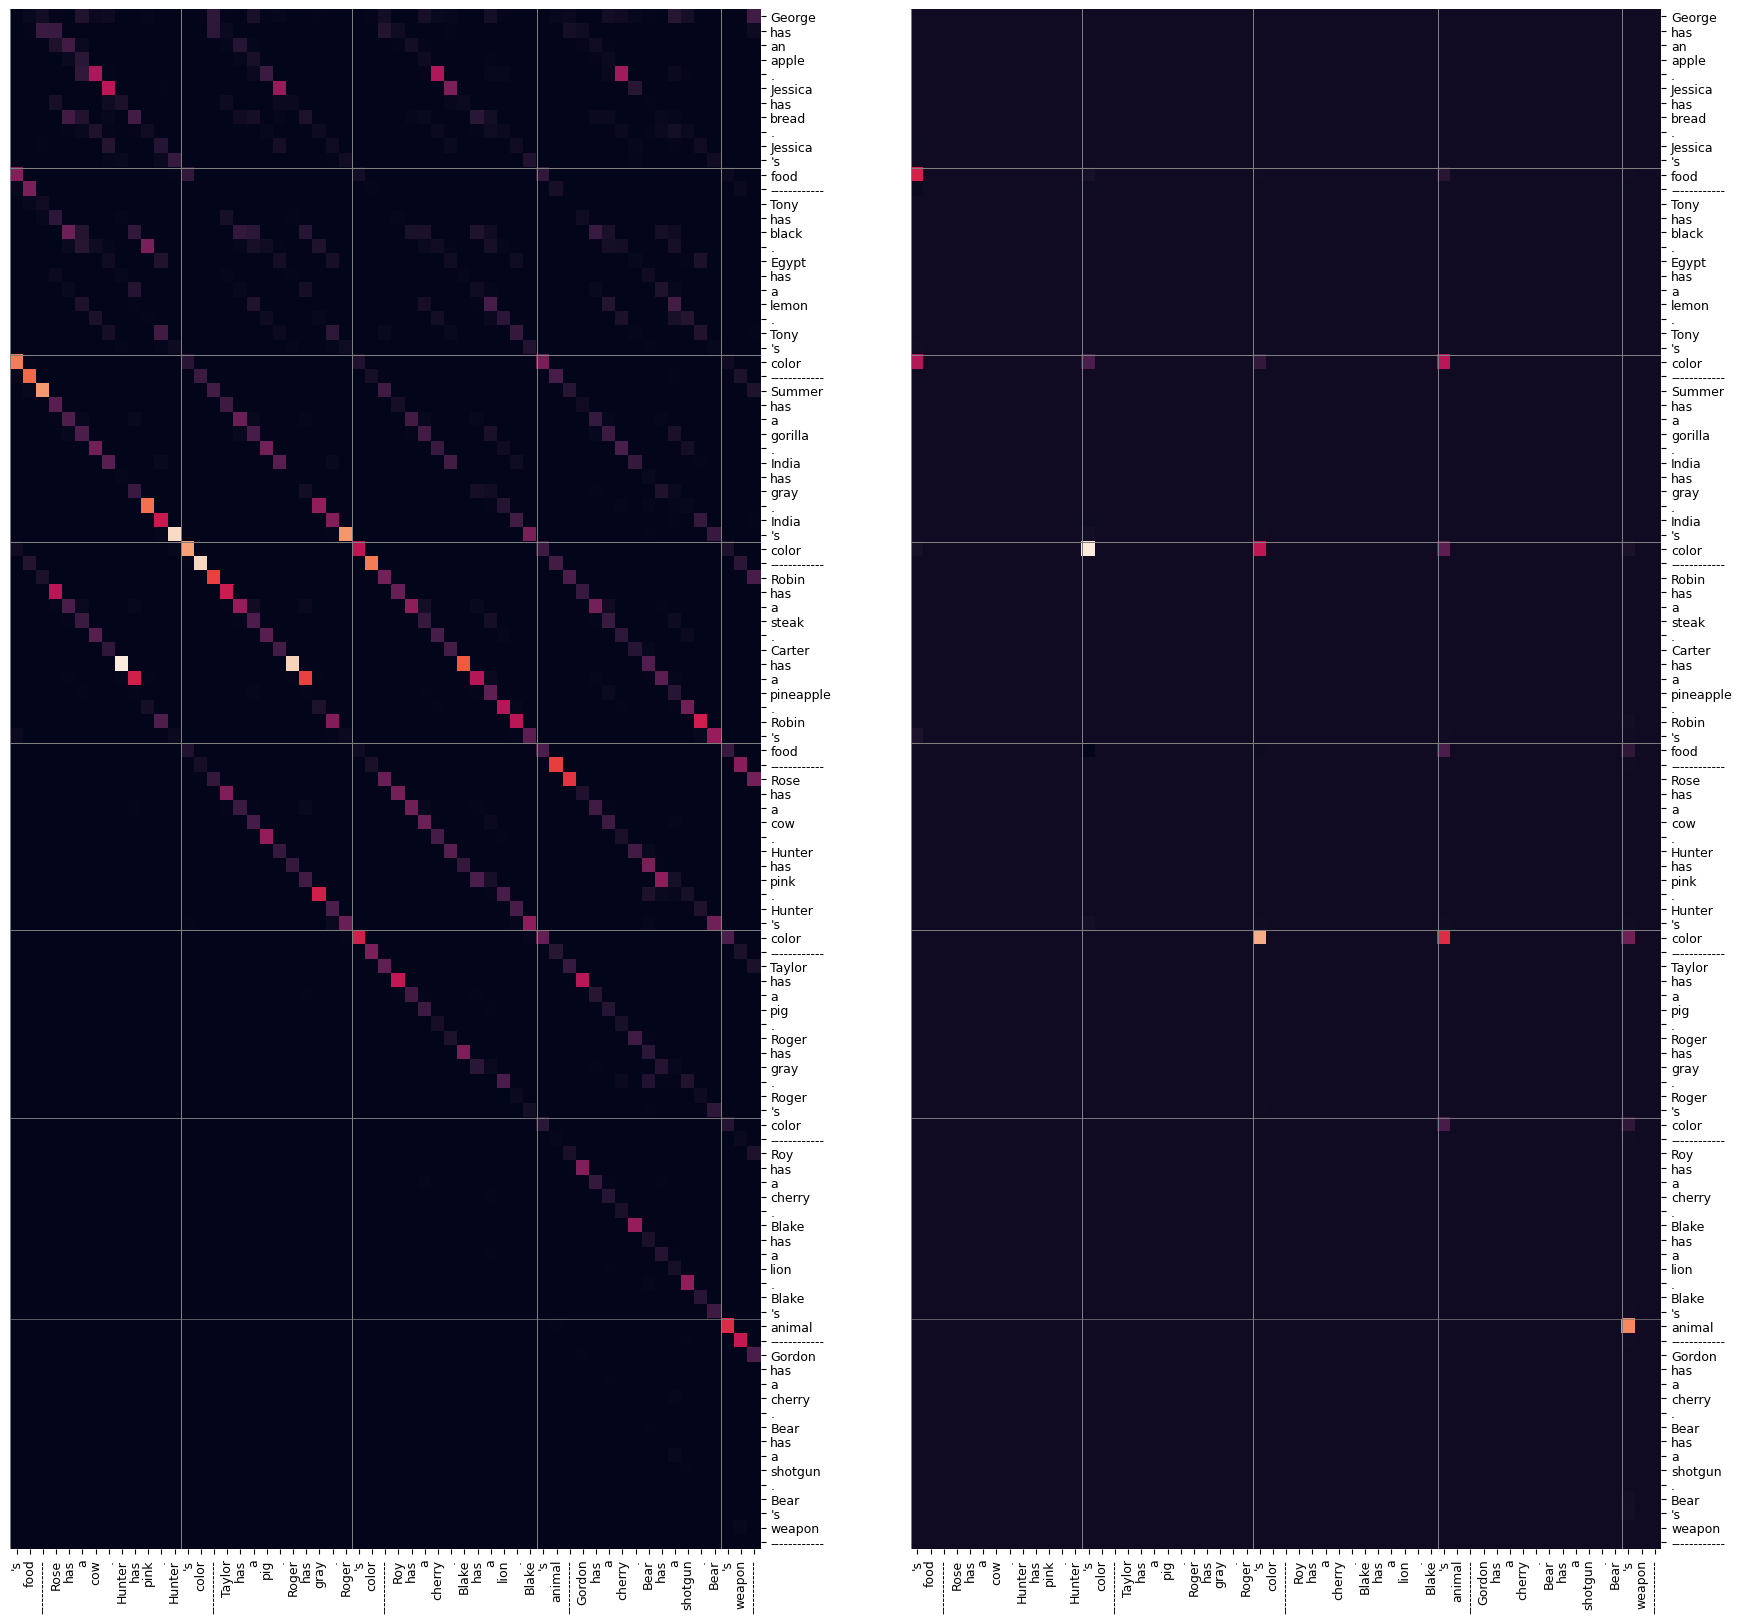

8 1
tensor([-5.2133, -4.7699, -4.6328, -4.7979])


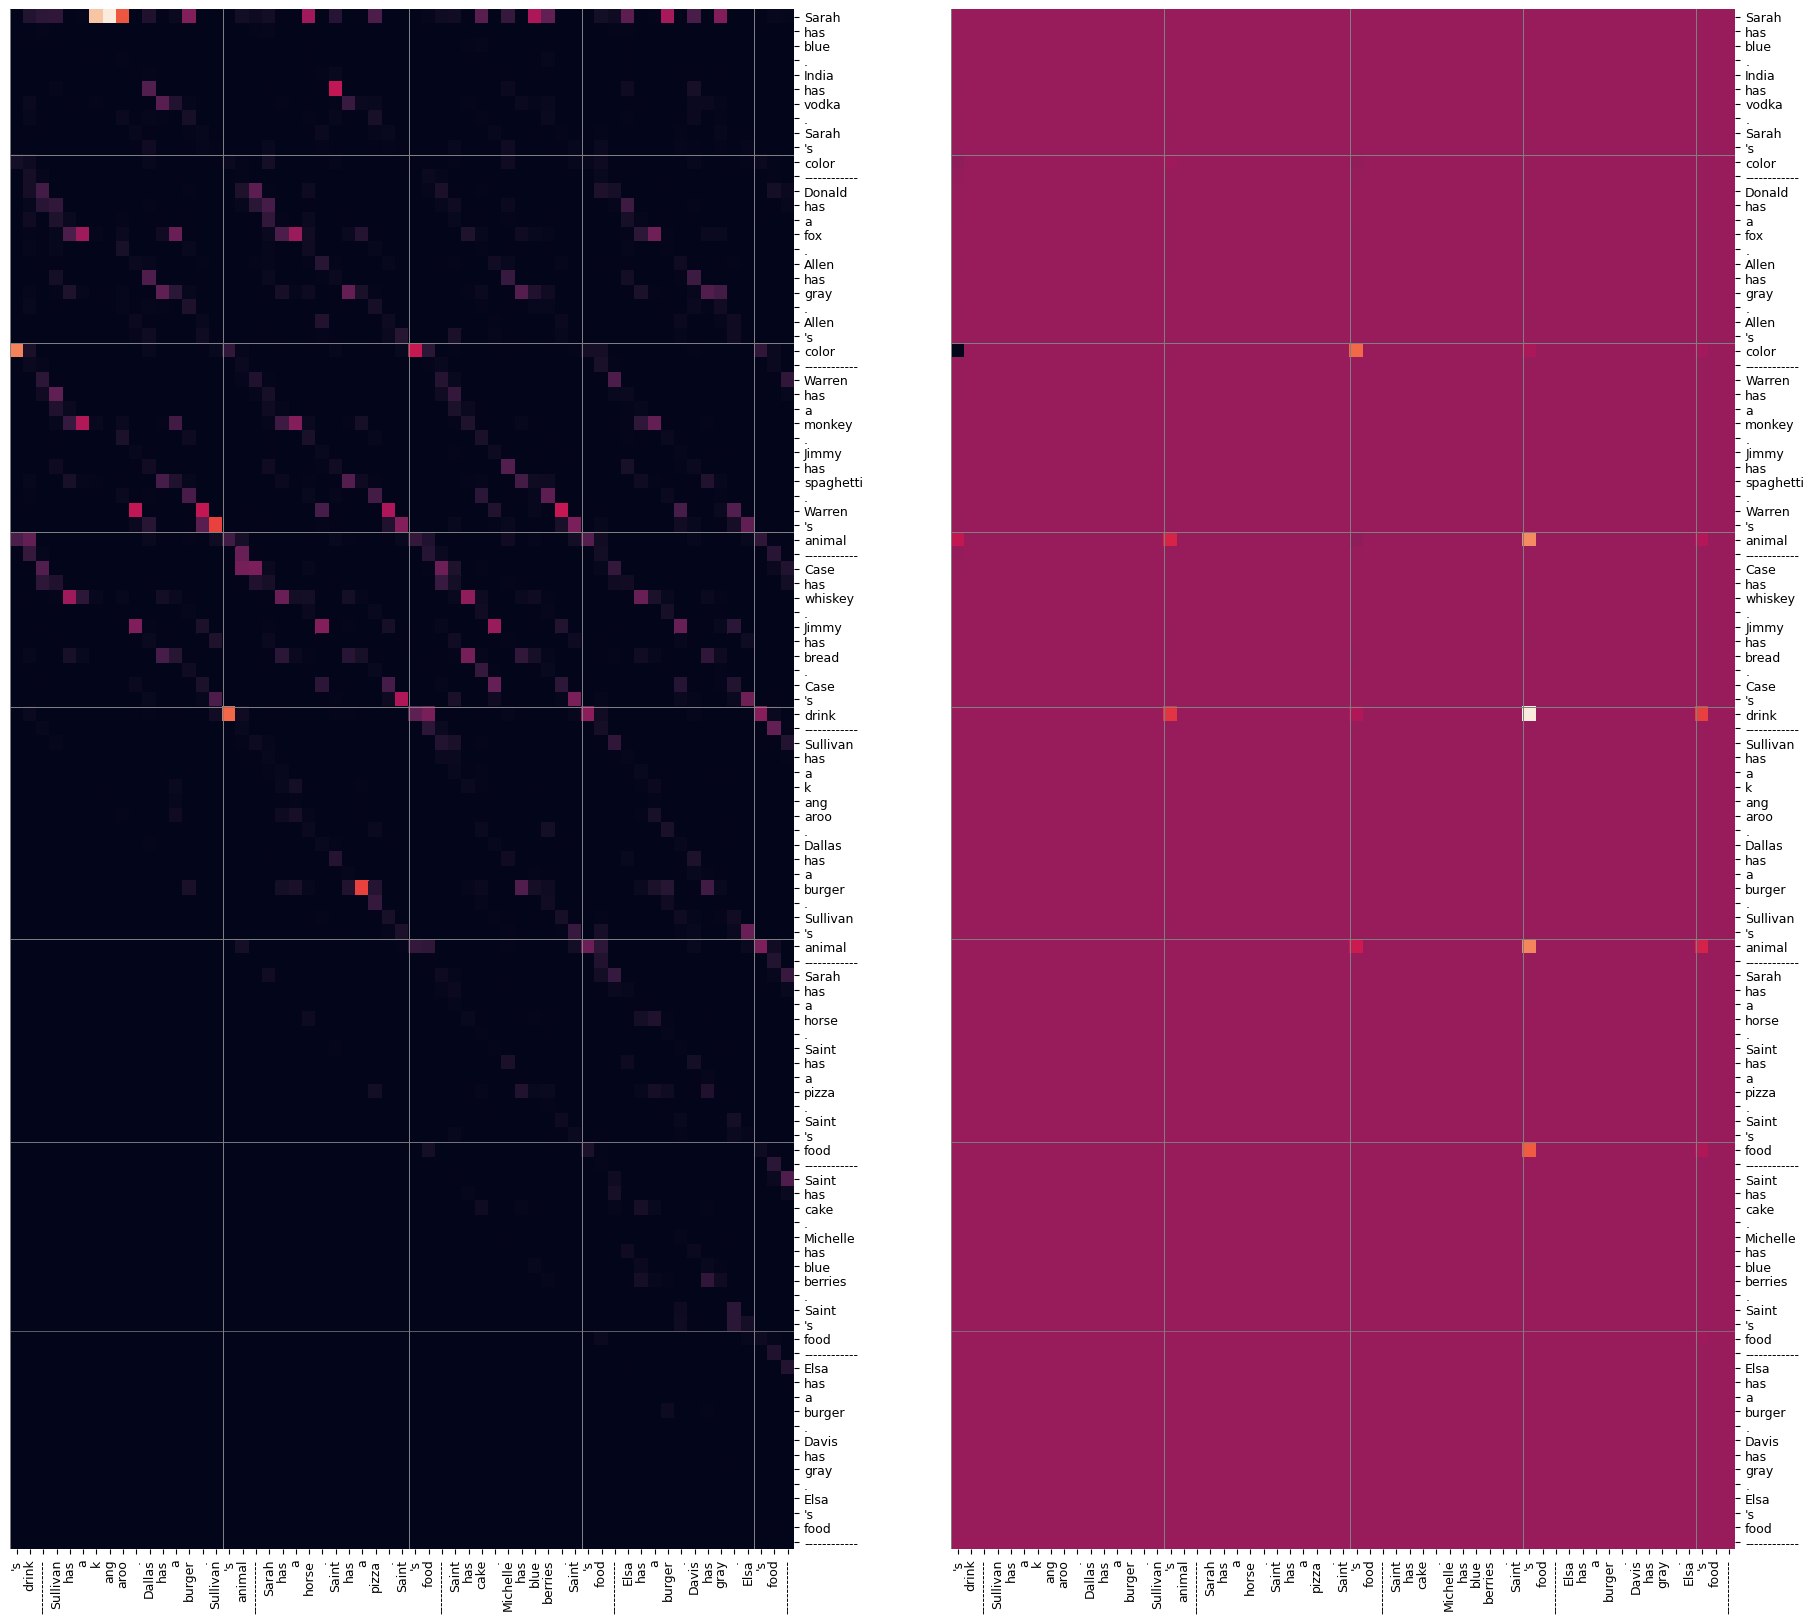

tensor([-6.4817, -5.0228, -4.0293, -3.4852])


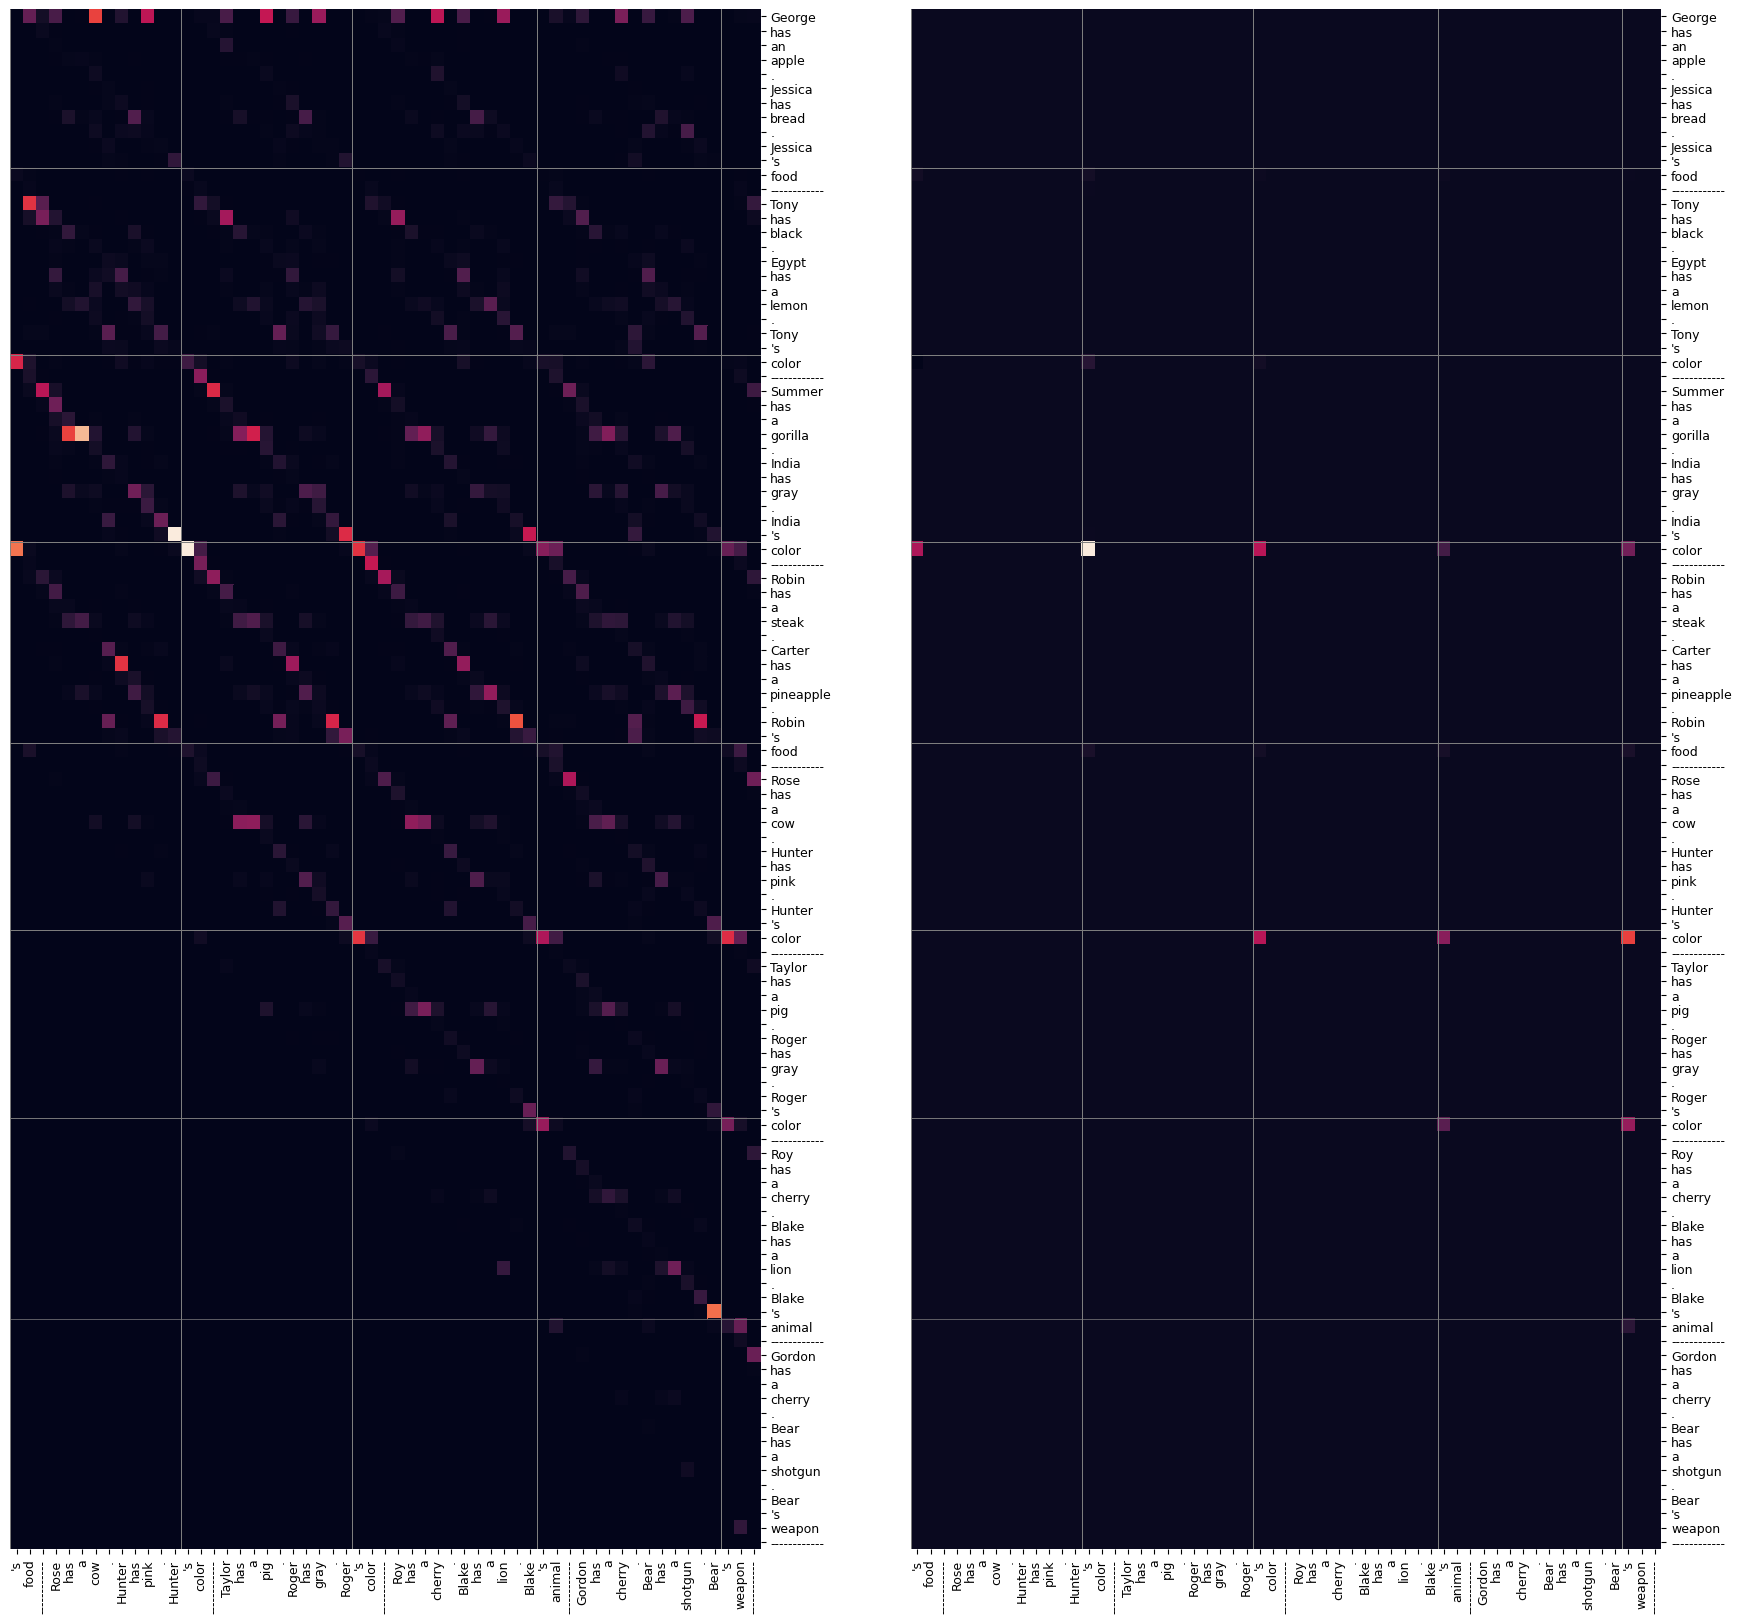

In [103]:
plot_attn_attrs(data_tuples[:2], model, tokenizer, node, topi=[0,1])

In [99]:
print(key); node = add_node_to_result(result, topi=[0,1])#, label_type='argmax_attn_labels')

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └*[0] top[0, 1] 21-5,20-5 attn_labels...


In [686]:
for intm_head in [(8, 1), (12, 10)]:
    for head, prod in iweightprod(model, [(5, 12), intm_head, [(19, 12), (12, 7), (16, 0)]], 'e vo vo qk e', weBTA=weBTAs[0]):
        print(intm_head, head, plot_eigv(prod, plot=False))

(8, 1) (19, 12) (-0.5285608768463135, 0.860317051410675)
(8, 1) (12, 7) (-0.030665799975395203, 0.39475545287132263)
(8, 1) (16, 0) (-0.8428910970687866, 0.9459712505340576)
(12, 10) (19, 12) (-0.628407895565033, 0.9047977328300476)
(12, 10) (12, 7) (0.7237392663955688, 0.90654456615448)
(12, 10) (16, 0) (-0.8043627142906189, 0.9306066632270813)


In [689]:
for pred_head in [(16, 0), (12, 7), (19, 12)]:
    for intm_head in [(8, 1), (12, 10)]:
        for head, prod in iweightprod(model, [[(6, 2), (8, 7), (1, 7)], intm_head, pred_head], 'e vo vo qk e', weBTA=weBTAs[0]):
            print(pred_head, intm_head, head, plot_eigv(prod, plot=False))

(16, 0) (8, 1) (6, 2) (0.8323681354522705, 0.918484091758728)
(16, 0) (8, 1) (8, 7) (0.9427853226661682, 0.9758059978485107)
(16, 0) (8, 1) (1, 7) (-0.7151409983634949, 0.9050319790840149)
(16, 0) (12, 10) (6, 2) (0.8168960809707642, 0.8969250917434692)
(16, 0) (12, 10) (8, 7) (0.9733738899230957, 0.9847989678382874)
(16, 0) (12, 10) (1, 7) (0.16739831864833832, 0.6803752779960632)
(12, 7) (8, 1) (6, 2) (-0.3794153034687042, 0.8730751872062683)
(12, 7) (8, 1) (8, 7) (0.9068382978439331, 0.9580665826797485)
(12, 7) (8, 1) (1, 7) (-0.36914756894111633, 0.7708468437194824)
(12, 7) (12, 10) (6, 2) (0.6840667128562927, 0.8769805431365967)
(12, 7) (12, 10) (8, 7) (0.9360365867614746, 0.9709669351577759)
(12, 7) (12, 10) (1, 7) (0.4803546369075775, 0.8156549334526062)
(19, 12) (8, 1) (6, 2) (0.9482666850090027, 0.9724591374397278)
(19, 12) (8, 1) (8, 7) (0.9801798462867737, 0.988507866859436)
(19, 12) (8, 1) (1, 7) (-0.6431209444999695, 0.8815361857414246)
(19, 12) (12, 10) (6, 2) (0.89526671

Joy is hardworking. So Joy's not lazy
Anne is harsh. So Anne's not gentle
Morgan is rational. So Morgan's not irrational
 [-1] root labels┐
                 └[0] top[0] 16-14 attn_labels┐
                                              └*[1] top[0, 1] 8-1,12-10
[-1] root labels


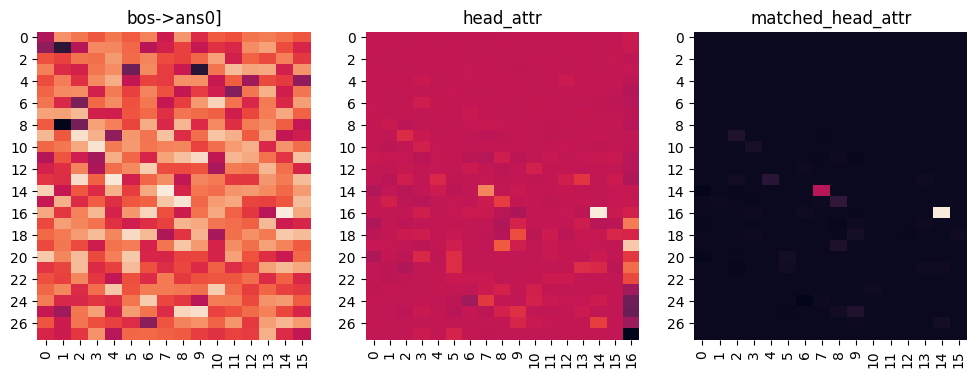

(array([16, 14, 13, 15, 10,  9, 25, 13, 11, 18]),
 array([14,  7,  4,  8,  3,  2,  9,  2,  9,  5]),
 array([-0.22404538, -0.26426464, -0.32291535, -0.47671288, -0.52815974,
       -0.5657489 , -0.6306189 , -0.758794  , -0.7767543 , -0.8513253 ],
      dtype=float32))
(array([16, 19, 14, 17, 21, 19, 18, 22, 26, 15]),
 array([14, 16,  7, 16, 16,  8,  9, 16, 14,  8]),
 array([1.7829967 , 1.4742178 , 0.92033106, 0.8625574 , 0.7433384 ,
       0.6010051 , 0.5150038 , 0.48811558, 0.40587863, 0.3955037 ],
      dtype=float32))
(array([16, 14, 15, 13, 25,  9, 19, 10, 18, 26]),
 array([14,  7,  8,  4,  9,  2,  8,  3,  9, 14]),
 array([7.9581943 , 3.4826114 , 0.8296476 , 0.6714766 , 0.47457597,
       0.46025598, 0.40867478, 0.27440712, 0.25377205, 0.2051951 ],
      dtype=float32))
[0] top[0] 16-14 attn_labels


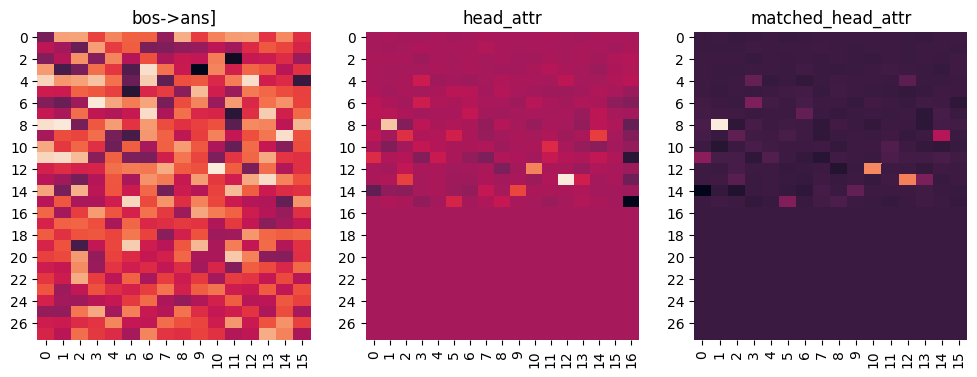

(array([12,  6,  8,  8,  3,  4,  9,  7, 13, 11]),
 array([10,  3,  1,  0,  6, 12, 14,  6, 13,  1]),
 array([-2.0619197, -2.147152 , -2.1584582, -2.3844886, -2.3936834,
       -2.3952484, -2.4289227, -2.4505653, -2.4905105, -2.51614  ],
      dtype=float32))
(array([13,  8, 12, 14, 13,  9,  9, 11, 10, 15]),
 array([12,  1, 10,  9,  2, 14,  2,  0, 11,  5]),
 array([2.1855073 , 1.794246  , 1.2097158 , 0.75793827, 0.69399714,
       0.6832046 , 0.5568255 , 0.5192549 , 0.5060235 , 0.4414171 ],
      dtype=float32))
(array([ 8, 12, 13,  9, 11, 15,  6, 13,  4,  7]),
 array([ 1, 10, 12, 14,  0,  5,  3, 13,  3,  6]),
 array([0.83126277, 0.58669394, 0.5659246 , 0.28127885, 0.19405212,
       0.16885033, 0.15801533, 0.15140642, 0.10328428, 0.0972256 ],
      dtype=float32))
[1] top[0, 1] 8-1,12-10


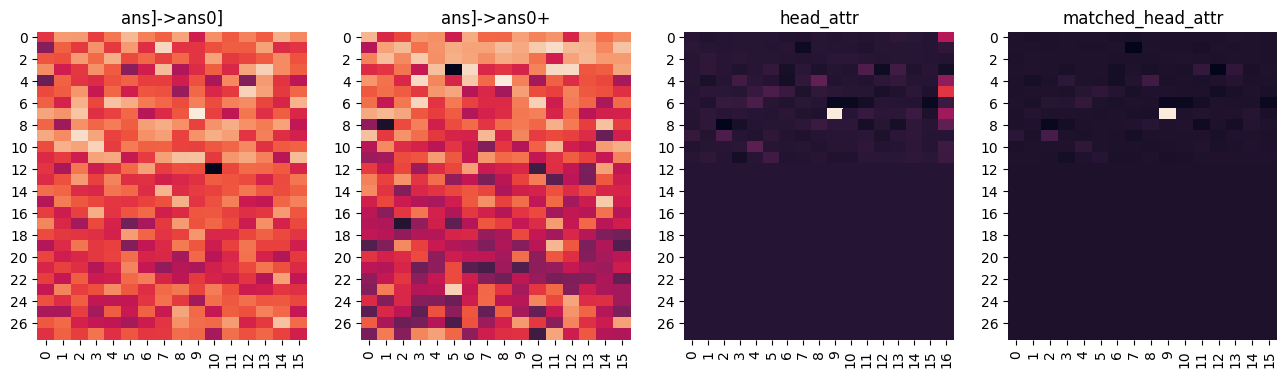

(array([ 7,  9,  1, 10,  5,  3,  7,  6, 26, 11]),
 array([ 9,  2,  7,  3, 12, 13,  2,  4, 14,  9]),
 array([-0.4647833 , -0.91090393, -1.0842161 , -1.2195952 , -1.2474614 ,
       -1.2913882 , -1.6618898 , -1.7153547 , -1.7185242 , -1.7532122 ],
      dtype=float32))
(array([ 4,  1,  4,  3,  3,  3,  6, 23,  6,  1]),
 array([ 8, 11,  3, 12,  6, 11,  3,  5, 10, 10]),
 array([-0.65721524, -1.0485238 , -1.0864106 , -1.0934249 , -1.1174902 ,
       -1.1213977 , -1.1998528 , -1.3498194 , -1.3556361 , -1.5138632 ],
      dtype=float32))
(array([ 7,  5,  0,  7,  4,  4,  8, 10,  3,  9]),
 array([ 9, 16, 16, 16, 16,  8, 16,  4, 11,  2]),
 array([2.318398  , 1.2229468 , 0.9039402 , 0.7549218 , 0.6695328 ,
       0.3926266 , 0.37536943, 0.3501625 , 0.26363483, 0.26055413],
      dtype=float32))
(array([ 7,  9,  4,  3,  6,  3, 10,  5,  4,  9]),
 array([ 9,  2,  8, 11,  4, 13,  4,  5,  3,  0]),
 array([1.1945882 , 0.13914141, 0.11671253, 0.07705309, 0.07432283,
       0.06705794, 0.06301634, 0.06115

In [359]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [370]:
print(key); node = add_node_to_result(result, topi=[0])

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-14 attn_labels┐
                                              └[1] top[0, 1] 8-1,12-10┐
                                                                      └*[2] top[0] 7-9...


Christopher is passive. Morgan is rich. So Morgan's rich
August is knowledgeable. Ruby is thin. So August's knowledgeable
Ryan is popular. Robin is quiet. So Ryan's popular
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0, 1] 12-10,8-1┐
                                                                     └*[2] top[0, 1, 2, 3, 4] 6-2,8-7,3-12,1-7,6-10...
[-1] root labels


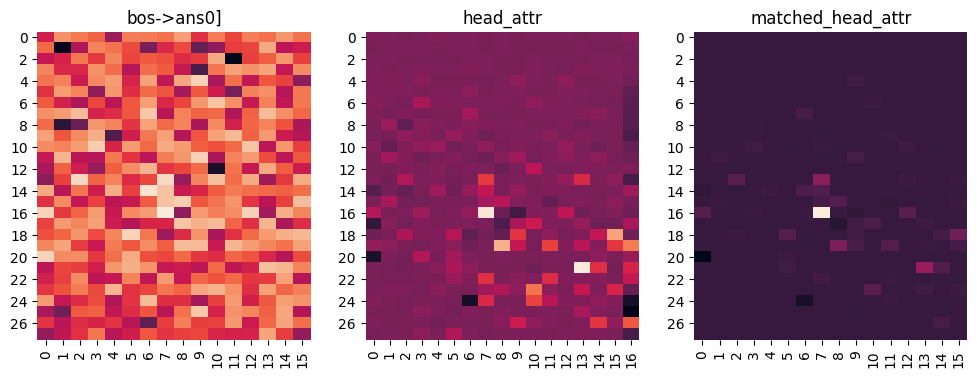

(array([16, 14, 13, 13, 16, 18, 20,  4, 16, 11]),
 array([ 7,  6,  7,  2,  0,  5,  0,  9, 12,  9]),
 array([-0.8131221, -1.1140809, -1.3658707, -1.4227219, -1.550431 ,
       -1.5607324, -1.5697958, -1.5797439, -1.6435707, -1.6617503],
      dtype=float32))
(array([21, 16, 19, 18, 19, 23, 26, 24, 19, 13]),
 array([13,  7,  8, 15, 16, 10, 16, 10, 11,  7]),
 array([0.75155824, 0.7355008 , 0.5843423 , 0.5458761 , 0.4470967 ,
       0.42752582, 0.36593425, 0.31886303, 0.31549644, 0.30079457],
      dtype=float32))
(array([16, 21, 13, 19, 18, 23, 13, 16, 18, 16]),
 array([ 7, 13,  7,  8, 15, 10,  2, 12,  5,  0]),
 array([0.32617354, 0.09005119, 0.07675026, 0.06296989, 0.05223418,
       0.0355777 , 0.03315381, 0.03299941, 0.02903952, 0.02850244],
      dtype=float32))
[0] top[0] 16-7 attn_labels


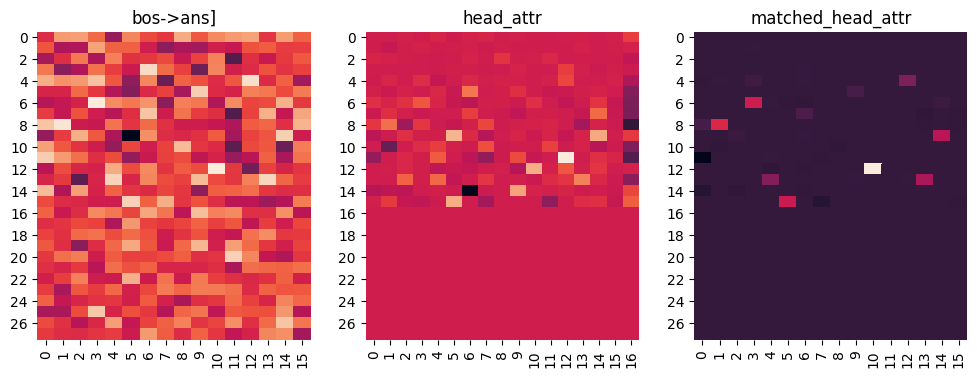

(array([ 6, 12,  8,  4,  3, 13, 13, 15, 20,  9]),
 array([ 3, 10,  1, 12,  6, 13,  4,  5, 11, 14]),
 array([-2.0432267, -2.0723977, -2.266554 , -2.484486 , -2.6210263,
       -2.802127 , -2.9011645, -2.9306583, -2.9438295, -3.0412364],
      dtype=float32))
(array([11,  9, 12, 15,  9, 14, 13,  5,  8,  7]),
 array([12,  5, 10,  5, 14,  9, 13,  6,  1, 14]),
 array([0.7693001 , 0.5414798 , 0.51048654, 0.5035944 , 0.49987787,
       0.47721595, 0.35205713, 0.31638402, 0.29327953, 0.2701404 ],
      dtype=float32))
(array([12,  8,  6, 15,  9, 13, 13,  4,  7,  8]),
 array([10,  1,  3,  5, 14, 13,  4, 12,  6,  0]),
 array([0.06426188, 0.03040393, 0.02753537, 0.02687275, 0.02388206,
       0.02136313, 0.01450619, 0.0135276 , 0.00445843, 0.00352038],
      dtype=float32))
[1] top[0, 1] 12-10,8-1


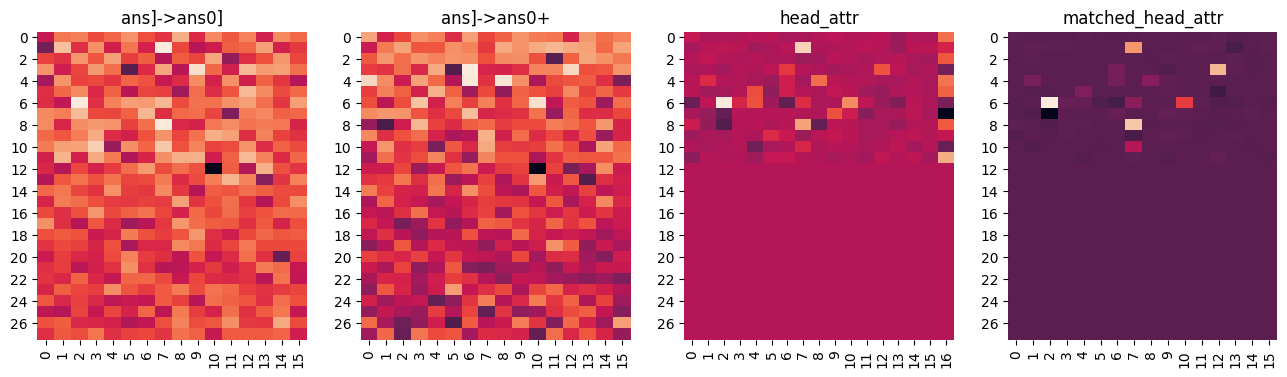

(array([ 1,  6,  8,  3, 10, 10,  1,  7, 11,  5]),
 array([ 7,  2,  7,  9,  3,  7,  1,  2, 12, 12]),
 array([-0.10544297, -0.12014531, -0.1850719 , -0.5820397 , -1.184849  ,
       -1.4089417 , -1.7394853 , -1.8467633 , -1.9650996 , -1.9652803 ],
      dtype=float32))
(array([3, 4, 4, 6, 3, 4, 6, 7, 8, 1]),
 array([ 6,  6,  8, 10, 12,  0,  3,  6,  3, 11]),
 array([-0.21864541, -0.33301038, -0.4052481 , -0.5228414 , -0.7983227 ,
       -0.841054  , -1.346777  , -1.532387  , -1.7368424 , -1.7376413 ],
      dtype=float32))
(array([ 6,  1, 11,  8,  6,  4,  0,  4,  5,  8]),
 array([ 2,  7, 16,  7, 10, 16, 16,  8, 16, 16]),
 array([0.6271033 , 0.5563282 , 0.44647613, 0.4140543 , 0.35706034,
       0.29953283, 0.2877331 , 0.2827124 , 0.25118467, 0.24094087],
      dtype=float32))
(array([ 6,  8,  3,  1,  6, 10,  6,  4,  5,  4]),
 array([ 2,  7, 12,  7, 10,  7,  7,  8,  4,  1]),
 array([0.06739227, 0.05882639, 0.05555389, 0.04800212, 0.03118702,
       0.01840849, 0.00964398, 0.00909121, 0.007

In [417]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [385]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3,4])

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0, 1] 12-10,8-1┐
                                                                     └*[2] top[0, 1, 2, 3, 4] 6-2,8-7,3-12,1-7,6-10...


Christopher is irresponsible. Morgan is poor. So Morgan's not rich
August is hot. Ruby is small. So August's not cold
Ryan is unconscious. Robin is quiet. So Ryan's not conscious
                 ┌[0] top[0] 16-14 argmax_attn_labels┐
                 │                                   └[1] top[0, 1] 8-1,12-10┐
                 │                                                           └[2] top[0] 7-9
 [-1] root labels┤
                 └[0] top[0] 16-14 attn_labels┐
                                              └[1] top[0, 1] 8-1,12-10┐
                                                                      └*[2] top[0] 7-9...
[-1] root labels


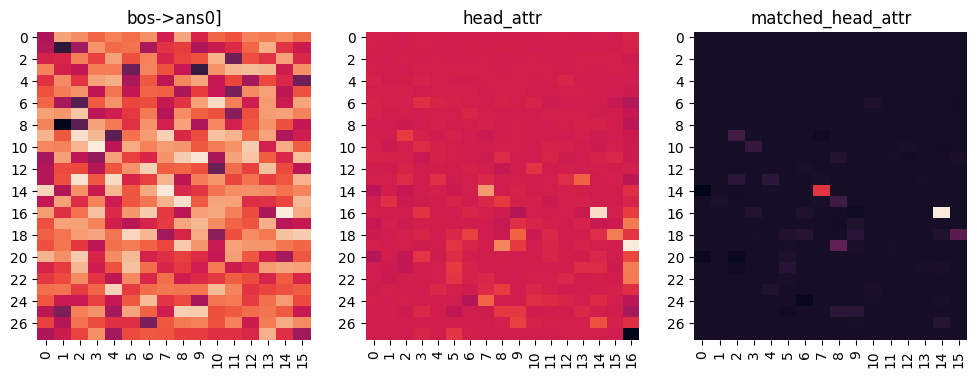

(array([10, 16, 14, 11, 13, 15,  9, 13,  6, 18]),
 array([ 3, 14,  7,  9,  2,  8,  2,  4, 10,  5]),
 array([-1.0614762, -1.0834801, -1.1901063, -1.2660172, -1.3361347,
       -1.4233662, -1.436903 , -1.563286 , -1.590735 , -1.712683 ],
      dtype=float32))
(array([19, 16, 14, 19, 21, 18, 22, 17, 24, 18]),
 array([16, 14,  7,  8, 16, 15, 16, 16,  7,  9]),
 array([0.9225615 , 0.85220003, 0.5222215 , 0.44205382, 0.4086256 ,
       0.3954818 , 0.39397603, 0.38965353, 0.2994766 , 0.2949795 ],
      dtype=float32))
(array([16, 14, 19, 18,  9, 15, 10, 13, 25, 13]),
 array([14,  7,  8, 15,  2,  8,  3,  4,  8,  2]),
 array([0.2883979 , 0.15885401, 0.05732693, 0.05438753, 0.03474189,
       0.03422713, 0.02544804, 0.01949975, 0.01885692, 0.01821908],
      dtype=float32))
[0] top[0] 16-14 attn_labels


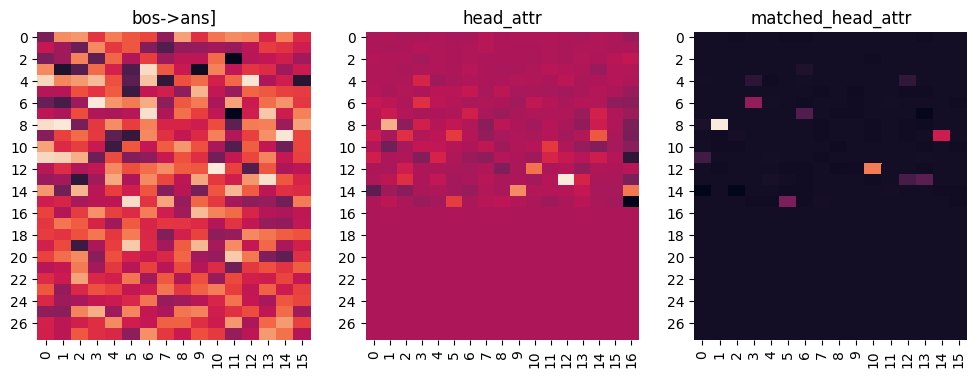

(array([12,  6,  8,  4,  9, 13,  7,  8, 15,  3]),
 array([10,  3,  1, 12, 14, 13,  6,  0,  5,  6]),
 array([-2.002304 , -2.0551844, -2.0881045, -2.1751802, -2.1937742,
       -2.2998815, -2.337555 , -2.3848898, -2.4324052, -2.4835942],
      dtype=float32))
(array([13,  8, 14, 14, 12,  9, 15,  9, 10,  9]),
 array([12,  1,  9, 16, 10, 14,  5,  5, 11,  2]),
 array([0.79002386, 0.57762516, 0.45729977, 0.40136495, 0.37706846,
       0.31034058, 0.22494863, 0.21906604, 0.21601075, 0.19114912],
      dtype=float32))
(array([ 8, 12,  9,  6, 15, 13,  7, 13, 11,  4]),
 array([ 1, 10, 14,  3,  5, 13,  6, 12,  0, 12]),
 array([0.07158036, 0.05091322, 0.03460147, 0.02411781, 0.01975619,
       0.01408757, 0.01208335, 0.01073118, 0.00910435, 0.00616032],
      dtype=float32))
[1] top[0, 1] 8-1,12-10


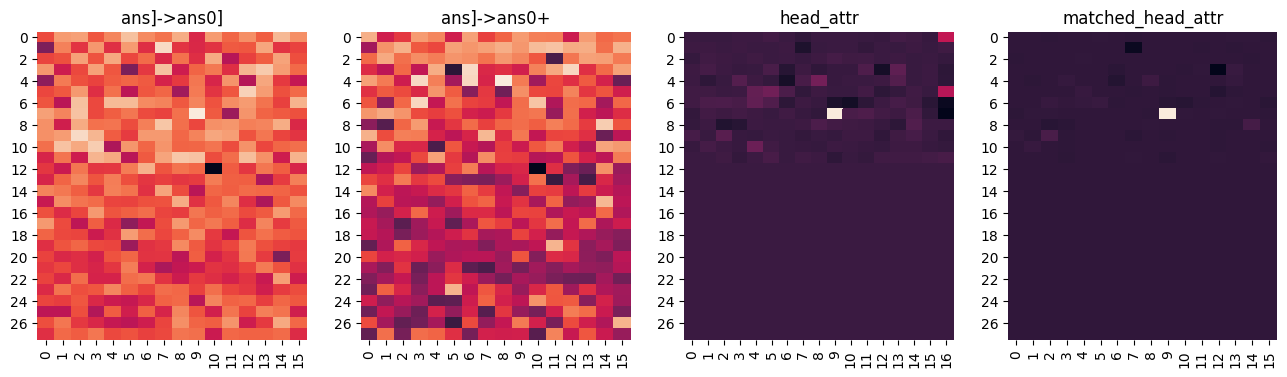

(array([ 7,  1,  9,  5, 10,  3, 11,  8, 10,  7]),
 array([ 9,  7,  2, 12,  3, 13,  8,  7,  1,  2]),
 array([-0.48755345, -1.1073177 , -1.1164478 , -1.4089204 , -1.5828502 ,
       -1.7160457 , -1.7882301 , -1.8945122 , -1.9793423 , -1.9846205 ],
      dtype=float32))
(array([4, 3, 4, 6, 3, 4, 8, 6, 1, 1]),
 array([ 8,  6,  3,  3, 12,  6, 14, 10, 11, 10]),
 array([-0.82827485, -1.2663082 , -1.30692   , -1.324405  , -1.331464  ,
       -1.3490177 , -1.6154763 , -1.8305976 , -1.8823582 , -2.0159717 ],
      dtype=float32))
(array([ 7,  0,  5,  4,  5, 10,  5,  6,  3,  9]),
 array([ 9, 16, 16,  8,  5,  4,  4,  4, 13,  2]),
 array([1.396103  , 0.53617567, 0.48715025, 0.23154691, 0.21675475,
       0.199749  , 0.16530544, 0.16239291, 0.14587918, 0.12329111],
      dtype=float32))
(array([ 7,  9,  8,  4,  3,  6,  6,  5, 10,  4]),
 array([ 9,  2, 14,  8, 13,  5,  2,  4,  1, 13]),
 array([0.16704938, 0.01277332, 0.01098615, 0.00688249, 0.00492415,
       0.00444001, 0.00388898, 0.00366408, 0.003

In [421]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [412]:
print(key); node = add_node_to_result(result, topi=[0,])#, label_type='attn_labels')

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)
                 ┌[0] top[0] 16-14 argmax_attn_labels┐
                 │                                   └[1] top[0, 1] 8-1,12-10┐
                 │                                                           └[2] top[0] 7-9
 [-1] root labels┤
                 └[0] top[0] 16-14 attn_labels┐
                                              └[1] top[0, 1] 8-1,12-10┐
                                                                      └*[2] top[0] 7-9...


In [413]:
for head, prod in iweightprod(model, [[(7, 9), (6, 2), (8, 7)], (8, 1), (16, 14)], 'e vo vo qk e', weBTA=weBTAs[0], absorb_ln=False):
    print(head, plot_eigv(prod, plot=False))

(7, 9) (0.9377872347831726, 0.9683763384819031)
(6, 2) (0.6338078379631042, 0.90374356508255)
(8, 7) (0.7942454218864441, 0.9710537791252136)


In [414]:
for head, prod in iweightprod(model, [[(7, 9), (6, 2), (8, 7)], (12, 10), (16, 14)], 'e vo vo qk e', weBTA=weBTAs[0], absorb_ln=False):
    print(head, plot_eigv(prod, plot=False))

(7, 9) (0.9046670794487, 0.9578948616981506)
(6, 2) (0.339854896068573, 0.6083914637565613)
(8, 7) (0.8285437226295471, 0.964979887008667)


In [415]:
for head, prod in iweightprod(model, [[(7, 9), (6, 2), (8, 7)], (8, 1), (16, 7)], 'e vo vo qk e', weBTA=weBTAs[0], absorb_ln=False):
    print(head, plot_eigv(prod, plot=False))

(7, 9) (-0.6804230213165283, 0.895641565322876)
(6, 2) (0.9433476328849792, 0.9698806405067444)
(8, 7) (0.9487544894218445, 0.9734829068183899)


In [416]:
for head, prod in iweightprod(model, [[(7, 9), (6, 2), (8, 7)], (12, 10), (16, 7)], 'e vo vo qk e', weBTA=weBTAs[0], absorb_ln=False):
    print(head, plot_eigv(prod, plot=False))

(7, 9) (-0.18142282962799072, 0.8657323122024536)
(6, 2) (0.954227864742279, 0.9754131436347961)
(8, 7) (0.9750146865844727, 0.9863405823707581)


London has a burger. London's food
Jamie has a pizza. Jamie's food
Joy has a pistol. Joy's weapon
 [-1] root labels┐
                 └[0] top[0, 3, 4] 20-5,15-8,21-5 attn_labels┐
                                                             └[1] top[0, 1] 8-1,12-10┐
                                                                                     └*[2] top[0, 1] 5-12,7-2...
[-1] root labels


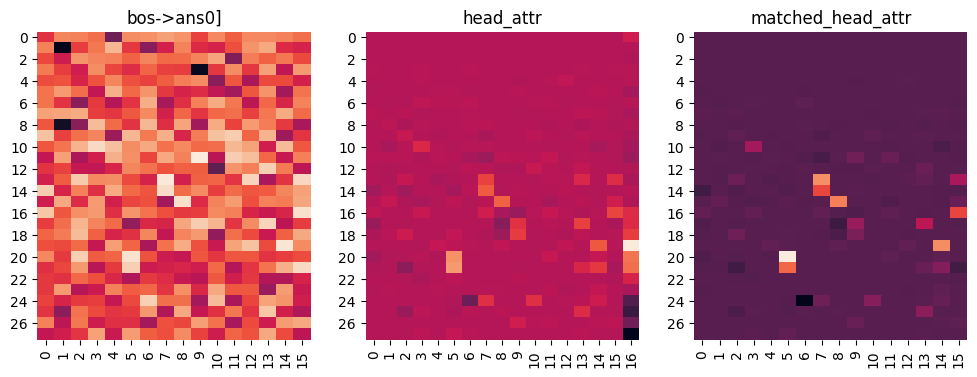

(array([11, 13, 19, 20, 16, 15, 14, 10, 21, 13]),
 array([ 9,  7, 14,  5, 15,  8,  7,  3, 15, 15]),
 array([-0.4349876, -0.5271155, -0.6725031, -0.7400898, -0.7721441,
       -0.7932828, -0.9576964, -1.026036 , -1.0345848, -1.0595406],
      dtype=float32))
(array([19, 21, 20, 20, 21, 15, 14, 19, 16, 13]),
 array([16,  5,  5, 16, 16,  8,  7, 14, 15,  7]),
 array([1.651996  , 1.029985  , 0.96665406, 0.78627765, 0.7544155 ,
       0.67617255, 0.62602866, 0.6084214 , 0.5003369 , 0.4799834 ],
      dtype=float32))
(array([20, 13, 19, 15, 21, 14, 16, 17, 13, 10]),
 array([ 5,  7, 14,  8,  5,  7, 15, 13, 15,  3]),
 array([1.3061308 , 0.9105848 , 0.9047116 , 0.85237265, 0.7648076 ,
       0.65368176, 0.64798385, 0.40298358, 0.3184108 , 0.2960562 ],
      dtype=float32))
[0] top[0, 3, 4] 20-5,15-8,21-5 attn_labels


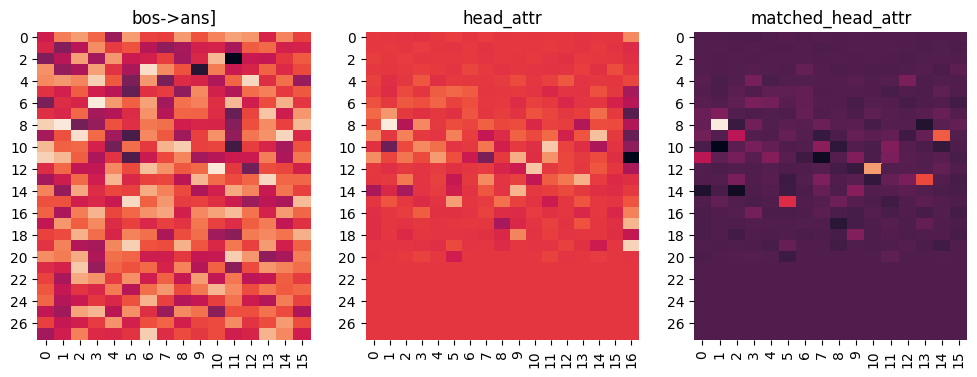

(array([ 6,  8, 12,  9,  3, 15, 13,  4,  9, 11]),
 array([ 3,  1, 10,  2,  6,  5, 13, 12, 14,  0]),
 array([-2.0047698, -2.0751946, -2.0947797, -2.3899155, -2.4032595,
       -2.5390391, -2.571194 , -2.5823462, -2.6415858, -2.7976642],
      dtype=float32))
(array([ 8, 19, 10, 12,  9, 14, 17, 13, 11, 15]),
 array([ 1, 16, 11, 10, 14,  9, 16, 13,  9,  5]),
 array([0.9747391 , 0.82241213, 0.7610413 , 0.7319919 , 0.7036818 ,
       0.64335304, 0.6406404 , 0.6252868 , 0.5944871 , 0.51662207],
      dtype=float32))
(array([ 8, 12,  9, 13, 15, 11,  9, 10, 14, 11]),
 array([ 1, 10, 14, 13,  5,  0,  2,  7,  9,  4]),
 array([0.46970972, 0.34943622, 0.26638612, 0.24318929, 0.20347148,
       0.15300176, 0.15045455, 0.08416142, 0.07752506, 0.07396084],
      dtype=float32))
[1] top[0, 1] 8-1,12-10


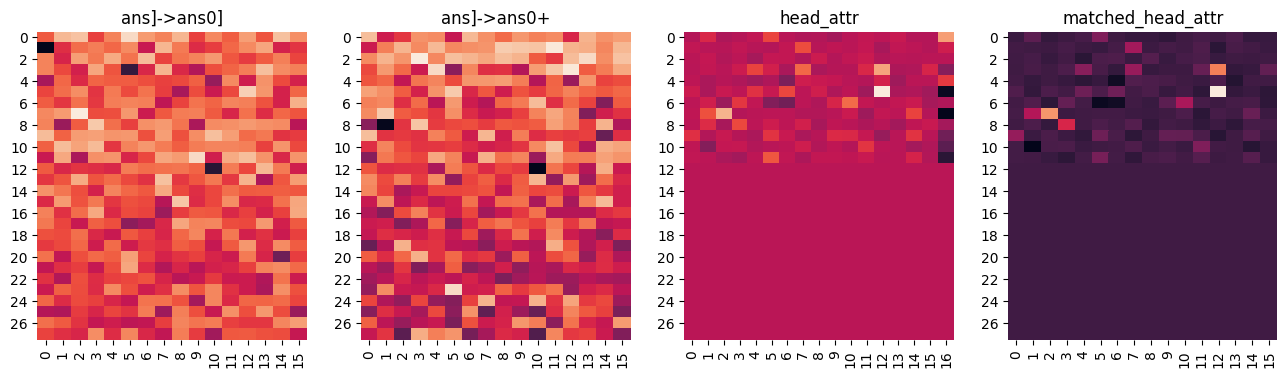

(array([ 7,  0, 11,  5,  8, 15,  0, 13,  0,  9]),
 array([ 2,  5,  9, 12,  3,  8,  2,  7, 14, 10]),
 array([-0.3700801 , -0.91300535, -0.93113196, -1.226944  , -1.4634625 ,
       -1.5716724 , -1.6603969 , -1.7137558 , -1.7353265 , -1.74996   ],
      dtype=float32))
(array([ 2,  1,  3, 23,  3,  2,  1,  7,  5,  1]),
 array([ 3, 11, 12,  5,  4, 13,  8,  1,  5,  9]),
 array([-0.34843445, -0.4046321 , -0.4277269 , -0.78305674, -0.78762954,
       -0.81143206, -1.1962155 , -1.2218091 , -1.2308171 , -1.3081578 ],
      dtype=float32))
(array([ 5,  7,  3,  0,  6,  3, 11,  7,  1,  8]),
 array([12,  2, 12, 16, 10,  7,  5,  1,  7,  3]),
 array([1.2855846 , 0.9356196 , 0.85248685, 0.8200028 , 0.5468836 ,
       0.5278702 , 0.44569322, 0.41489646, 0.39586794, 0.38460428],
      dtype=float32))
(array([5, 7, 3, 8, 7, 6, 1, 3, 9, 3]),
 array([12,  2, 12,  3,  1, 10,  7,  7,  0,  4]),
 array([0.61430156, 0.4553765 , 0.41683966, 0.2716534 , 0.20253491,
       0.18628792, 0.17362618, 0.15562657, 0.150

In [139]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [142]:
print(key); node = add_node_to_result(result, topi=[1, 2])

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0)
parent has not been attributed yet, replace it instead of adding to it.
 [-1] root labels┐
                 └[0] top[0, 3, 4] 20-5,15-8,21-5 attn_labels┐
                                                             └[1] top[0, 1] 8-1,12-10┐
                                                                                     └*[2] top[1, 2] 7-2,3-12...


Bo has a bear. Carl has a pineapple. Bo's bear
Christopher has wine. Morgan has spaghetti. Morgan's spaghetti
August has black. Ruby has a lime. August's black
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └*[1] top[0] 12-10
[-1] root labels


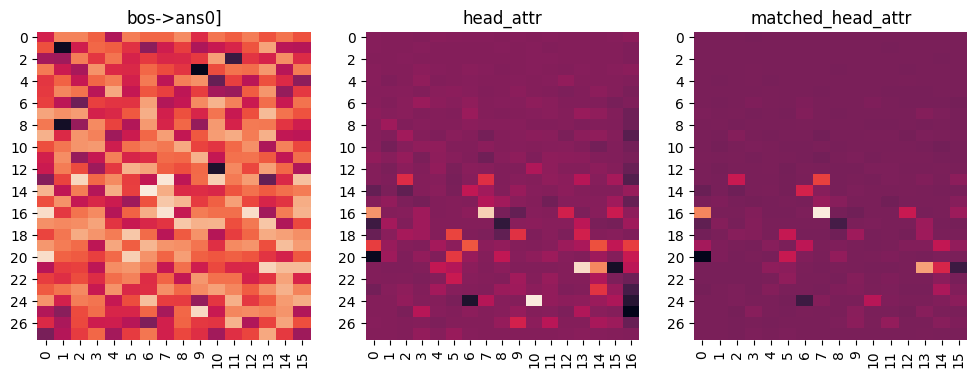

(array([14, 13, 16, 16, 20, 16, 25, 13, 21, 20]),
 array([ 6,  7,  7, 12,  0,  0,  9,  2, 13,  5]),
 array([-0.76847124, -0.91620743, -1.0253844 , -1.1890159 , -1.2004476 ,
       -1.2044504 , -1.3372848 , -1.4165361 , -1.4887413 , -1.6328306 ],
      dtype=float32))
(array([24, 21, 16, 16, 21, 19, 19, 18, 19, 19]),
 array([10, 13,  7,  0, 14,  6, 14,  5,  0, 16]),
 array([0.961745  , 0.89983845, 0.8550615 , 0.6408211 , 0.60438335,
       0.45135754, 0.433631  , 0.3990986 , 0.37840158, 0.37788907],
      dtype=float32))
(array([16, 21, 16, 13, 21, 14, 16, 13, 20, 18]),
 array([ 7, 13,  0,  7, 14,  6, 12,  2,  5,  5]),
 array([0.83389354, 0.604429  , 0.5320444 , 0.35702586, 0.27561784,
       0.26199418, 0.2219705 , 0.22174115, 0.22023506, 0.21290773],
      dtype=float32))
[0] top[0] 16-7 attn_labels


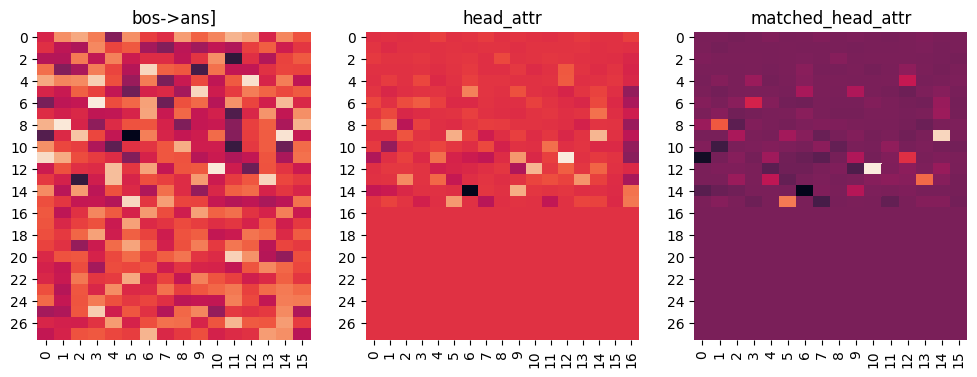

(array([ 6, 12,  8,  9,  4, 11, 15,  5,  3, 13]),
 array([ 3, 10,  1, 14, 12,  0,  5,  9,  6, 13]),
 array([-2.123184 , -2.2026026, -2.2260034, -2.3891857, -2.4952831,
       -2.658862 , -2.81563  , -2.8529582, -2.8708003, -2.9066348],
      dtype=float32))
(array([11, 12,  9,  9, 14, 15, 11, 13, 13,  5]),
 array([12, 10, 14,  5,  9,  5,  9, 13,  2,  6]),
 array([0.94266975, 0.6408508 , 0.6386491 , 0.59435934, 0.59105384,
       0.4876091 , 0.47970265, 0.4581871 , 0.40486157, 0.3693422 ],
      dtype=float32))
(array([12,  9, 15, 13,  8, 11,  6,  4, 13, 14]),
 array([10, 14,  5, 13,  1, 12,  3, 12,  4,  9]),
 array([0.2909516 , 0.26730826, 0.17317939, 0.1576349 , 0.14327697,
       0.10633796, 0.09084104, 0.07399539, 0.0668023 , 0.0574955 ],
      dtype=float32))
[1] top[0] 12-10


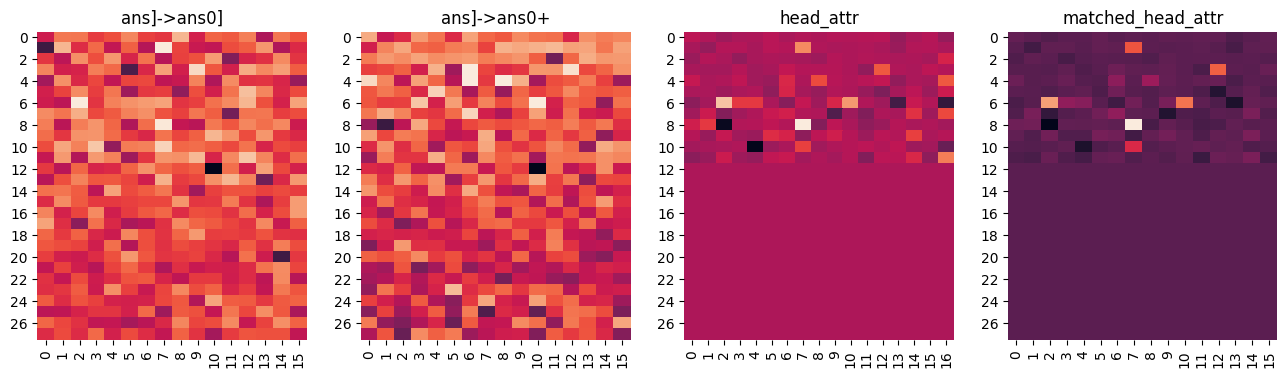

(array([ 1,  6,  8,  3, 10, 10, 11,  5, 11,  6]),
 array([ 7,  2,  7,  9,  7,  3, 12, 12,  9, 12]),
 array([-0.12368098, -0.13077638, -0.26115006, -0.78683645, -0.9868426 ,
       -1.4075432 , -1.4351188 , -1.6455195 , -1.8874338 , -1.9593313 ],
      dtype=float32))
(array([ 4,  6,  4,  3,  3,  4,  7,  5,  6, 23]),
 array([ 6, 10,  8,  6, 12,  0,  6,  4,  3,  5]),
 array([-0.31093156, -0.31979668, -0.3385723 , -0.34999603, -0.6376282 ,
       -0.84697556, -0.95705634, -1.0610068 , -1.3670614 , -1.6841705 ],
      dtype=float32))
(array([ 8,  6,  6,  1, 11,  4,  3,  4,  7, 10]),
 array([ 7,  2, 10,  7, 16, 16, 12,  8, 16,  7]),
 array([0.63601977, 0.5212428 , 0.40400568, 0.3651063 , 0.33129334,
       0.24795131, 0.24558514, 0.21417469, 0.21101579, 0.1912424 ],
      dtype=float32))
(array([ 8,  6,  6,  3,  1, 10,  4,  6,  7,  4]),
 array([ 7,  2, 10, 12,  7,  7,  8,  3,  6,  6]),
 array([0.29616523, 0.22044423, 0.18283053, 0.16659595, 0.15712117,
       0.11983133, 0.05907141, 0.04806

In [150]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [151]:
print(key); node = add_node_to_result(result, topi=[0, 1, 2, 3, 4])

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0] 12-10┐
                                                              └*[2] top[0, 1, 2, 3, 4] 8-7,6-2,6-10,3-12,1-7...


In [177]:
def plot_attn_attrs(data_tuples, model, tokenizer, node, topi=[0]):
    for l, h in zip(*np.array(topk_md(get_matched_head_attr(node.data), 10)[:2])[:, topi]):
        print(l, h)
        for data_tuple in data_tuples:
            plot_attn_attr(data_tuple, model, tokenizer, node, l, h, k_shot=k_shot,
                attn_patterns=attn_patterns_by_step[node.data.step])

12 10
tensor([-3.6134, -2.5552, -2.4820, -2.8550])


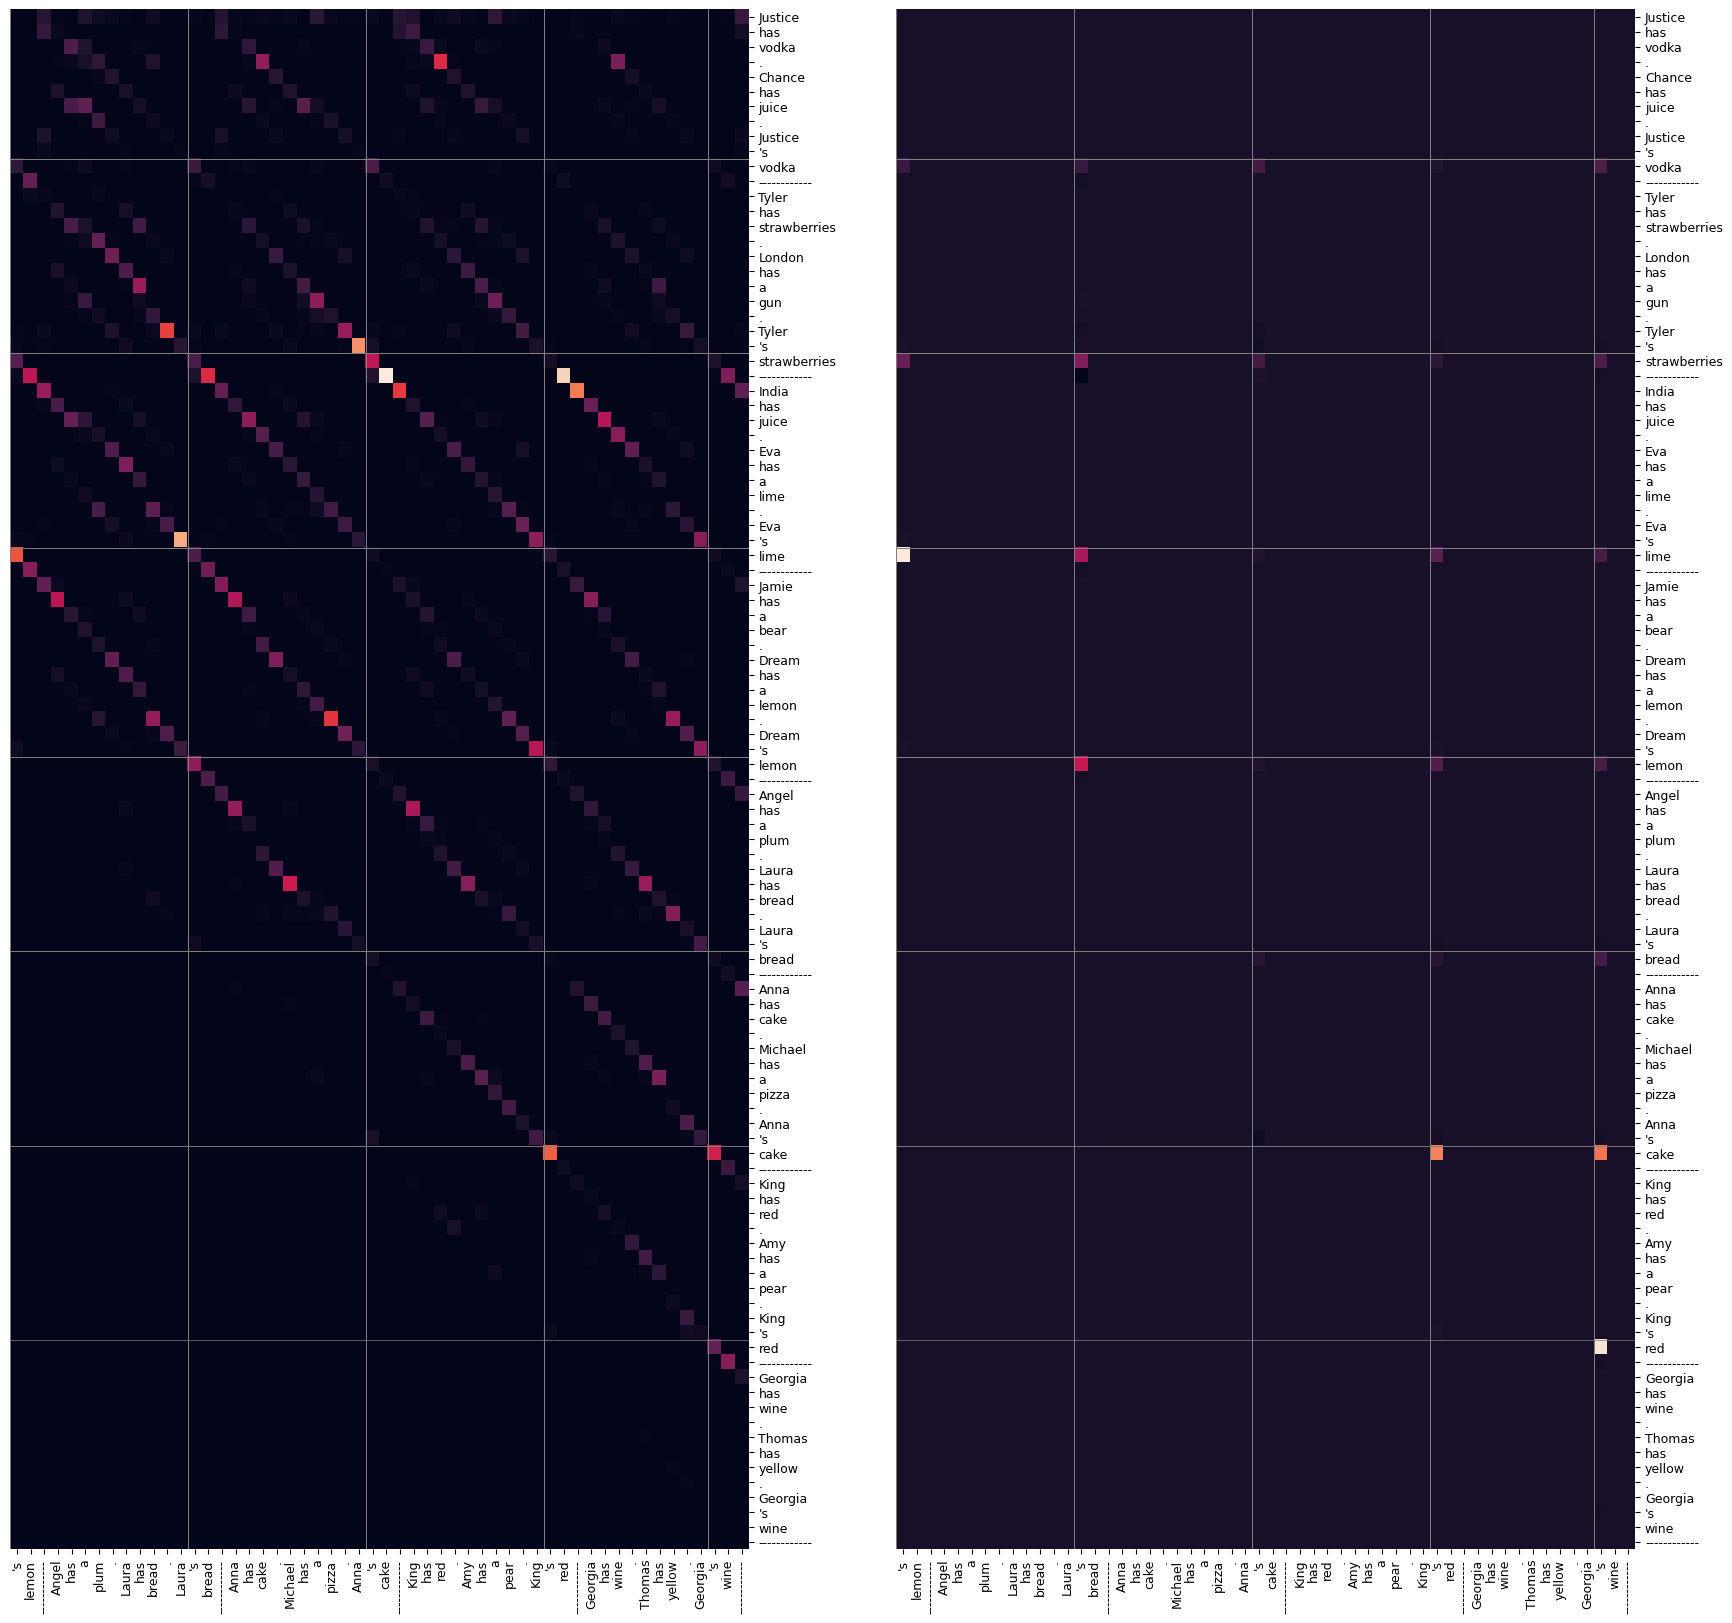

In [179]:
plot_attn_attrs(data_tuples[:1], model, tokenizer, node.parent.parent, topi=[0])  # step 1 intermediary head 12-10

16 7
tensor([-10.5445,  -2.6744,  -1.1017,  -1.0407])
 Ġvodka 0.222 {'ĠJuice': 0.294, 'Ġvodka': 0.222, 'Ġjuice': 0.137, 'j': 0.105} 	 Justice has vodka. Chance has juice. Justice's vodka
 Ġstrawberries 0.0 {'Ġvodka': 0.808, 'Ġjuice': 0.184, 'ĠJuice': 0.006, 'Ġjuices': 0.001} 	 Tyler has strawberries. London has a gun. Tyler's strawberries
 Ġlime 0.253 {'Ġa': 0.7, 'Ġlime': 0.253, 'ĠLime': 0.015, 'Ġgun': 0.012} 	 India has juice. Eva has a lime. Eva's lime
 Ġlemon 0.065 {'Ġlime': 0.9, 'Ġlemon': 0.065, 'ĠLime': 0.03, 'Ġcitrus': 0.002} 	 Jamie has a bear. Dream has a lemon. Dream's lemon
*Ġbread 0.717 {'Ġbread': 0.717, 'ĠBread': 0.28, 'bread': 0.003, 'Ġfood': 0.0} 	 Angel has a plum. Laura has bread. Laura's bread
*Ġcake 0.309 {'Ġcake': 0.309, 'cake': 0.246, 'ĠMichael': 0.179, 'Michael': 0.126} 	 Anna has cake. Michael has a pizza. Anna's cake
*Ġred 0.966 {'Ġred': 0.966, 'ĠRED': 0.019, 'Red': 0.005, 'ĠRed': 0.005} 	 King has red. Amy has a pear. King's red
 Ġwine 0.396 {'wine': 0.575, 'Ġwi

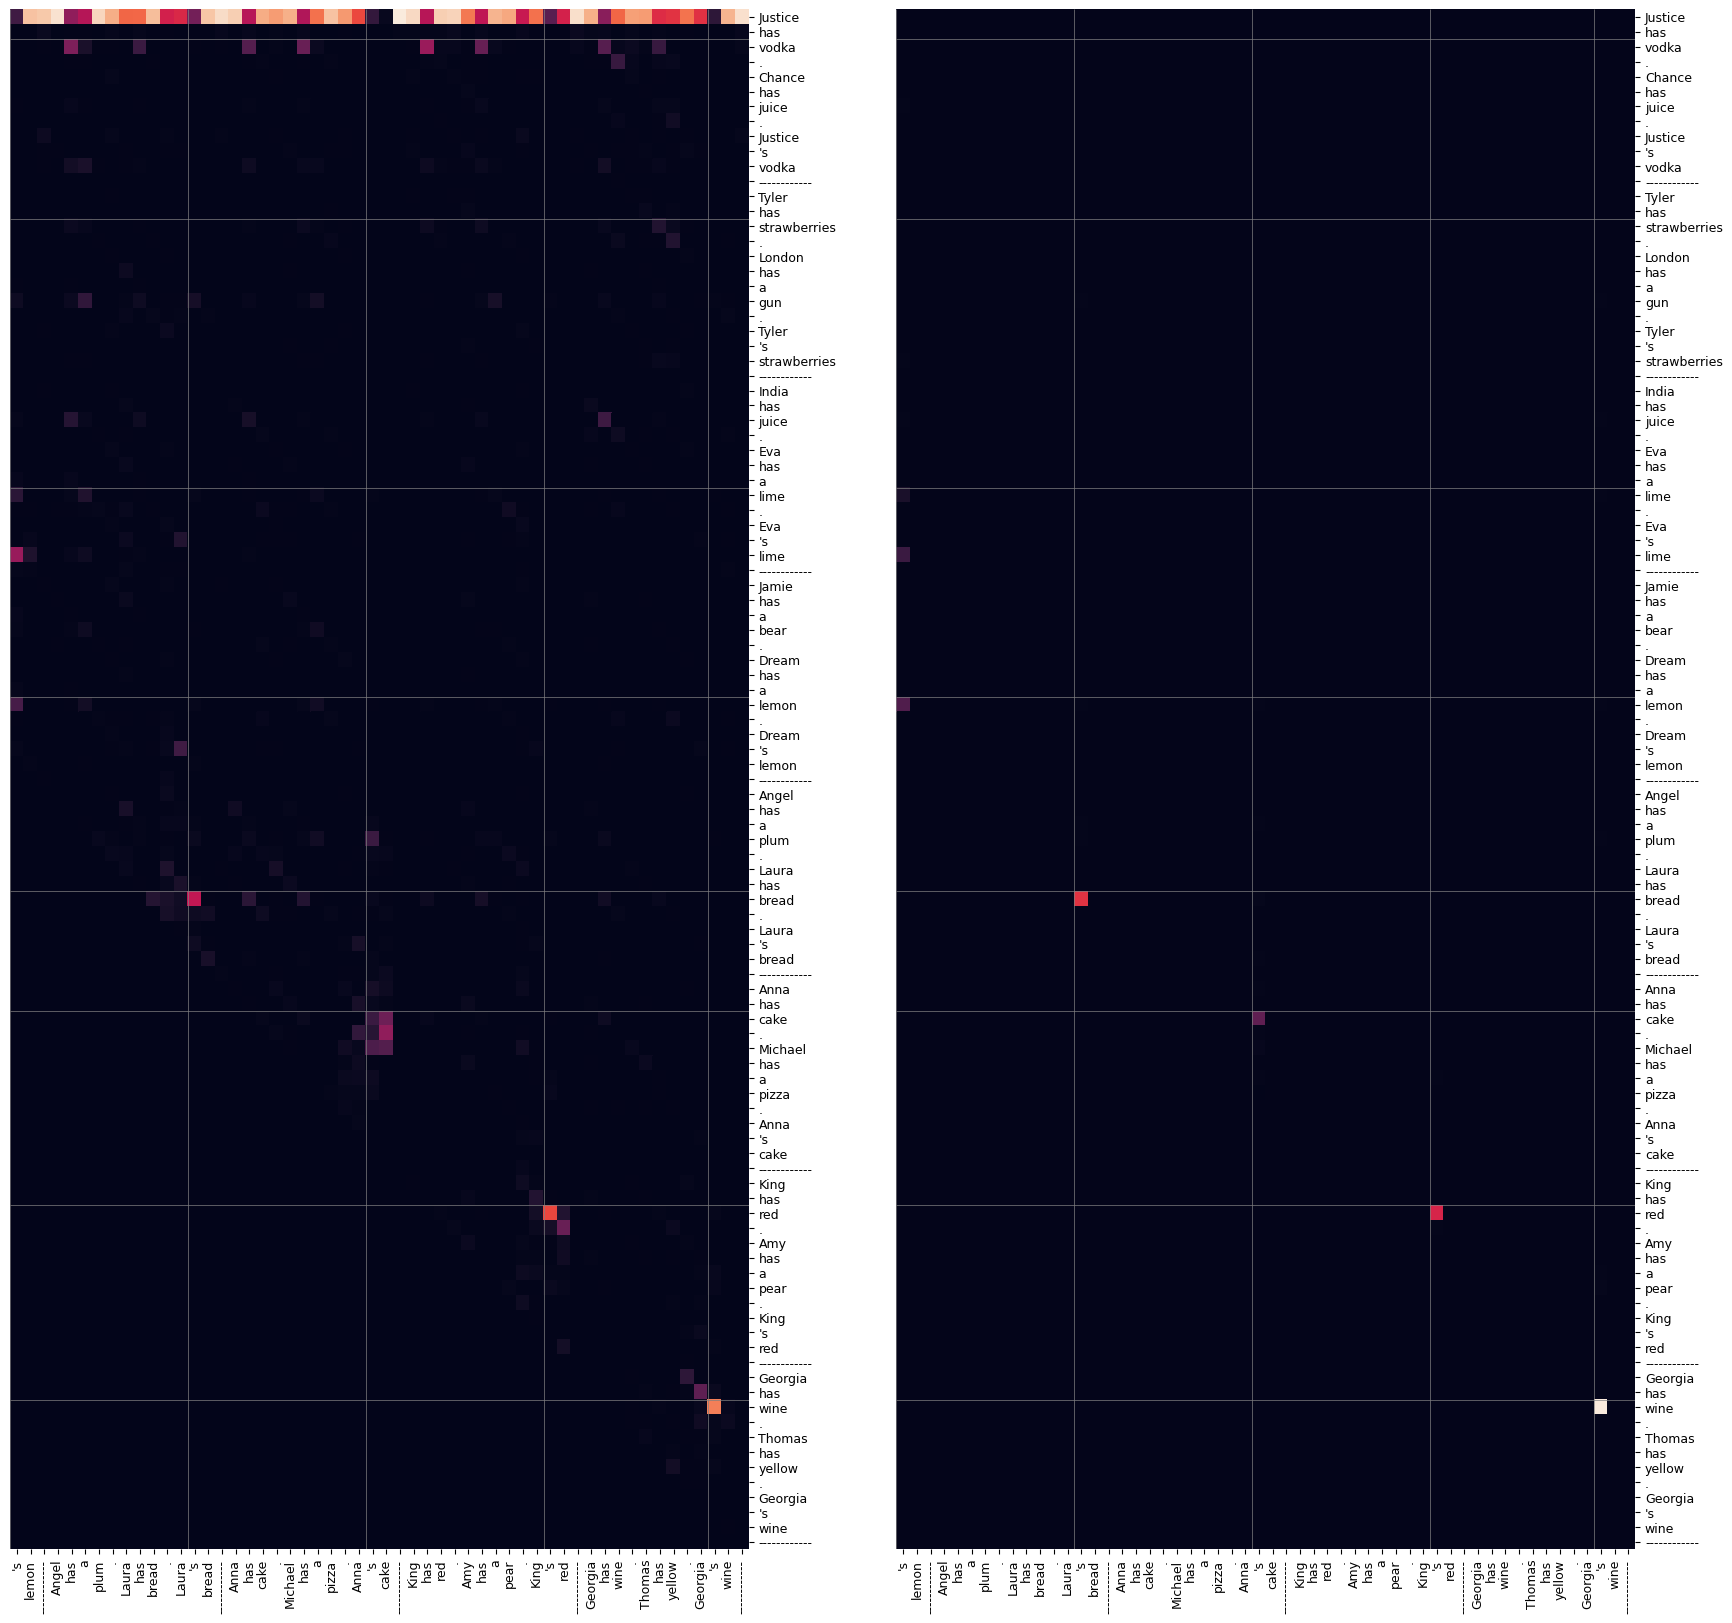

In [180]:
plot_attn_attrs(data_tuples[:1], model, tokenizer, node.parent.parent.parent, topi=[0])  # step 0 predicgting head 16-7

In [255]:
for head, prod in iweightprod(model, [(7, 2), (12, 10), [(21, 5), (20, 5), (15, 8)]], 'e vo vo qk e', weBTA=weBTAs[0], absorb_ln=True):
    print(head, plot_eigv(prod, plot=False))

(21, 5) (0.7073339819908142, 0.8719903230667114)
(20, 5) (-0.3651812970638275, 0.8842065334320068)
(15, 8) (0.8265929222106934, 0.9204588532447815)


In [254]:
for head, prod in iweightprod(model, [(8, 7), (12, 10), [(21, 5), (20, 5), (15, 8)]], 'e vo vo qk e', weBTA=weBTAs[0], absorb_ln=True):
    print(head, plot_eigv(prod, plot=False))

(21, 5) (0.9540624618530273, 0.9784843325614929)
(20, 5) (0.9560495018959045, 0.9772301912307739)
(15, 8) (0.9647945165634155, 0.9794634580612183)


Alan has a blackberry. Jacob has an elephant. Alan's fruit
Morgan has a gun. Davis has a hamburger. Morgan's weapon
Austin has a deer. Thomas has meat. Thomas's food
                 ┌[0] top[0, 1, 3] 20-5,21-5,15-8 attn_labels┐
                 │                                           └*[1] top[0, 1] 8-1,12-10
 [-1] root labels┤
                 ├[0] 11-9 attn_labels┐
                 │                    └[1] top[0] 8-1┐
                 │                                   └[2] top[0, 1] 3-12,7-2
                 └[0] top[0, 1, 3] 20-5,21-5,15-8 argmax_attn_labels┐
                                                                    └[1] top[0, 1] 8-1,12-10┐
                                                                                            └[2] top[0, 1, 3] 5-12,3-12,7-2
[-1] root labels


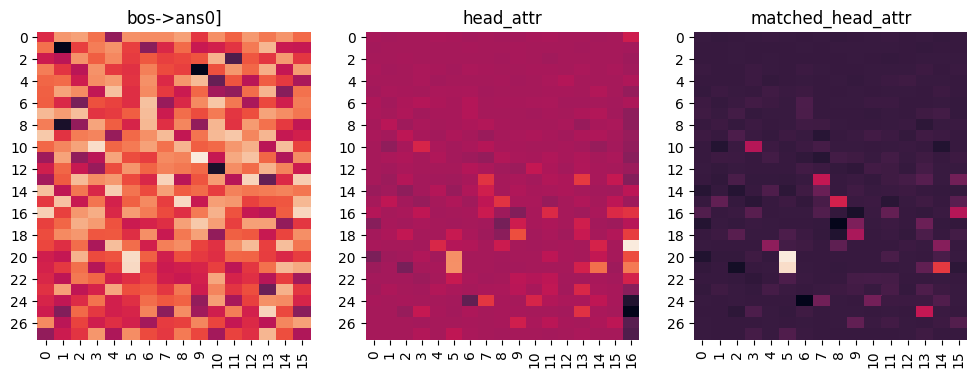

(array([11, 10, 20, 15, 21, 16, 13, 25, 13, 16]),
 array([ 9,  3,  5,  8,  5, 15, 12, 13,  7,  0]),
 array([-1.2674766, -1.6482041, -1.7172701, -1.7815722, -1.8076308,
       -1.8884598, -1.933879 , -1.9424105, -1.9547232, -2.0370746],
      dtype=float32))
(array([19, 21, 20, 21, 21, 18, 20, 18, 13, 24]),
 array([16,  5,  5, 16, 14,  9, 16, 16, 13,  7]),
 array([1.1065601 , 0.6738789 , 0.6702883 , 0.58036315, 0.5375647 ,
       0.41118476, 0.4067158 , 0.34230423, 0.32954222, 0.3187341 ],
      dtype=float32))
(array([20, 21, 21, 15, 13, 25, 10, 16, 18, 19]),
 array([ 5,  5, 14,  8,  7, 13,  3, 15,  9,  4]),
 array([0.390322  , 0.37279677, 0.20106155, 0.17056097, 0.1526186 ,
       0.15236934, 0.13750218, 0.13642497, 0.12428343, 0.09571555],
      dtype=float32))
[0] top[0, 1, 3] 20-5,21-5,15-8 attn_labels


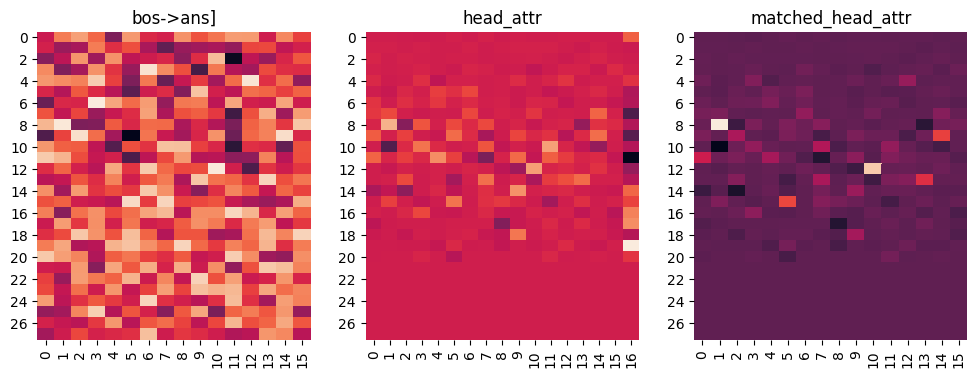

(array([ 6, 12,  8,  4,  3,  9,  9, 15, 16, 24]),
 array([ 3, 10,  1, 12,  6,  2, 14,  5, 11,  6]),
 array([-2.1202505, -2.1813905, -2.2281203, -2.3211892, -2.4319775,
       -2.5134633, -2.528109 , -2.6391044, -2.7577412, -2.7972775],
      dtype=float32))
(array([19,  8, 10, 12, 14, 17, 11, 16, 18, 15]),
 array([16,  1, 11, 10,  9, 16,  4, 16,  9,  5]),
 array([0.6698531 , 0.45983768, 0.40328616, 0.39848846, 0.35765412,
       0.3453579 , 0.34316713, 0.30421916, 0.27467614, 0.26424968],
      dtype=float32))
(array([ 8, 12, 15,  9, 13, 11, 10,  9, 13, 11]),
 array([ 1, 10,  5, 14, 13,  0,  7,  2,  7,  4]),
 array([0.20637919, 0.18267635, 0.10012855, 0.09701532, 0.08507187,
       0.07069803, 0.05257459, 0.04743757, 0.04717468, 0.04504041],
      dtype=float32))
[1] top[0, 1] 8-1,12-10


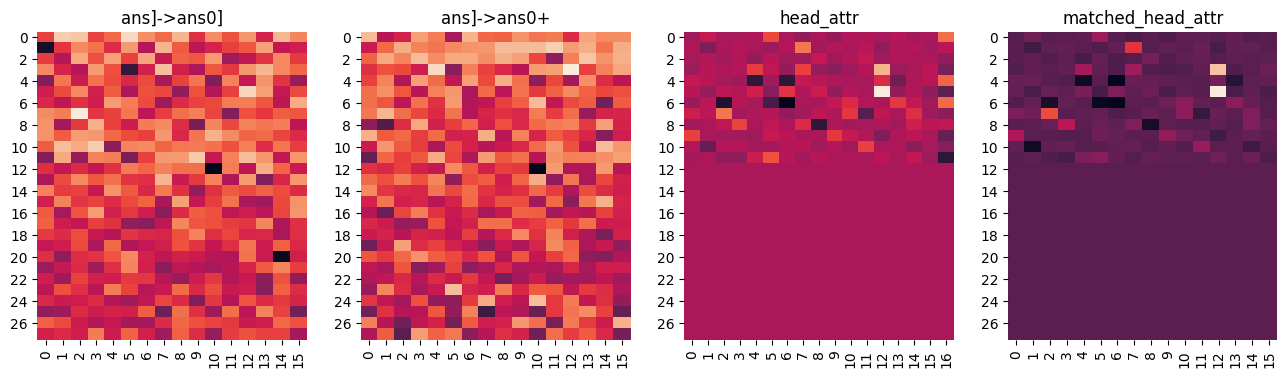

(array([ 7,  0,  5,  0, 10, 11,  0,  3, 10, 11]),
 array([ 2,  5, 12,  1,  3,  9,  2,  7,  1, 12]),
 array([-0.8029821, -1.3519015, -1.4143901, -1.6527418, -1.654027 ,
       -1.7690463, -1.8784103, -2.040913 , -2.0806189, -2.134634 ],
      dtype=float32))
(array([ 3,  3,  1,  2, 24, 23,  1,  2, 10,  1]),
 array([12,  4, 11, 13, 10,  5,  8,  3, 14,  9]),
 array([-0.7665804, -1.2390473, -1.479734 , -1.749217 , -1.8781241,
       -1.8878758, -1.9278226, -1.9299415, -1.9315186, -1.9402082],
      dtype=float32))
(array([ 5,  3,  7,  1,  0,  6,  4, 11,  0,  8]),
 array([12, 12,  2,  7, 16, 16, 16,  5,  5,  3]),
 array([0.86935115, 0.65089214, 0.43882847, 0.4347899 , 0.40814888,
       0.39541632, 0.37949353, 0.32751548, 0.29330683, 0.28055373],
      dtype=float32))
(array([ 5,  3,  7,  1,  8,  9,  3,  3,  0, 10]),
 array([12, 12,  2,  7,  3,  0,  4,  7,  5, 11]),
 array([0.38553452, 0.33191723, 0.19622234, 0.1699038 , 0.11536194,
       0.09843516, 0.08393712, 0.08256423, 0.07644407, 0.0

In [205]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [206]:
print(key); node = add_node_to_result(result, topi=[0,1,2])#, label_type='attn_labels')

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)
                 ┌[0] top[0, 1, 3] 20-5,21-5,15-8 argmax_attn_labels┐
                 │                                                  └[1] top[0, 1] 8-1,12-10┐
                 │                                                                          └[2] top[0, 1, 3] 5-12,3-12,7-2
 [-1] root labels┤
                 ├[0] top[0, 1, 3] 20-5,21-5,15-8 attn_labels┐
                 │                                           └[1] top[0, 1] 8-1,12-10┐
                 │                                                                   └*[2] top[0, 1, 2] 5-12,3-12,7-2...
                 └[0] 11-9 attn_labels┐
                                      └[1] top[0] 8-1┐
                                                     └[2] top[0, 1] 3-12,7-2


pmapped batch_predict ... done 0:00:00.000024
 Ġjacket 0.002 {'ĠJonathan': 0.043, 'ĠRaven': 0.036, 'Ċ': 0.014} 	 Kate beetle, Raven microwave, Jonathan jacket. Jonathan -> jacket
*Ġcherry 0.498 {'Ġcherry': 0.498, 'Ġbomb': 0.217, 'Ġspan': 0.125} 	 Walker cherry, Anne bomb, Eric spanner. Walker -> cherry
*Ġtaxi 0.701 {'Ġtaxi': 0.701, 'Ġtiger': 0.05, 'Ġjacket': 0.038} 	 Max taxi, Justice tiger, London jacket. Max -> taxi
 Ġcat 0.081 {'Ġant': 0.807, 'Ġcat': 0.081, 'ĠDream': 0.038} 	 Dream ant, John cat, James train. John -> cat
*Ġpap 0.988 {'Ġpap': 0.988, 'Ċ': 0.002, 'Ġcherry': 0.001} 	 Danny papaya, Paris helicopter, India cherry. Danny -> papaya
*Ġelephant 0.831 {'Ġelephant': 0.831, 'Ġsaw': 0.093, 'Ċ': 0.007} 	 Danny saw, Rose elephant, Matthew goose. Rose -> elephant
 Ġcat 0.038 {'Ġwater': 0.556, 'Ġgoose': 0.358, 'Ġcat': 0.038} 	 Virginia watermelon, Brian goose, Jennifer cat. Jennifer -> cat
*Ġlime 0.994 {'Ġlime': 0.994, 'ĠLime': 0.001, 'Ġlemon': 0.001} 	 Ocean lime, Robin sunflower, J

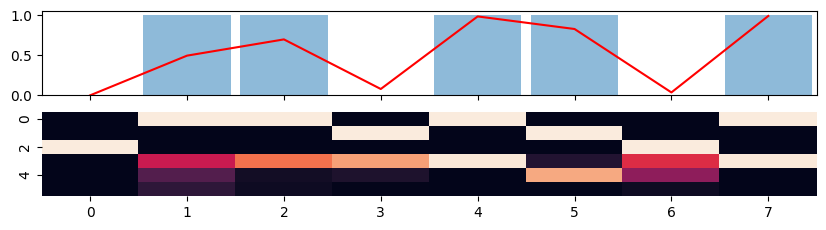

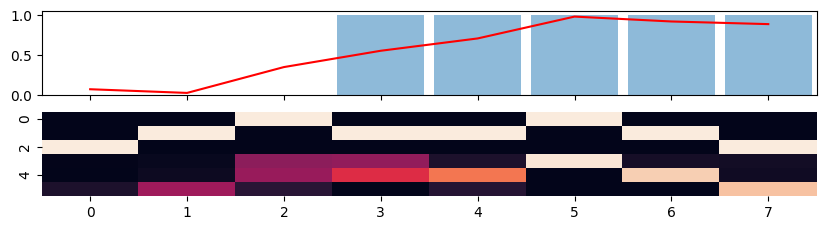

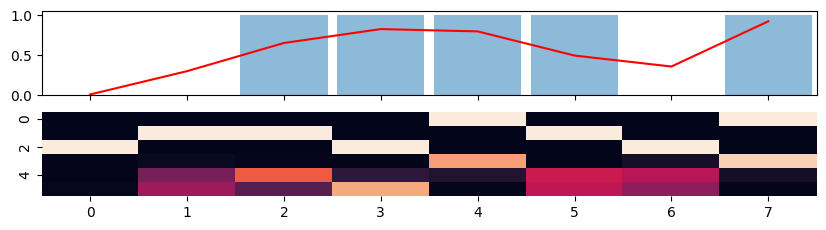

In [334]:
# seed(1234); torch.cuda.empty_cache()
model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-neox-20b', #'EleutherAI/gpt-neox-20b/cpu', 
               'text-curie-001', 'text-davinci-001', 'text-davinci-002'][:1]
metrics = dict(losses=defaultdict(list), accuracies=defaultdict(list))

def batch_predict(model, tokenizer):
    return [predict(model, tokenizer, text, examples, k_shot=k_shot, custom_forward=False, # avoid computing head_inputs
                    bos_token=bos_token, eos_token=eos_token, verbose=len(model_names) == 1)[1]
            for text, examples in zip(texts, all_examples)]
    
with Timer('pmapped batch_predict'):
    parallel = len(model_names) > 1
    pool = Pool(len(model_names)) if parallel else itertools  # with Pool(len(model_names)) as pool:
    results = pool.starmap(batch_predict, [models[model_name] for model_name in model_names])
    if parallel: pool.close(); pool.join()
            
# query2acc, query2loss = defaultdict(list), defaultdict(list)
for model_name, r in zip(model_names, results):
    _, tokenizer = models[model_name]
    for i, (loss, top1_corrects, answer_indices, answer_probs, candidate_probs) in enumerate(r):#.get()
        acc = top1_corrects[k_shot:] # np.array(top1_corrects[k_shot:]).mean()
        metrics['losses'][model_name].append(loss); metrics['accuracies'][model_name].append(acc)
        if batch_size == 1: print(model_name, loss, acc)
#         queries = [e[1] for e in _examples_list[i]][k_shot:]
#         for q, a, l in zip(queries, acc, loss): query2acc[q].append(float(a)); query2loss[q].append(l)
# print(sorted([(q, np.array(v).mean()) for q, v in query2acc.items()], key=lambda x: x[1]))

In [156]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

accuracies EleutherAI/gpt-j-6B/cpu 0.4444444444444444
accuracies EleutherAI/gpt-neox-20b 0.5555555555555556
accuracies text-curie-001 0.3333333333333333
losses EleutherAI/gpt-j-6B/cpu 3.0475401878356934
losses EleutherAI/gpt-neox-20b 2.3752387364705405
losses text-curie-001 5.4890399882962955


In [129]:
def cmp(a, b):
    print(a.dtype, a.size(), b.dtype, b.size())
    print('allclose:', torch.allclose(a, b), 'equal:', torch.equal(a, b))
    print((a == b).float().mean())
    print((a - b).float().abs().mean(), a.float().abs().mean(), b.float().abs().mean())
#     print((a - b).max(), (a - b).min())
#     print(a[a - b == (a - b).max()])
#     print(a[a - b == (a - b).min()])

In [47]:
# text, _examples = texts[0], _examples_list[0]
torch.cuda.empty_cache()
if True: #def predict2(model, tokenizer, text, _examples):
    examples, input_ids, tokens, bos_indices, eos_indices, answers, labels = make_data_tuple(
        text, tokenizer, k_shot=k_shot, bos_token=bos_token, eos_token=eos_token)
    candidates = [[tokenizer.encode(' ' + token)[0] for token in cands[0]] for _, _, cands, _ in _examples]
    with torch.no_grad():
        with Timer(): o0 = model(input_ids.to(model.device), output_attentions=True, output_hidden_states=True)
        with Timer(): o1 = forward0(model, input_ids.to(model.device), labels=labels.to(model.device),
                by_head=['head_input0', 'head_output0'], attn_weights=None, output_hidden_states=True)
        for o in [o0, o1]:
            logits = o.logits
            if isinstance(logits, torch.Tensor): logits = logits.to('cpu').float()# softmax on cpu needs float32
            loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
                examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, loss_reduction='none',
                candidates=candidates, k_shot=k_shot, topk=3, verbose=True)
            print('\n')
#     return loss, top1_corrects, answer_probs, candidate_probs

 ... done 0:00:02.348918
 ... done 0:00:01.659792
 ĠJ 0.032 {'Ċ': 0.074, 'ĠS': 0.038, 'Ġ': 0.036} 	 S J Y -> J
*ĠN 0.429 {'ĠN': 0.429, 'ĠR': 0.223, 'ĠA': 0.074} 	 A N R -> N
 ĠC 0.247 {'ĠV': 0.649, 'ĠC': 0.247, 'ĠB': 0.018} 	 B C V -> C
*ĠT 0.443 {'ĠT': 0.443, 'ĠK': 0.393, 'ĠS': 0.085} 	 S T K -> T
*ĠR 0.839 {'ĠR': 0.839, 'ĠT': 0.099, 'ĠA': 0.021} 	 A R T -> R
*ĠH 0.562 {'ĠH': 0.562, 'ĠQ': 0.278, 'ĠE': 0.112} 	 E H Q -> H
*ĠO 0.792 {'ĠO': 0.792, 'ĠF': 0.161, 'ĠN': 0.013} 	 N O F -> O
*ĠA 0.626 {'ĠA': 0.626, 'ĠI': 0.225, 'ĠY': 0.11} 	 Y A I -> A


 ĠJ 0.032 {'Ċ': 0.074, 'ĠS': 0.038, 'Ġ': 0.036} 	 S J Y -> J
*ĠN 0.429 {'ĠN': 0.429, 'ĠR': 0.223, 'ĠA': 0.074} 	 A N R -> N
 ĠC 0.247 {'ĠV': 0.649, 'ĠC': 0.247, 'ĠB': 0.018} 	 B C V -> C
*ĠT 0.443 {'ĠT': 0.443, 'ĠK': 0.393, 'ĠS': 0.085} 	 S T K -> T
*ĠR 0.839 {'ĠR': 0.839, 'ĠT': 0.099, 'ĠA': 0.021} 	 A R T -> R
*ĠH 0.562 {'ĠH': 0.562, 'ĠQ': 0.278, 'ĠE': 0.112} 	 E H Q -> H
*ĠO 0.792 {'ĠO': 0.792, 'ĠF': 0.161, 'ĠN': 0.013} 	 N O F -> O
*ĠA 0.62

In [176]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

accuracies EleutherAI/gpt-j-6B 0.4976851851851852
accuracies EleutherAI/gpt-neox-20b 0.5023148148148148
accuracies text-davinci-001 0.48148148148148145
accuracies text-davinci-002 0.9675925925925926
losses EleutherAI/gpt-j-6B 1.3536101162543572
losses EleutherAI/gpt-neox-20b 1.1634638377252957
losses text-davinci-001 1.687816629922939
losses text-davinci-002 0.1085046497381794


In [136]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name])[:,:27].mean())

accuracies EleutherAI/gpt-j-6B 0.6203703703703703
accuracies EleutherAI/gpt-neox-20b 0.7083333333333334
accuracies text-curie-001 0.5879629629629629
losses EleutherAI/gpt-j-6B 1.5619440356433054
losses EleutherAI/gpt-neox-20b 1.0779137232247094
losses text-curie-001 3.1073556870623844


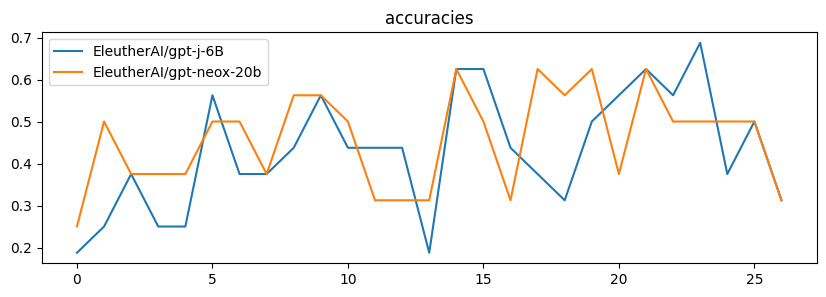

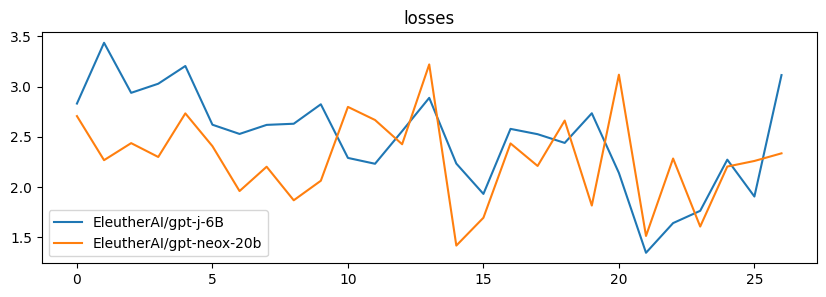

In [191]:
for metric in ['accuracies', 'losses']:
    _ = plt.figure(figsize=(10, 3));
    for model_name in model_names[:2]:
        plt.plot(np.array(metrics[metric][model_name])[:].mean(0), label=f'{model_name}');
    _ = plt.legend();  _ = plt.title(metric); _ = plt.show();

In [11]:
time2prep = {tuple(clock_of_day): 'at', tuple(days_of_week): 'on', tuple(months): 'in'}
def lookup_item2str(item, vocab=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        return f'{item[1]} came {prep} {item[0]}'
    elif vocab[0] == digits:
        return f'{item[1]} is {item[0]}'
def lookup_query2str(query, vocab=None, rel_name=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        prep = {'prev': 'just before', 'next': 'just after', 'same': prep}[rel_name]
        return f'Who came {prep} {query}?'
    elif vocab[0] == digits:
        prep = {'prev': 'a year younger than', 'next': 'a year younger than', 'same': ''}[rel_name]
        return f'Who is {prep} {query}'

In [81]:
text = '''Aaren is a boy. Harlow is a girl.
Harlow called Aaren.
Harlow: "Are you a girl?"
Aaren: "'''
model_name = 'EleutherAI/gpt-j-6B'
model, tokenizer = models[model_name]
input_ids = tokenizer.encode(text, return_tensors='pt')
logits = model(input_ids.to(getattr(model, 'device', 'cpu'))).logits

In [80]:
show_topk(*logits[0][-1].softmax(-1).topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

{'Yes': 0.35, 'No': 0.226, 'Yeah': 0.078, 'I': 0.078, 'Y': 0.021}

In [75]:
get_prob_dist(logits.top_logprobs[-1], 5)

{'No': 0.824, 'Yes': 0.115, 'I': 0.04, 'What': 0.006, ' No': 0.003}

In [155]:
text = 'The capital of Canada is'
input_ids = tokenizer(text, return_tensors='pt').input_ids
list(zip(tokenizer.convert_ids_to_tokens(input_ids[0]), input_ids[0].numpy()))
outputs = model.generate(input_ids, max_length=10)
tokenizer.decode(outputs[0], skip_special_tokens=True)

[('▁The', 37),
 ('▁capital', 1784),
 ('▁of', 13),
 ('▁Canada', 1894),
 ('▁is', 19),
 ('</s>', 1)]

'Ottawa. It is the largest city in Canada'

In [478]:
# nrows = 5; k_shot = nrows // 2 + 1
# for pairs in [drop_first_and_last, ]:
nrows = 6;  k_shot = 3
for pairs in reversible_transformations + irreversible_transformations:
    seps = [' -> ', '->'] if random.random() < 0.5 else ['->', ' -> ']
    # seps = [' -> ', ' -> ']
    samples = ['\n' + '\n'.join(a + seps[0] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[0])[0])))
    samples = ['\n' + '\n'.join(b + seps[1] + a for a, b in sample(pairs, nrows)) + '\n' if pairs in reversible_transformations else 
                '\n' + '\n'.join(a + seps[1] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[1])[0])))

In [ ]:
# # sys.path.insert(0, '/nas/xd/projects/ec')
# from child_utils import loadPBETasks, retrieveJSONTasks
# challenge, challengeCheating = loadPBETasks('/nas/xd/projects/ec/PBE_Strings_Track')
# challenge2, challengeCheating2 = loadPBETasks('/nas/xd/projects/ec/data/sygus')
# tasks = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks.json")
# tasks2 = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks2.json")

In [ ]:
from lxy_utils import get_examples_behind, get_examples_before, get_examples_query_before, \
    get_examples_query_behid, get_examples_query_repeat

In [ ]:
reversible_transformations = [list(digit2cardinal.items()), noun2adj, lxy, verb_form, country2capital, en2fr, antonyms]
irreversible_transformations = [capabilities]

In [197]:
losses = []
for model_name, (model, tokenizer) in models.items():
    if any(model_name.startswith(s) for s in ['gpt2-', 'KoboldAI/fairseq-dense', 'text-davinci-001', ]): continue
    if not model_name == 'EleutherAI/gpt-j-6B': continue
    if not isinstance(model, types.FunctionType): _ = model.eval()
    with Timer(model_name): outputs = model(**inputs)
    options_ids_list = [[tokenizer.encode(' ' + option)[0] for option in options] for cxt, query, options, ans in _examples]
    mask_logits_fn = partial(mask_logits, indices=bos_indices, kept_ids=options_ids_list)
    loss, all_top1_correct = show_predictions(text, examples, tokenizer, outputs.logits, bos_indices, eos_indices, answers, labels,
                    mask_logits_fn=None, topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
    print(loss, all_top1_correct, '\n')
    losses.append(loss.item() if hasattr(loss, 'item') else loss)
    if model_name == 'EleutherAI/gpt-j-6B': break
print(sum(losses) / len(losses))

EleutherAI/gpt-j-6B ... done 0:00:01
* C 0.842 {' C': 0.842, ' A': 0.041, ' B': 0.04} 	 D -> C
* Thursday 0.778 {' Thursday': 0.778, ' Wednesday': 0.064, ' Friday': 0.063} 	 Friday -> Thursday
* a 0.742 {' a': 0.742, ' c': 0.051, ' A': 0.036} 	 b -> a
* four 0.472 {' four': 0.472, ' three': 0.246, ' one': 0.105} 	 five -> four
tensor(0.3677, grad_fn=<NllLossBackward>) True 

0.3677041530609131


In [24]:
relational_functions = [prev(), next()]
rel_fns = [prevs, nexts]

**TODO: read children books for more posets**  
**TODO: Prompt gpt3 to elicit the posets it knows**  
$x \to f(x)$ where $f \in \{\text{prev/next in posets of numbers/letters/months/days, antonym, hypernym, hyponym, ...}\}$  
$x \to f^2(x)$  
one poset or mixed posets  
$x, f(x).~y \to Ff^{[-1]}(y)$ one poset or mixed posets  
$x, f^k(x).~y \to Ff^{[-1]}(y)~/Ff^{[-]k}(y)$  
$x, f(f(x))~/f(f(x)), x \to f(x)$ in between, the simplest form of sequence completion  
$x, f(x) \to Gf$ where $Gf \in \{<, >\}$  
$x, f(x); y, g(y) \to Ff \stackrel{?}{=} g^{[-1]}$ where $\text{output} \in \{\text{True}, \text{False}\}$  
sort

There is a *natural* monotone map/functor $F$ between posets/sets $A$ and $B$.  Compose the computation (set operations, sorting etc.) between $A$ and $B$ with $F$ to make harder tasks.  
$P(A) ,P(B) \to F(P(A)) \setminus ~/ \cap ~/ \triangle P(B)$. Harder form of set difference/intersection.  
$P(A) \to F(\text{sorted}(P(A)))$. Harder form of sorting.


In [385]:
n_total, n_valid = 192, 64
n_train = n_total - n_valid

input_strs = [make_input_str(tasks[4], nrows=4, ncols=5) for __ in range(n_total)]
for s in sample(input_strs, 3): print(s)

Instruction: replace with the other. For example:
G H G G G -> H G H H H
I I I I M -> M M M M I
A A F A A -> F F A F F
9 9 9 I I -> I I I 9 9

Instruction: replace with the other. For example:
V Q Q V V -> Q V V Q Q
G L L G L -> L G G L G
G 2 2 2 G -> 2 G G G 2
I I Z Z Z -> Z Z I I I

Instruction: replace with the other. For example:
R H H H R -> H R R R H
B 9 9 B B -> 9 B B 9 9
D 2 2 2 D -> 2 D D D 2
A A A A W -> W W W W A



In [368]:
sum(s.count('Yes') for s in input_strs)

370

In [322]:
train_dataset = CHILDDataset(input_strs[:-n_valid], tokenizer)
eval_dataset = CHILDDataset(input_strs[-n_valid:], tokenizer)

In [121]:
if n_total == 1:
    inputs = tokenizer.encode_plus(text, return_tensors='pt')
    inputs = prepare_inputs(inputs, model.device)
    outputs = model(**inputs, output_attentions=False)

    # assert inputs.input_ids.size(0) == 1
    input_ids = inputs.input_ids
    logits = outputs.logits

    bsz = input_ids.size(0); assert bsz == 1
    labels = torch.ones_like(input_ids) * (-100)
    for bi in range(bsz):
        bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
        eos_indices = (input_ids[bi] == eos_id).nonzero()[-nrows:].squeeze(1)
        for i, (example, bos_i, eos_i) in enumerate(zip(examples, bos_indices.tolist(), eos_indices.tolist())):
            print(' ' + make_example_str(example))
            ans_ids = input_ids[bi, bos_i + 1: eos_i]
            if i >= 2: labels[bi, bos_i: eos_i - 1] = ans_ids
            ans_prob_dist = logits[bi, bos_i: eos_i - 1].softmax(-1)
            ans_probs = ans_prob_dist[torch.arange(ans_prob_dist.size(0)), ans_ids]
            ans_tokens = tokenizer.convert_ids_to_tokens(ans_ids)
            for ans_id, ans_token, ans_prob, dist in zip(ans_ids, ans_tokens, numpy(ans_probs, decimals=3), ans_prob_dist):
                top1_correct = (dist.argmax() == ans_id).item()
                print(('*' if top1_correct else ' ') + ans_token, ans_prob, 
                      show_topk(*dist.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)) 
    loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1))
    loss

In [329]:
training_args = TrainingArguments(output_dir="./models/model_name", 
    overwrite_output_dir=True, do_train=True, do_eval=True,
    per_device_train_batch_size=16, per_device_eval_batch_size=16,
    weight_decay=0.01, adam_beta2=0.98, adam_epsilon=1e-6,
    lr_scheduler_type='constant', learning_rate=5e-3, num_train_epochs=4,
    logging_strategy ='epoch', evaluation_strategy ='epoch', save_steps=0,
    no_cuda=True, report_to='none',  # to avoid report to wandb
)

In [330]:
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,
                  optimizers=(create_optimizer(model, training_args), None))

In [333]:
trainer.place_model_on_device

True

In [ ]:
def get_prev(elem):
    i, v = elem
    return _l[i - 1] if i > 0 else None

false = lambda *_: False
true  = lambda *_: True

In [ ]:
Element = namedtuple('Element', 'index value')
_l = 'A B C B'.split()
n = len(_l)
# l = [Element._make(e) for e in enumerate(l)]
l = seq(_l)
l = l.enumerate().map(Element._make)

In [6]:
l.map(lambda x: {'B': 'D'}.get(x, x))

l.filter(lambda x: get_prev(x) == 'B').select(_.value)

find_fn = _.index == 1
l.filter(find_fn).select(_.value).map(lower)

find_fn = _.value == 'C'
l.filter(find_fn).select(_.index)

# move x to first
update_filter = _.value == 'C'
get_new = lambda x: -1
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# swap first and last
update_filter = true
get_new = lambda x: {0: n - 1, n - 1: 0}.get(x.index, x.index)
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# get inbetween == drop_while + take_while?

# update by index to its prev
update_filter = _.index == 1
get_new = lambda x: get_prev(x)
def update_fn(x, update_field): return get_new(x) if update_filter(x) else getattr(x, update_field)
l.map(lambda x: Element(x.index, update_fn(x, 'value')))

# if two adjacent elements by indices are equal
l.filter(lambda x: x.index in [0, 1]).select(_.value).distinct().len() == 1

seq('A B C B C'.split()).group_by(_).select(_[1]).flatten()

# count occurance till current
seq('A B A C B A'.split()).inits().reverse().tail().map(lambda x: x.filter(_ == x.last()).len())

# find special
seq('A B A A'.split()).count_by_value().filter(_[1] == 1).select(_[0])

# generalized find special
seq('A A B C C D D'.split()).group_by(_).map(lambda x: (x[0], len(x[1]))).filter(_[1] == 1).select(_[0])